In [1]:
!hostname

nid004215


In [2]:
!pwd

/global/cfs/cdirs/m4334/jerry/climsim3_dev


# Import packages

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.transforms import blended_transform_factory
import os, gc, sys, glob, string, argparse
from tqdm import tqdm
import time
import string
import itertools
import sys
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from climsim_utils.data_utils import *

# Set fontsizes

In [4]:
plt.rcParams.update({
    "axes.titlesize":   14,
    "axes.labelsize":   13,
    "figure.titlesize": 17,
    "xtick.labelsize":  11,
    "ytick.labelsize":  11,
    "legend.fontsize":  12,
})

def scale_default(param_name, scale_factor):
    """Get scaled version of default rcParam"""
    return plt.rcParams[param_name] * scale_factor

# Load utilities

In [5]:
grid_path = '/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc'

input_mean_v2_rh_mc_file = 'input_mean_v2_rh_mc_pervar.nc'

input_max_v2_rh_mc_file = 'input_max_v2_rh_mc_pervar.nc'
input_min_v2_rh_mc_file = 'input_min_v2_rh_mc_pervar.nc'
output_scale_v2_rh_mc_file = 'output_scale_std_lowerthred_v2_rh_mc.nc'

input_mean_v6_file = 'input_mean_v6_pervar.nc'
input_max_v6_file = 'input_max_v6_pervar.nc'
input_min_v6_file = 'input_min_v6_pervar.nc'
output_scale_v6_file = 'output_scale_std_lowerthred_v6.nc'

lbd_qn_file = 'qn_exp_lambda_large.txt'

grid_info = xr.open_dataset(grid_path)
grid_area = grid_info['area'].values
area_weight = grid_area/np.sum(grid_area)
level = grid_info.lev.values

input_mean_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_mean_v2_rh_mc_file)
input_max_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_max_v2_rh_mc_file)
input_min_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_min_v2_rh_mc_file)
output_scale_v2_rh_mc = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/' + output_scale_v2_rh_mc_file)

input_mean_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_mean_v6_file)
input_max_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_max_v6_file)
input_min_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + input_min_v6_file)
output_scale_v6 = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/outputs/' + output_scale_v6_file)

lbd_qn = np.loadtxt('/global/cfs/cdirs/m4334/jerry/climsim3_dev/preprocessing/normalizations/inputs/' + lbd_qn_file, delimiter = ',')

data_v2_rh_mc = data_utils(grid_info = grid_info, 
                           input_mean = input_mean_v2_rh_mc, 
                           input_max = input_max_v2_rh_mc, 
                           input_min = input_min_v2_rh_mc, 
                           output_scale = output_scale_v2_rh_mc,
                           qinput_log = False,
                           normalize = False)
data_v2_rh_mc.set_to_v2_rh_mc_vars()

data_v6 = data_utils(grid_info = grid_info,
                     input_mean = input_mean_v6,
                     input_max = input_max_v6,
                     input_min = input_min_v6,
                     output_scale = output_scale_v6,
                     qinput_log = False,
                     normalize = False)                     
data_v6.set_to_v6_vars()

actual_input_v2_rh_mc = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/actual_input.npy')
actual_target_v2_rh_mc = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/actual_target.npy')

actual_input_v6 = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v6/test_set/actual_input.npy')
actual_target_v6 = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v6/test_set/actual_target.npy')

assert np.array_equal(actual_target_v2_rh_mc, actual_target_v6)
actual_target = np.load('/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/original_test_vars/actual_target_v2.npy')
del actual_target_v2_rh_mc
del actual_target_v6

assert np.array_equal(actual_input_v2_rh_mc[:,:,data_v2_rh_mc.ps_index], 
                      actual_input_v6[:,:,data_v6.ps_index])

surface_pressure = actual_input_v2_rh_mc[:, :, data_v2_rh_mc.ps_index]
hyam_component = (data_v2_rh_mc.hyam * data_v2_rh_mc.p0)[None,None,:]
hybm_component = data_v2_rh_mc.hybm[None,None,:] * surface_pressure[:,:,None]
pressures = hyam_component + hybm_component
pressures_binned = data_v2_rh_mc.zonal_bin_weight_3d(pressures)
lat_bin_mids = data_v2_rh_mc.lat_bin_mids
lats = data_v2_rh_mc.lats
lons = data_v2_rh_mc.lons

idx_p400_t10 = np.load('/pscratch/sd/z/zeyuanhu/hu_etal2024_data/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[np.newaxis,:]

idx_tropopause_zm = data_v2_rh_mc.zonal_bin_weight_2d(idx_p400_t10).flatten()

area_weight_dict = {
    'global': area_weight,
    'nh': np.where(lats > 30, area_weight, 0),
    'sh': np.where(lats < -30, area_weight, 0),
    'tropics': np.where((lats > -30) & (lats < 30), area_weight, 0)
}

lat_idx_dict = {
    '30S_30N': ((data_v2_rh_mc.lats < 30) & (data_v2_rh_mc.lats > -30))[None,:,None],
    '30N_60N': ((data_v2_rh_mc.lats < 60) & (data_v2_rh_mc.lats > 30))[None,:,None],
    '30S_60S': ((data_v2_rh_mc.lats < -30) & (data_v2_rh_mc.lats > -60))[None,:,None],
    '60N_90N': (data_v2_rh_mc.lats > 60)[None,:,None],
    '60S_90S': (data_v2_rh_mc.lats < -60)[None,:,None]
}

pressure_idx_dict = {
    'below_400hPa': pressures >= 400,
    'above_400hPa': pressures < 400
}

config_names = {
    'standard': 'Standard',
    'conf_loss': 'Confidence Loss',
    'diff_loss': 'Difference Loss',
    'multirep': 'Multirepresentation',
    'v6': 'Expanded Variable List'
}

model_names = {
    'unet': 'U-Net',
    'squeezeformer': 'Squeezeformer',
    'pure_resLSTM': 'Pure ResLSTM',
    'pao_model': 'Pao Model',
    'convnext': 'ConvNeXt',
    'encdec_lstm': 'Encoder-Decoder LSTM'
}

color_dict = {
    'unet': 'green',
    'squeezeformer': 'purple',
    'pure_resLSTM': 'blue',
    'pao_model': 'red',
    'convnext': 'gold',
    'encdec_lstm': 'orange',
}

color_dict_config = {
    'standard': 'blue',
    'conf_loss': 'cyan',
    'diff_loss': 'red',
    'multirep': 'orange',
    'v6': 'green'
}

offline_var_settings = {
    'DTPHYS': {'var_title': 'dT/dt', 'scaling': 1., 'unit': 'K/s', 'vmax': 5e-7, 'vmin': -5e-7, 'var_index':0},
    'DQ1PHYS': {'var_title': 'dQv/dt', 'scaling': 1e3, 'unit': 'g/kg/s', 'vmax': 1e-6, 'vmin': -1e-6, 'var_index':60},
    'DQ2PHYS': {'var_title': 'dQl/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'vmax': 1e-3, 'vmin': -1e-3, 'var_index':120},
    'DQ3PHYS': {'var_title': 'dQi/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'vmax': 1e-3, 'vmin': -1e-3, 'var_index':180},
    'DUPHYS': {'var_title': 'dU/dt', 'scaling': 1., 'unit': 'm/s/s', 'vmax': 5e-7, 'vmin': -5e-7, 'var_index':240},
    'DVPHYS': {'var_title': 'dV/dt', 'scaling': 1., 'unit': 'm/s/s', 'vmax': 5e-7, 'vmin': -5e-7, 'var_index':300}
}

online_var_settings = {
    'T': {'var_title': 'Temperature', 'scaling': 1.0, 'unit': 'K', 'vmax': 5, 'vmin': -5},
    'Q': {'var_title': 'Specific Humidity', 'scaling': 1000.0, 'unit': 'g/kg', 'vmax': 1, 'vmin': -1},
    'U': {'var_title': 'Zonal Wind', 'scaling': 1.0, 'unit': 'm/s', 'vmax': 4, 'vmin': -4},
    'V': {'var_title': 'Meridional Wind', 'scaling': 1.0, 'unit': 'm/s', 'vmax': 4, 'vmin': -4},
    'CLDLIQ': {'var_title': 'Liquid Cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'vmax': 40, 'vmin': -40},
    'CLDICE': {'var_title': 'Ice Cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'vmax': 5, 'vmin': -5},
    'TOTCLD': {'var_title': 'Total Cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'vmax': 40, 'vmin': -40},
    'DTPHYS': {'var_title': 'Heating Tendency', 'scaling': 1., 'unit': 'K/s', 'vmax': 1.5e-5, 'vmin': -1.5e-5},
    'DQ1PHYS': {'var_title': 'Moistening Tendency', 'scaling': 1e3, 'unit': 'g/kg/s', 'vmax': 1.2e-5, 'vmin': -1.2e-5},
    'DQ2PHYS': {'var_title': 'Liquid Tendency', 'scaling': 1e6, 'unit': 'mg/kg/s', 'vmax': 0.0015, 'vmin': -0.0015},
    'DQ3PHYS': {'var_title': 'Ice Tendency', 'scaling': 1e6, 'unit': 'mg/kg/s', 'vmax': 0.0015, 'vmin': -0.0015},
    'DQnPHYS': {'var_title': 'Liquid + Ice Tendency', 'scaling': 1e6, 'unit': 'mg/kg/s', 'vmax': .0015, 'vmin': -.0015},
    'DUPHYS': {'var_title': 'Zonal Wind Tendency', 'scaling': 1., 'unit': 'm/s²', 'vmax': 2.2e-6, 'vmin': -2.2e-6}
}

online_paths = {
    'standard': '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/standard/five_year_runs/',
    'conf_loss': '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/conf/five_year_runs/',
    'diff_loss': '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/diff/five_year_runs/',
    'multirep': '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/multirep/five_year_runs/',
    'v6': '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/online_runs/climsim3_ensembles_good/v6/five_year_runs/'
}

seeds = ['seed_7', 'seed_43', 'seed_1024']
seed_numbers = [7, 43, 1024]

climsim3_figures_save_path_offline = '/global/cfs/cdirs/m4334/jerry/climsim3_figures/offline'
climsim3_figures_save_path_online = '/global/cfs/cdirs/m4334/jerry/climsim3_figures/online'

sypd_standard = [
    17.97901035,
    17.97901035,
    18.05589744,
    18.90966668,
    19.03178614,
    18.65975565,
    17.80983045,
    18.08638973,
    17.93128756,
    21.78946853,
    21.9847479,
    22.20038272,
    25.36398855,
    25.19805864,
    25.19227595,
    23.54557187,
    23.82794497,
    23.447502
]

sypd_conf_loss = [
    17.50453936,
    17.29971515,
    17.44196107,
    18.20260208,
    18.19053688,
    18.04921777,
    16.88591639,
    17.06639861,
    17.10229289,
    20.55525559,
    20.63385549,
    20.42521955,
    23.65465549,
    23.3813296,
    23.25625602,
    22.31773163,
    22.25777422,
    21.88176458
]

sypd_diff_loss =[
    16.97469344,
    16.92105472,
    17.16379509,
    18.99145235,
    19.24026684,
    18.69869139,
    17.75509967,
    16.87358759,
    16.66731672,
    20.77602886,
    19.70212994,
    19.22005471,
    21.00260056,
    25.47730606,
    25.47730606,
    24.0893883,
    23.99985625,
    23.78792837
]

sypd_multirep = [
    18.33255552,
    18.35861568,
    18.3448099,
    19.00295884,
    16.93296157,
    18.19204416,
    17.23723679,
    17.27385405,
    17.27657263,
    18.10913991,
    19.86397164,
    21.35810934,
    23.51060144,
    23.60014809,
    24.52549157,
    23.19360711,
    23.43123639,
    23.23164752
]

sypd_v6 = [
    18.21284028,
    18.31251632,
    18.41758393,
    6.894533848,
    8.95130655,
    7.890410959,
    17.84446786,
    17.79133537,
    17.73373234,
    21.39020294,
    17.90628317,
    21.40600448,
    24.47883654,
    24.13656852,
    24.3122588,
    23.34100196,
    23.5582043,
    23.5169076
]

pc_standard = [
    12975373,
    12975373,
    12975373,
    44785225,
    44785225,
    44785225,
    15395341,
    15395341,
    15395341,
    18876133,
    18876133,
    18876133,
    26805429,
    26805429,
    26805429,
    18582976,
    18582976,
    18582976
]

pc_conf_loss = [
    12980634,
    12980634,
    12980634,
    44811862,
    44811862,
    44811862,
    15402010,
    15402010,
    15402010,
    25407346,
    25407346,
    25407346,
    26839242,
    26839242,
    26839242,
    20723124,
    20723124,
    20723124
]

pc_diff_loss = [
    12975373,
    12975373,
    12975373,
    44785225,
    44785225,
    44785225,
    15395341,
    15395341,
    15395341,
    18876133,
    18876133,
    18876133,
    26805429,
    26805429,
    26805429,
    18582976,
    18582976,
    18582976
]

pc_multirep = [
    12981517,
    12981517,
    12981517,
    44791369,
    44791369,
    44791369,
    15428109,
    15428109,
    15428109,
    18880613,
    18880613,
    18880613,
    26811573,
    26811573,
    26811573,
    21004960,
    21004960,
    21004960
]

pc_v6 = [
    12981517,
    12981517,
    12981517,
    44791369,
    44791369,
    44791369,
    15428109,
    15428109,
    15428109,
    18880373,
    18880373,
    18880373,
    26811573,
    26811573,
    26811573,
    21004960,
    21004960,
    21004960
]

tt_standard = [
    5.272,
    5.895,
    5.902,
    32.986,
    32.867,
    33,
    9.863,
    8.708,
    8.733,
    8.106,
    8.108,
    8.141,
    13.254,
    13.253,
    12.297,
    5.352,
    5.425,
    5.378
]

tt_conf_loss = [
    5.988,
    5.989,
    5.986,
    33.0425,
    33.012,
    32.976,
    8.719,
    8.698,
    8.69,
    8.476,
    8.442,
    8.452,
    13.387,
    13.41,
    13.405,
    5.439,
    5.418,
    5.372
]

tt_diff_loss = [
    5.949,
    5.955,
    5.933,
    32.898,
    32.817,
    32.962,
    8.031,
    8.034,
    8.039,
    8.122,
    7.545,
    8.144,
    12.309,
    13.017,
    13.033,
    5.485,
    5.453,
    5.41
]

tt_multirep = [
    5.935,
    5.939,
    5.94,
    32.859,
    32.873,
    34.003,
    8.714,
    8.712,
    8.716,
    7.708,
    8.361,
    8.373,
    12.358,
    12.423,
    13.238,
    5.597,
    5.589,
    5.662
]

tt_v6 = [
    6.285,
    6.317,
    6.291,
    34.599,
    32.981,
    33.007,
    8.809,
    8.208,
    8.753,
    8.458,
    8.42,
    8.488,
    13.368,
    13.363,
    13.16,
    6.374,
    6.42,
    6.342
]

standard_sypd_dict = {}
conf_loss_sypd_dict = {}
diff_loss_sypd_dict = {}
multirep_sypd_dict = {}
v6_sypd_dict = {}

standard_pc_dict = {}
conf_loss_pc_dict = {}
diff_loss_pc_dict = {}
multirep_pc_dict = {}
v6_pc_dict = {}

standard_tt_dict = {}
conf_loss_tt_dict = {}
diff_loss_tt_dict = {}
multirep_tt_dict = {}
v6_tt_dict = {}

i = 0
for model_name in model_names.keys():
    for seed_number in seed_numbers:
        standard_sypd_dict[f"{model_name}_{seed_number}"] = sypd_standard[i]
        conf_loss_sypd_dict[f"{model_name}_{seed_number}"] = sypd_conf_loss[i]
        diff_loss_sypd_dict[f"{model_name}_{seed_number}"] = sypd_diff_loss[i]
        multirep_sypd_dict[f"{model_name}_{seed_number}"] = sypd_multirep[i]
        v6_sypd_dict[f"{model_name}_{seed_number}"] = sypd_v6[i]
        standard_pc_dict[f"{model_name}_{seed_number}"] = pc_standard[i]
        conf_loss_pc_dict[f"{model_name}_{seed_number}"] = pc_conf_loss[i]
        diff_loss_pc_dict[f"{model_name}_{seed_number}"] = pc_diff_loss[i]
        multirep_pc_dict[f"{model_name}_{seed_number}"] = pc_multirep[i]
        v6_pc_dict[f"{model_name}_{seed_number}"] = pc_v6[i]
        standard_tt_dict[f"{model_name}_{seed_number}"] = tt_standard[i]
        conf_loss_tt_dict[f"{model_name}_{seed_number}"] = tt_conf_loss[i]
        diff_loss_tt_dict[f"{model_name}_{seed_number}"] = tt_diff_loss[i]
        multirep_tt_dict[f"{model_name}_{seed_number}"] = tt_multirep[i]
        v6_tt_dict[f"{model_name}_{seed_number}"] = tt_v6[i]
        i += 1

sypd_dict = {
    'standard': standard_sypd_dict,
    'conf_loss': conf_loss_sypd_dict,
    'diff_loss': diff_loss_sypd_dict,
    'multirep': multirep_sypd_dict,
    'v6': v6_sypd_dict
}
pc_dict = {
    'standard': standard_pc_dict,
    'conf_loss': conf_loss_pc_dict,
    'diff_loss': diff_loss_pc_dict,
    'multirep': multirep_pc_dict,
    'v6': v6_pc_dict
}
tt_dict = {
    'standard': standard_tt_dict,
    'conf_loss': conf_loss_tt_dict,
    'diff_loss': diff_loss_tt_dict,
    'multirep': multirep_tt_dict,
    'v6': v6_tt_dict
}

# Define helper functions

In [6]:
def ls(data_path = ""):
    return os.popen(" ".join(["ls", data_path])).read().splitlines()

def offline_area_time_mean_3d(arr):
    arr_zonal_mean = data_v2_rh_mc.zonal_bin_weight_3d(arr)
    arr_zonal_time_mean = arr_zonal_mean.mean(axis = 0)
    arr_zonal_time_mean = xr.DataArray(arr_zonal_time_mean.T, dims = ['hybrid pressure (hPa)', 'latitude'], coords = {'hybrid pressure (hPa)':level, 'latitude': lat_bin_mids})
    return arr_zonal_time_mean

def online_area_time_mean_3d(ds, var):
    arr = ds[var].values[1:,:,:]
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data_v2_rh_mc.zonal_bin_weight_3d(arr_reshaped)
    arr_zonal_time_mean = arr_zonal_mean.mean(axis = 0)
    arr_zonal_time_mean = xr.DataArray(arr_zonal_time_mean.T, dims = ['hybrid pressure (hPa)', 'latitude'], coords = {'hybrid pressure (hPa)':level, 'latitude': lat_bin_mids})
    return arr_zonal_time_mean

def area_mean(ds, var):
    arr = ds[var].values
    arr_reshaped = np.transpose(arr, (0,2,1))
    arr_zonal_mean = data_v2_rh_mc.zonal_bin_weight_3d(arr_reshaped)
    return arr_zonal_mean

def zonal_diff(ds_sp, ds_nn, var):
    diff_zonal_mean = (area_mean(ds_nn, var) - area_mean(ds_sp, var)).mean(axis = 0)
    diff_zonal = xr.DataArray(diff_zonal_mean.T, dims = ['level', 'lat'], coords = {'level':level, 'lat': lat_bin_mids})
    return diff_zonal

def get_dp(ds):
    ps = ds['PS']
    p_interface = (ds['hyai'] * ds['P0'] + ds['hybi'] * ds['PS']).values
    if p_interface.shape[0] == 61:
        p_interface = np.swapaxes(p_interface, 0, 1)
    dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
    return dp

def get_tcp_mean(ds, area_weight):
    cld = ds['TOTCLD'].values
    dp = get_dp(ds)
    tcp = np.sum(cld*dp, axis = 1)/9.81
    tcp_mean = np.average(tcp, weights = area_weight, axis = 1)
    return tcp_mean

def get_tcp_std(ds, area_weight):
    cld = ds['TOTCLD'].values
    dp = get_dp(ds)
    tcp = np.sum(cld*dp, axis = 1)/9.81
    tcp_mean = np.average(tcp, weights = area_weight, axis = 1)
    squared_diff = (tcp - tcp_mean[:, None])**2
    tcp_std = np.sqrt(np.average(squared_diff, weights = area_weight, axis = 1))
    return tcp_std

def read_mmf_online_data(num_years):
    assert num_years <= 5 and num_years >= 1
    years_regexp = '34567'[:num_years]
    ds_mmf_1 = xr.open_mfdataset(f'/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/mmf_ref/control_fullysp_jan_wmlio_r3.eam.h0.000[{years_regexp}]*.nc')
    ds_mmf_2 = xr.open_mfdataset(f'/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/mmf_b/control_fullysp_jan_wmlio_r3_b.eam.h0.000[{years_regexp}]*.nc')
    ds_mmf_1['DQnPHYS'] = ds_mmf_1['DQ2PHYS'] + ds_mmf_1['DQ3PHYS']
    ds_mmf_2['DQnPHYS'] = ds_mmf_2['DQ2PHYS'] + ds_mmf_2['DQ3PHYS']
    ds_mmf_1['TOTCLD'] = ds_mmf_1['CLDICE'] + ds_mmf_1['CLDLIQ']
    ds_mmf_2['TOTCLD'] = ds_mmf_2['CLDICE'] + ds_mmf_2['CLDLIQ']
    ds_mmf_1['PRECT'] = ds_mmf_1['PRECC'] + ds_mmf_1['PRECL']
    ds_mmf_2['PRECT'] = ds_mmf_2['PRECC'] + ds_mmf_2['PRECL']
    return ds_mmf_1, ds_mmf_2

def read_nn_online_data(config_name, model_name, seed, num_years):
    assert num_years <= 5 and num_years >= 1
    years_regexp = '34567'[:num_years]
    if config_name == 'standard':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_seed_{seed}', 'run', f'{model_name}_seed_{seed}.eam.h0.000[{years_regexp}]*.nc')
    elif config_name == 'conf_loss':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_conf_seed_{seed}', 'run', f'{model_name}_conf_seed_{seed}.eam.h0.000[{years_regexp}]*.nc')
    elif config_name == 'diff_loss':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_diff_seed_{seed}', 'run', f'{model_name}_diff_seed_{seed}.eam.h0.000[{years_regexp}]*.nc')
    elif config_name == 'multirep':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_multirep_seed_{seed}', 'run', f'{model_name}_multirep_seed_{seed}.eam.h0.000[{years_regexp}]*.nc')
    elif config_name == 'v6':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_v6_seed_{seed}', 'run', f'{model_name}_v6_seed_{seed}.eam.h0.000[{years_regexp}]*.nc')
    if len(ls(extract_path)) == 0:
        return None
    ds_nn = xr.open_mfdataset(extract_path)
    if len(ds_nn['time']) < 12 * num_years:
        return None
    ds_nn['DQnPHYS'] = ds_nn['DQ2PHYS'] + ds_nn['DQ3PHYS']
    ds_nn['TOTCLD'] = ds_nn['CLDICE'] + ds_nn['CLDLIQ']
    ds_nn['PRECT'] = ds_nn['PRECC'] + ds_nn['PRECL']
    return ds_nn

def read_nn_online_precip_data(config_name, model_name, seed, num_years):
    assert num_years <= 5 and num_years >= 1
    years_regexp = '34567'[:num_years]
    if config_name == 'standard':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_seed_{seed}', 'run', 'precip_dir', 'combined_precip.nc')
    elif config_name == 'conf_loss':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_conf_seed_{seed}', 'run', 'precip_dir', 'combined_precip.nc')
    elif config_name == 'diff_loss':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_diff_seed_{seed}', 'run', 'precip_dir', 'combined_precip.nc')
    elif config_name == 'multirep':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_multirep_seed_{seed}', 'run', 'precip_dir', 'combined_precip.nc')
    elif config_name == 'v6':
        extract_path = os.path.join(online_paths[config_name], f'{model_name}_v6_seed_{seed}', 'run', 'precip_dir', 'combined_precip.nc')
    if len(ls(extract_path)) == 0:
        return None
    ds_nn = xr.open_dataset(extract_path)
    if len(ds_nn['time']) < 365 * 24 * num_years:
        return None
    return ds_nn['PRECT']

def get_pressure_area_weights(ds, surface_type = None):
    ds_dp = get_dp(ds)
    ds_total_weight = ds_dp * area_weight[None, None, :]
    ds_total_weight = ds_total_weight.mean(axis = 0)
    ds_total_weight = ds_total_weight/ds_total_weight.sum()
    if surface_type is None:
        return ds_total_weight
    elif surface_type == 'land':
        land_area = ds['LANDFRAC'].values * grid_area[None, :]
        land_area_sums = np.array([[np.sum(land_area[t,:][data_v2_rh_mc.lat_bin_dict[lat_bin]]) for lat_bin in data_v2_rh_mc.lat_bin_dict.keys()] for t in range(land_area.shape[0])])
        land_area_divs = np.stack([np.divide(1, land_area_sums[:, bin_index], where=~(land_area_sums[:, bin_index] == 0), out=np.zeros_like(land_area_sums[:, bin_index])) for bin_index in data_v2_rh_mc.lat_bin_indices], axis=1)
        land_area_weighting = land_area * land_area_divs
        return land_area_weighting
    elif surface_type == 'ocean':
        ocean_area = ds['OCNFRAC'].values * grid_area[None, :]
        ocean_area_sums = np.array([[np.sum(ocean_area[t,:][data_v2_rh_mc.lat_bin_dict[lat_bin]]) for lat_bin in data_v2_rh_mc.lat_bin_dict.keys()] for t in range(ocean_area.shape[0])])
        ocean_area_divs = np.stack([np.divide(1, ocean_area_sums[:, bin_index], where=~(ocean_area_sums[:, bin_index] == 0), out=np.zeros_like(ocean_area_sums[:, bin_index])) for bin_index in data_v2_rh_mc.lat_bin_indices], axis=1)
        ocean_area_weighting = ocean_area * ocean_area_divs
        return ocean_area_weighting
    elif surface_type == 'ice':
        ice_area = ds['ICEFRAC'].values * grid_area[None, :]
        ice_area_sums = np.array([[np.sum(ice_area[t,:][data_v2_rh_mc.lat_bin_dict[lat_bin]]) for lat_bin in data_v2_rh_mc.lat_bin_dict.keys()] for t in range(ice_area.shape[0])])
        ice_area_divs = np.stack([np.divide(1, ice_area_sums[:, bin_index], where=~(ice_area_sums[:, bin_index] == 0), out=np.zeros_like(ice_area_sums[:, bin_index])) for bin_index in data_v2_rh_mc.lat_bin_indices], axis=1)
        ice_area_weighting = ice_area * ice_area_divs
        return ice_area_weighting
    else:
        raise ValueError("Invalid surface type. Choose from 'land', 'ocean', or 'ice'.")

def get_offline_precip_area_weights(nn_preds, precc_index = 363):
    nn_precc = nn_preds[:,:,precc_index] * 86400 * 1000
    no_precip_mask = nn_precc[:,:] == 0
    nn_active_precip = nn_precc[:,:][~no_precip_mask]
    nn_active_precip_quantiles = np.quantile(nn_active_precip, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    active_precip_1_10_percentile_mask = (nn_precc[:,:] > 0) & (nn_precc[:,:] <= nn_active_precip_quantiles[0])
    active_precip_10_20_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[0]) & (nn_precc[:,:] <= nn_active_precip_quantiles[1])
    active_precip_20_30_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[1]) & (nn_precc[:,:] <= nn_active_precip_quantiles[2])
    active_precip_30_40_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[2]) & (nn_precc[:,:] <= nn_active_precip_quantiles[3])
    active_precip_40_50_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[3]) & (nn_precc[:,:] <= nn_active_precip_quantiles[4])
    active_precip_50_60_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[4]) & (nn_precc[:,:] <= nn_active_precip_quantiles[5])
    active_precip_60_70_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[5]) & (nn_precc[:,:] <= nn_active_precip_quantiles[6])
    active_precip_70_80_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[6]) & (nn_precc[:,:] <= nn_active_precip_quantiles[7])
    active_precip_80_90_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[7]) & (nn_precc[:,:] <= nn_active_precip_quantiles[8])
    active_precip_90_100_percentile_mask = (nn_precc[:,:] > nn_active_precip_quantiles[8]) & (nn_precc[:,:] <= nn_active_precip_quantiles[9])
    precip_area_dict = {
        'no_precip': no_precip_mask * area_weight[None,:],
        'active_precip_1_10_percentile': active_precip_1_10_percentile_mask * area_weight[None,:],
        'active_precip_10_20_percentile': active_precip_10_20_percentile_mask * area_weight[None,:],
        'active_precip_20_30_percentile': active_precip_20_30_percentile_mask * area_weight[None,:],
        'active_precip_30_40_percentile': active_precip_30_40_percentile_mask * area_weight[None,:],
        'active_precip_40_50_percentile': active_precip_40_50_percentile_mask * area_weight[None,:],
        'active_precip_50_60_percentile': active_precip_50_60_percentile_mask * area_weight[None,:],
        'active_precip_60_70_percentile': active_precip_60_70_percentile_mask * area_weight[None,:],
        'active_precip_70_80_percentile': active_precip_70_80_percentile_mask * area_weight[None,:],
        'active_precip_80_90_percentile': active_precip_80_90_percentile_mask * area_weight[None,:],
        'active_precip_90_100_percentile': active_precip_90_100_percentile_mask * area_weight[None,:]
    }
    precip_area_divs = {key: np.divide(np.ones_like(precip_area_dict[key]), np.sum(precip_area_dict[key]), out = np.zeros_like(precip_area_dict[key]), where = (precip_area_dict[key] != 0)) for key in precip_area_dict.keys()}
    for key in precip_area_dict.keys():
        precip_area_dict[key] = (precip_area_dict[key] * precip_area_divs[key])[:,:,None]
    return precip_area_dict

precip_percentile_labels = {
    'no_precip': 'No Precipitation',
    'active_precip_1_10_percentile': '1-10th percentile',
    'active_precip_10_20_percentile': '10-20th percentile',
    'active_precip_20_30_percentile': '20-30th percentile',
    'active_precip_30_40_percentile': '30-40th percentile',
    'active_precip_40_50_percentile': '40-50th percentile',
    'active_precip_50_60_percentile': '50-60th percentile',
    'active_precip_60_70_percentile': '60-70th percentile',
    'active_precip_70_80_percentile': '70-80th percentile',
    'active_precip_80_90_percentile': '80-90th percentile',
    'active_precip_90_100_percentile': '90-100th percentile'
}

# Load offline preds

In [7]:
standard_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/standard/'
conf_loss_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/conf_loss/'
diff_loss_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/diff_loss/'
multirep_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_preds/multirep/'
v6_save_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v6/test_set/test_preds/'

def load_seed_data(save_path, npz_file, seed_key):
    with np.load(os.path.join(save_path, npz_file)) as data:
        return data[seed_key]

print('loading standard preds')
standard_preds = {
    'unet': lambda seed_key: load_seed_data(standard_save_path, 'standard_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(standard_save_path, 'standard_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(standard_save_path, 'standard_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(standard_save_path, 'standard_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(standard_save_path, 'standard_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(standard_save_path, 'standard_encdec_lstm_preds.npz', seed_key)
}

print('loading conf loss preds')
conf_loss_preds = {
    'unet': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_encdec_lstm_preds.npz', seed_key)
}

print('loading conf loss conf')
conf_loss_conf = {
    'unet': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_unet_conf.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_squeezeformer_conf.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pure_resLSTM_conf.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_pao_model_conf.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_convnext_conf.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(conf_loss_save_path, 'conf_loss_encdec_lstm_conf.npz', seed_key)
}

print('loading diff loss preds')
diff_loss_preds = {
    'unet': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(diff_loss_save_path, 'diff_loss_encdec_lstm_preds.npz', seed_key)
}

print('loading multirep preds')
multirep_preds = {
    'unet': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(multirep_save_path, 'multirep_encdec_lstm_preds.npz', seed_key)
}

print('loading v6 preds')
v6_preds = {
    'unet': lambda seed_key: load_seed_data(v6_save_path, 'v6_unet_preds.npz', seed_key),
    'squeezeformer': lambda seed_key: load_seed_data(v6_save_path, 'v6_squeezeformer_preds.npz', seed_key),
    'pure_resLSTM': lambda seed_key: load_seed_data(v6_save_path, 'v6_pure_resLSTM_preds.npz', seed_key),
    'pao_model': lambda seed_key: load_seed_data(v6_save_path, 'v6_pao_model_preds.npz', seed_key),
    'convnext': lambda seed_key: load_seed_data(v6_save_path, 'v6_convnext_preds.npz', seed_key),
    'encdec_lstm': lambda seed_key: load_seed_data(v6_save_path, 'v6_encdec_lstm_preds.npz', seed_key)
}

config_preds = {
    'standard': standard_preds,
    'conf_loss': conf_loss_preds,
    'diff_loss': diff_loss_preds,
    'multirep': multirep_preds,
    'v6': v6_preds
}

print('loading Kaggle preds')
kaggle_check_path = '/pscratch/sd/j/jerrylin/kaggle_check'

greysnow = np.load(os.path.join(kaggle_check_path, 'prds.npy'))
greysnow = greysnow.reshape(-1, data_v2_rh_mc.num_latlon, 368)

adam = pd.read_parquet(os.path.join(kaggle_check_path, 'final_blend_v10.parquet'))
adam = adam.iloc[:,1:].values
adam = adam.reshape(-1, data_v2_rh_mc.num_latlon, 368)

print(greysnow.shape, adam.shape)

loading standard preds
loading conf loss preds
loading conf loss conf
loading diff loss preds
loading multirep preds
loading v6 preds
loading Kaggle preds
(4380, 384, 368) (4380, 384, 368)


# Load Offline R2

In [8]:
with open(os.path.join(standard_save_path, "standard_unet_r2.pkl"), "rb") as f:
    standard_unet_r2 = pickle.load(f)
with open(os.path.join(standard_save_path, "standard_squeezeformer_r2.pkl"), "rb") as f:
    standard_squeezeformer_r2 = pickle.load(f)
with open(os.path.join(standard_save_path, "standard_pure_resLSTM_r2.pkl"), "rb") as f:
    standard_pure_resLSTM_r2 = pickle.load(f)
with open(os.path.join(standard_save_path, "standard_pao_model_r2.pkl"), "rb") as f:
    standard_pao_model_r2 = pickle.load(f)
with open(os.path.join(standard_save_path, "standard_convnext_r2.pkl"), "rb") as f:
    standard_convnext_r2 = pickle.load(f)
with open(os.path.join(standard_save_path, "standard_encdec_lstm_r2.pkl"), "rb") as f:
    standard_encdec_lstm_r2 = pickle.load(f)

with open(os.path.join(conf_loss_save_path, "conf_loss_unet_r2.pkl"), "rb") as f:
    conf_loss_unet_r2 = pickle.load(f)
with open(os.path.join(conf_loss_save_path, "conf_loss_squeezeformer_r2.pkl"), "rb") as f:
    conf_loss_squeezeformer_r2 = pickle.load(f)
with open(os.path.join(conf_loss_save_path, "conf_loss_pure_resLSTM_r2.pkl"), "rb") as f:
    conf_loss_pure_resLSTM_r2 = pickle.load(f)
with open(os.path.join(conf_loss_save_path, "conf_loss_pao_model_r2.pkl"), "rb") as f:
    conf_loss_pao_model_r2 = pickle.load(f)
with open(os.path.join(conf_loss_save_path, "conf_loss_convnext_r2.pkl"), "rb") as f:
    conf_loss_convnext_r2 = pickle.load(f)
with open(os.path.join(conf_loss_save_path, "conf_loss_encdec_lstm_r2.pkl"), "rb") as f:
    conf_loss_encdec_lstm_r2 = pickle.load(f)

with open(os.path.join(diff_loss_save_path, "diff_loss_unet_r2.pkl"), "rb") as f:
    diff_loss_unet_r2 = pickle.load(f)
with open(os.path.join(diff_loss_save_path, "diff_loss_squeezeformer_r2.pkl"), "rb") as f:
    diff_loss_squeezeformer_r2 = pickle.load(f)
with open(os.path.join(diff_loss_save_path, "diff_loss_pure_resLSTM_r2.pkl"), "rb") as f:
    diff_loss_pure_resLSTM_r2 = pickle.load(f)
with open(os.path.join(diff_loss_save_path, "diff_loss_pao_model_r2.pkl"), "rb") as f:
    diff_loss_pao_model_r2 = pickle.load(f)
with open(os.path.join(diff_loss_save_path, "diff_loss_convnext_r2.pkl"), "rb") as f:
    diff_loss_convnext_r2 = pickle.load(f)
with open(os.path.join(diff_loss_save_path, "diff_loss_encdec_lstm_r2.pkl"), "rb") as f:
    diff_loss_encdec_lstm_r2 = pickle.load(f)

with open(os.path.join(multirep_save_path, "multirep_unet_r2.pkl"), "rb") as f:
    multirep_unet_r2 = pickle.load(f)
with open(os.path.join(multirep_save_path, "multirep_squeezeformer_r2.pkl"), "rb") as f:
    multirep_squeezeformer_r2 = pickle.load(f)
with open(os.path.join(multirep_save_path, "multirep_pure_resLSTM_r2.pkl"), "rb") as f:
    multirep_pure_resLSTM_r2 = pickle.load(f)
with open(os.path.join(multirep_save_path, "multirep_pao_model_r2.pkl"), "rb") as f:
    multirep_pao_model_r2 = pickle.load(f)
with open(os.path.join(multirep_save_path, "multirep_convnext_r2.pkl"), "rb") as f:
    multirep_convnext_r2 = pickle.load(f)
with open(os.path.join(multirep_save_path, "multirep_encdec_lstm_r2.pkl"), "rb") as f:
    multirep_encdec_lstm_r2 = pickle.load(f)

with open(os.path.join(v6_save_path, "v6_unet_r2.pkl"), "rb") as f:
    v6_unet_r2 = pickle.load(f)
with open(os.path.join(v6_save_path, "v6_squeezeformer_r2.pkl"), "rb") as f:
    v6_squeezeformer_r2 = pickle.load(f)
with open(os.path.join(v6_save_path, "v6_pure_resLSTM_r2.pkl"), "rb") as f:
    v6_pure_resLSTM_r2 = pickle.load(f)
with open(os.path.join(v6_save_path, "v6_pao_model_r2.pkl"), "rb") as f:
    v6_pao_model_r2 = pickle.load(f)
with open(os.path.join(v6_save_path, "v6_convnext_r2.pkl"), "rb") as f:
    v6_convnext_r2 = pickle.load(f)
with open(os.path.join(v6_save_path, "v6_encdec_lstm_r2.pkl"), "rb") as f:
    v6_encdec_lstm_r2 = pickle.load(f)

# Load online runs

In [9]:
def calculate_rmse(ds1, ds2, total_weight, var, num_years):
    months = np.arange(1, num_years * 12 + 1)
    # Initialize the RMSE array with NaN values
    rmse_per_month = np.full(len(months), np.nan)
    if not ds1:
        return rmse_per_month

    total_weight = get_dp(ds2) * ds2['area'].values[:,None,:]
    # Determine the number of months in ds1
    num_months = ds1[var].shape[0]
    
    # Slice total_weight to match the number of months in ds1
    total_weight_sliced = total_weight[:num_months, :, :]
    
    # Compute RMSE for existing months
    squared_diff = (ds1[var] - ds2[var]) ** 2
    weighted_squared_diff = squared_diff * total_weight_sliced
    weighted_sum = weighted_squared_diff.sum(axis=(1, 2))
    total_weight_sum = total_weight_sliced.sum(axis=(1, 2))
    weighted_mean_squared_diff = weighted_sum / total_weight_sum
    rmse_existing_months = np.sqrt(weighted_mean_squared_diff)
    
    # Fill in the RMSE array with the computed values
    rmse_per_month[:num_months] = rmse_existing_months.values
    rmse_per_month = rmse_per_month * online_var_settings[var]['scaling']
    return rmse_per_month

ds_mmf_1_5_year, ds_mmf_2_5_year = read_mmf_online_data(num_years = 5)
ds_mmf_1_4_year, ds_mmf_2_4_year = read_mmf_online_data(num_years = 4)
mmf_1_total_weight_5_year = get_pressure_area_weights(ds_mmf_1_5_year)
mmf_1_total_weight_4_year = get_pressure_area_weights(ds_mmf_1_4_year)
mmf_1_5_year_rmse = {
    'T': calculate_rmse(ds_mmf_2_5_year, ds_mmf_1_5_year, mmf_1_total_weight_5_year, var='T', num_years=5),
    'Q': calculate_rmse(ds_mmf_2_5_year, ds_mmf_1_5_year, mmf_1_total_weight_5_year, var='Q', num_years=5),
}
mmf_1_4_year_rmse = {
    'T': calculate_rmse(ds_mmf_2_4_year, ds_mmf_1_4_year, mmf_1_total_weight_4_year, var='T', num_years=4),
    'Q': calculate_rmse(ds_mmf_2_4_year, ds_mmf_1_4_year, mmf_1_total_weight_4_year, var='Q', num_years=4),
}

In [10]:
online_nn_data_save_path = '/global/cfs/cdirs/m4334/jerry/climsim3_figures/online/online_nn_data'

file_name = "ds_nn_standard_5_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_standard_5_year = pickle.load(file)

file_name = "ds_nn_conf_loss_5_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_conf_loss_5_year = pickle.load(file)

file_name = "ds_nn_diff_loss_5_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_diff_loss_5_year = pickle.load(file)

file_name = "ds_nn_multirep_5_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_multirep_5_year = pickle.load(file)

file_name = "ds_nn_v6_5_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_v6_5_year = pickle.load(file)

file_name = "ds_nn_standard_4_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_standard_4_year = pickle.load(file)

file_name = "ds_nn_conf_loss_4_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_conf_loss_4_year = pickle.load(file)

file_name = "ds_nn_diff_loss_4_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_diff_loss_4_year = pickle.load(file)

file_name = "ds_nn_multirep_4_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_multirep_4_year = pickle.load(file)

file_name = "ds_nn_v6_4_year.pkl"
with open(os.path.join(online_nn_data_save_path, file_name), "rb") as file:
    ds_nn_v6_4_year = pickle.load(file)

In [11]:
ds_nn_rmse_standard_5_year = {
    'T':{model_name: np.array([calculate_rmse(ds_nn_standard_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'T', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
    'Q':{model_name: np.array([calculate_rmse(ds_nn_standard_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'Q', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
}
ds_nn_rmse_conf_loss_5_year = {
    'T':{model_name: np.array([calculate_rmse(ds_nn_conf_loss_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'T', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
    'Q':{model_name: np.array([calculate_rmse(ds_nn_conf_loss_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'Q', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
}
ds_nn_rmse_diff_loss_5_year = {
    'T':{model_name: np.array([calculate_rmse(ds_nn_diff_loss_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'T', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
    'Q':{model_name: np.array([calculate_rmse(ds_nn_diff_loss_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'Q', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
}
ds_nn_rmse_multirep_5_year = {
    'T':{model_name: np.array([calculate_rmse(ds_nn_multirep_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'T', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
    'Q':{model_name: np.array([calculate_rmse(ds_nn_multirep_5_year[model_name][seed_number], ds_mmf_1_5_year, mmf_1_total_weight_5_year, var = 'Q', num_years = 5) for seed_number in seed_numbers]) for model_name in model_names.keys()},
}
ds_nn_rmse_v6_4_year = {
    'T':{model_name: np.array([calculate_rmse(ds_nn_v6_4_year[model_name][seed_number], ds_mmf_1_4_year, mmf_1_total_weight_4_year, var = 'T', num_years = 4) for seed_number in seed_numbers]) for model_name in model_names.keys()},
    'Q':{model_name: np.array([calculate_rmse(ds_nn_v6_4_year[model_name][seed_number], ds_mmf_1_4_year, mmf_1_total_weight_4_year, var = 'Q', num_years = 4) for seed_number in seed_numbers]) for model_name in model_names.keys()},
}


KeyboardInterrupt



In [ ]:
ds_mmf_1_4_year, ds_mmf_2_4_year = read_mmf_online_data(num_years = 4)
mmf_1_hourly_prect_4_year = xr.open_mfdataset('/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data_hourly/precip_hourly/mmf_ref/PRECT*nc')['PRECT'].sel(time = slice(None, str(4 + 2).zfill(4))).values * 86400 * 1000
mmf_1_hourly_prect_4_year_flat = mmf_1_hourly_prect_4_year.flatten()

In [ ]:
online_nn_hourly_prect_save_path = '/global/cfs/cdirs/m4334/jerry/climsim3_figures/online/hourly_prect'

file_name = "hourly_prect_standard_5_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_standard_5_year = pickle.load(file)

file_name = "hourly_prect_conf_loss_5_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_conf_loss_5_year = pickle.load(file)

file_name = "hourly_prect_diff_loss_5_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_diff_loss_5_year = pickle.load(file)

file_name = "hourly_prect_multirep_5_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_multirep_5_year = pickle.load(file)

file_name = "hourly_prect_v6_5_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_v6_5_year = pickle.load(file)

file_name = "hourly_prect_standard_4_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_standard_4_year = pickle.load(file)

file_name = "hourly_prect_conf_loss_4_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_conf_loss_4_year = pickle.load(file)

file_name = "hourly_prect_diff_loss_4_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_diff_loss_4_year = pickle.load(file)

file_name = "hourly_prect_multirep_4_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_multirep_4_year = pickle.load(file)

file_name = "hourly_prect_v6_4_year.pkl"
with open(os.path.join(online_nn_hourly_prect_save_path, file_name), "rb") as file:
    nn_hourly_prect_v6_4_year = pickle.load(file)

In [ ]:
rmse_dict_save_path = '/global/cfs/cdirs/m4334/jerry/climsim3_figures/online/online_global_rmse_config_dicts'

rmse_dict_file_path_standard_5_year = os.path.join(rmse_dict_save_path, 'standard_global_rmse_5_year.pkl')
rmse_dict_file_path_conf_loss_5_year = os.path.join(rmse_dict_save_path, 'conf_loss_global_rmse_5_year.pkl')
rmse_dict_file_path_diff_loss_5_year = os.path.join(rmse_dict_save_path, 'diff_loss_global_rmse_5_year.pkl')
rmse_dict_file_path_multirep_5_year = os.path.join(rmse_dict_save_path, 'multirep_global_rmse_5_year.pkl')
rmse_dict_file_path_v6_5_year = os.path.join(rmse_dict_save_path, 'v6_global_rmse_5_year.pkl')

rmse_dict_file_path_standard_4_year = os.path.join(rmse_dict_save_path, 'standard_global_rmse_4_year.pkl')
rmse_dict_file_path_conf_loss_4_year = os.path.join(rmse_dict_save_path, 'conf_loss_global_rmse_4_year.pkl')
rmse_dict_file_path_diff_loss_4_year = os.path.join(rmse_dict_save_path, 'diff_loss_global_rmse_4_year.pkl')
rmse_dict_file_path_multirep_4_year = os.path.join(rmse_dict_save_path, 'multirep_global_rmse_4_year.pkl')
rmse_dict_file_path_v6_4_year = os.path.join(rmse_dict_save_path, 'v6_global_rmse_4_year.pkl')

with open(rmse_dict_file_path_standard_5_year, 'rb') as f:
    standard_global_rmse_5_year = pickle.load(f)

with open(rmse_dict_file_path_conf_loss_5_year, 'rb') as f:
    conf_loss_global_rmse_5_year = pickle.load(f)

with open(rmse_dict_file_path_diff_loss_5_year, 'rb') as f:
    diff_loss_global_rmse_5_year = pickle.load(f)

with open(rmse_dict_file_path_multirep_5_year, 'rb') as f:
    multirep_global_rmse_5_year = pickle.load(f)

with open(rmse_dict_file_path_v6_5_year, 'rb') as f:
    v6_global_rmse_5_year = pickle.load(f)

with open(rmse_dict_file_path_standard_4_year, 'rb') as f:
    standard_global_rmse_4_year = pickle.load(f)

with open(rmse_dict_file_path_conf_loss_4_year, 'rb') as f:
    conf_loss_global_rmse_4_year = pickle.load(f)

with open(rmse_dict_file_path_diff_loss_4_year, 'rb') as f:
    diff_loss_global_rmse_4_year = pickle.load(f)

with open(rmse_dict_file_path_multirep_4_year, 'rb') as f:
    multirep_global_rmse_4_year = pickle.load(f)

with open(rmse_dict_file_path_v6_4_year, 'rb') as f:
    v6_global_rmse_4_year = pickle.load(f)

In [ ]:
nn_global_rmse_dict_5_year = {
    'standard': standard_global_rmse_5_year,
    'conf_loss': conf_loss_global_rmse_5_year,
    'diff_loss': diff_loss_global_rmse_5_year,
    'multirep': multirep_global_rmse_5_year,
    'v6': v6_global_rmse_5_year
}

global_rmse_dict_full_5_year = {'T': [], 'Q': [], 'U': [], 'V': [], 'CLDLIQ': [], 'CLDICE': [], 'DTPHYS': [], 'DQ1PHYS': [], 'DQnPHYS': [], 'DUPHYS': []}
for var in global_rmse_dict_full_5_year.keys():
    for config_name in config_names.keys():
        for model_name in model_names.keys():
            for idx, seed_number in enumerate(seed_numbers):
                new_result = nn_global_rmse_dict_5_year[config_name][var][model_name][idx]
                if not np.isnan(new_result):
                    global_rmse_dict_full_5_year[var].append({'config_name': config_name, 
                                                    'model_name': model_name,
                                                    'seed_idx': idx, 
                                                    'seed_number': seed_number,
                                                    'rmse': new_result})

nn_global_rmse_dict_4_year = {
    'standard': standard_global_rmse_4_year,
    'conf_loss': conf_loss_global_rmse_4_year,
    'diff_loss': diff_loss_global_rmse_4_year,
    'multirep': multirep_global_rmse_4_year,
    'v6': v6_global_rmse_4_year
}

global_rmse_dict_full_4_year = {'T': [], 'Q': [], 'U': [], 'V': [], 'CLDLIQ': [], 'CLDICE': [], 'DTPHYS': [], 'DQ1PHYS': [], 'DQnPHYS': [], 'DUPHYS': []}
for var in global_rmse_dict_full_4_year.keys():
    for config_name in config_names.keys():
        for model_name in model_names.keys():
            for idx, seed_number in enumerate(seed_numbers):
                new_result = nn_global_rmse_dict_4_year[config_name][var][model_name][idx]
                if not np.isnan(new_result):
                    global_rmse_dict_full_4_year[var].append({'config_name': config_name, 
                                                    'model_name': model_name,
                                                    'seed_idx': idx, 
                                                    'seed_number': seed_number,
                                                    'rmse': new_result})

top_model_dict_5_year = {}
for var in global_rmse_dict_full_5_year.keys():
    global_rmse_dict_full_5_year[var] = sorted(global_rmse_dict_full_5_year[var], key = lambda sota_dict: sota_dict['rmse'])
    top_model_dict_5_year[var] =  global_rmse_dict_full_5_year[var][0]

top_model_dict_4_year = {}
for var in global_rmse_dict_full_4_year.keys():
    global_rmse_dict_full_4_year[var] = sorted(global_rmse_dict_full_4_year[var], key = lambda sota_dict: sota_dict['rmse'])
    top_model_dict_4_year[var] =  global_rmse_dict_full_4_year[var][0]

In [16]:
prev_sota = {'T': .98, 'Q': .25, 'CLDLIQ': 5.39, 'CLDICE': 2.09, 'U': 1.68, 'V': .77}
sota_breakers = {'T': [], 'Q': [], 'CLDLIQ': [], 'CLDICE': [], 'U': [], 'V': []}
nonnan_rmse_dict = {'T': [], 'Q': [], 'CLDLIQ': [], 'CLDICE': [], 'U': [], 'V': []}
for var in prev_sota.keys():
    for config_name in config_names.keys():
        for model_name in model_names.keys():
            for idx, seed_number in enumerate(seed_numbers):
                new_result = np.round(nn_global_rmse_dict_5_year[config_name][var][model_name][idx], 2)
                if not np.isnan(new_result):
                    nonnan_rmse_dict[var].append({'config_name': config_name, 
                                                  'model_name': model_name,
                                                  'seed_idx': idx, 
                                                  'seed_number': seed_number,
                                                  'rmse': new_result,
                                                  'sypd': sypd_dict[config_name][f'{model_name}_{seed_number}'],
                                                  'pc': pc_dict[config_name][f'{model_name}_{seed_number}']})
                    if new_result < prev_sota[var]:
                        sota_breakers[var].append({'config_name': config_name, 
                                                   'model_name': model_name,
                                                   'seed_idx': idx, 
                                                   'seed_number': seed_number,
                                                   'rmse': new_result,
                                                   'sypd': sypd_dict[config_name][f'{model_name}_{seed_number}'],
                                                   'pc': pc_dict[config_name][f'{model_name}_{seed_number}']})

for var in prev_sota.keys():
    sota_breakers[var] = sorted(sota_breakers[var], key = lambda sota_dict: sota_dict['rmse'])
    nonnan_rmse_dict[var] = sorted(nonnan_rmse_dict[var], key = lambda nonnan_dict: nonnan_dict['rmse'])

zeyuan_path = '/pscratch/sd/z/zeyuanhu/hu_etal2024_data_v2/data/h0/5year/unet_v5/'
def read_nn_online_data_zeyuan(config_name, num_years):
    assert num_years <= 5 and num_years >= 1
    years_regexp = '34567'[:num_years]
    assert config_name in ['huber_rop', 'huber_step']
    if config_name == 'huber_rop':
        extract_path = os.path.join(zeyuan_path, config_name, f'v5_noclassifier_huber_1y_noaggressive_rop2_5year_3node.eam.h0.000[{years_regexp}]*.nc')
    elif config_name == 'huber_step':
        extract_path = os.path.join(zeyuan_path, config_name, f'v5_noclassifier_huber_1y_noaggressive_5year_3node.eam.h0.000[{years_regexp}]*.nc')
    ds_nn = xr.open_mfdataset(extract_path)
    if len(ds_nn['time']) < 12 * num_years:
        return None
    ds_nn['DQnPHYS'] = ds_nn['DQ2PHYS'] + ds_nn['DQ3PHYS']
    ds_nn['TOTCLD'] = ds_nn['CLDICE'] + ds_nn['CLDLIQ']
    ds_nn['PRECT'] = ds_nn['PRECC'] + ds_nn['PRECL']
    return ds_nn

huber_rop_run = read_nn_online_data_zeyuan('huber_rop', 5)
huber_step_run = read_nn_online_data_zeyuan('huber_step', 5)

huetal_sota_dict = {
    'T': (.99, 1.21),
    'Q': (.33, .25),
    'CLDLIQ': (13.05, 5.40),
    'CLDICE': (2.10, 2.29),
    'U': (1.70, 1.98),
    'V': (.79, .89)
}

mmf_ref_dict = {
    'T': .18,
    'Q': .06,
    'CLDLIQ': .80,
    'CLDICE': .65,
    'U': .44,
    'V': .35
}

## Figure 2 (Offline R Squared)

In [ ]:
def plot_offline_R2_lines_v6_vs_standard(show = True, save_path = None):

    standard_unet_dTdt_r2 = np.stack([standard_unet_r2[seed][0][:60] for seed in seeds])
    standard_squeezeformer_dTdt_r2 = np.stack([standard_squeezeformer_r2[seed][0][:60] for seed in seeds])
    standard_pure_resLSTM_dTdt_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][:60] for seed in seeds])
    standard_pao_model_dTdt_r2 = np.stack([standard_pao_model_r2[seed][0][:60] for seed in seeds])
    standard_convnext_dTdt_r2 = np.stack([standard_convnext_r2[seed][0][:60] for seed in seeds])
    standard_encdec_lstm_dTdt_r2 = np.stack([standard_encdec_lstm_r2[seed][0][:60] for seed in seeds])

    v6_unet_dTdt_r2 = np.stack([v6_unet_r2[seed][0][:60] for seed in seeds])
    v6_squeezeformer_dTdt_r2 = np.stack([v6_squeezeformer_r2[seed][0][:60] for seed in seeds])
    v6_pure_resLSTM_dTdt_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][:60] for seed in seeds])
    v6_pao_model_dTdt_r2 = np.stack([v6_pao_model_r2[seed][0][:60] for seed in seeds])
    v6_convnext_dTdt_r2 = np.stack([v6_convnext_r2[seed][0][:60] for seed in seeds])
    v6_encdec_lstm_dTdt_r2 = np.stack([v6_encdec_lstm_r2[seed][0][:60] for seed in seeds])

    standard_unet_dQvdt_r2 = np.stack([standard_unet_r2[seed][0][60:120] for seed in seeds])
    standard_squeezeformer_dQvdt_r2 = np.stack([standard_squeezeformer_r2[seed][0][60:120] for seed in seeds])
    standard_pure_resLSTM_dQvdt_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][60:120] for seed in seeds])
    standard_pao_model_dQvdt_r2 = np.stack([standard_pao_model_r2[seed][0][60:120] for seed in seeds])
    standard_convnext_dQvdt_r2 = np.stack([standard_convnext_r2[seed][0][60:120] for seed in seeds])
    standard_encdec_lstm_dQvdt_r2 = np.stack([standard_encdec_lstm_r2[seed][0][60:120] for seed in seeds])

    v6_unet_dQvdt_r2 = np.stack([v6_unet_r2[seed][0][60:120] for seed in seeds])
    v6_squeezeformer_dQvdt_r2 = np.stack([v6_squeezeformer_r2[seed][0][60:120] for seed in seeds])
    v6_pure_resLSTM_dQvdt_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][60:120] for seed in seeds])
    v6_pao_model_dQvdt_r2 = np.stack([v6_pao_model_r2[seed][0][60:120] for seed in seeds])
    v6_convnext_dQvdt_r2 = np.stack([v6_convnext_r2[seed][0][60:120] for seed in seeds])
    v6_encdec_lstm_dQvdt_r2 = np.stack([v6_encdec_lstm_r2[seed][0][60:120] for seed in seeds])

    standard_unet_dQldt_r2 = np.stack([standard_unet_r2[seed][0][120:180] for seed in seeds])
    standard_squeezeformer_dQldt_r2 = np.stack([standard_squeezeformer_r2[seed][0][120:180] for seed in seeds])
    standard_pure_resLSTM_dQldt_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][120:180] for seed in seeds])
    standard_pao_model_dQldt_r2 = np.stack([standard_pao_model_r2[seed][0][120:180] for seed in seeds])
    standard_convnext_dQldt_r2 = np.stack([standard_convnext_r2[seed][0][120:180] for seed in seeds])
    standard_encdec_lstm_dQldt_r2 = np.stack([standard_encdec_lstm_r2[seed][0][120:180] for seed in seeds])

    v6_unet_dQldt_r2 = np.stack([v6_unet_r2[seed][0][120:180] for seed in seeds])
    v6_squeezeformer_dQldt_r2 = np.stack([v6_squeezeformer_r2[seed][0][120:180] for seed in seeds])
    v6_pure_resLSTM_dQldt_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][120:180] for seed in seeds])
    v6_pao_model_dQldt_r2 = np.stack([v6_pao_model_r2[seed][0][120:180] for seed in seeds])
    v6_convnext_dQldt_r2 = np.stack([v6_convnext_r2[seed][0][120:180] for seed in seeds])
    v6_encdec_lstm_dQldt_r2 = np.stack([v6_encdec_lstm_r2[seed][0][120:180] for seed in seeds])

    standard_unet_dQidt_r2 = np.stack([standard_unet_r2[seed][0][180:240] for seed in seeds])
    standard_squeezeformer_dQidt_r2 = np.stack([standard_squeezeformer_r2[seed][0][180:240] for seed in seeds])
    standard_pure_resLSTM_dQidt_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][180:240] for seed in seeds])
    standard_pao_model_dQidt_r2 = np.stack([standard_pao_model_r2[seed][0][180:240] for seed in seeds])
    standard_convnext_dQidt_r2 = np.stack([standard_convnext_r2[seed][0][180:240] for seed in seeds])
    standard_encdec_lstm_dQidt_r2 = np.stack([standard_encdec_lstm_r2[seed][0][180:240] for seed in seeds])

    v6_unet_dQidt_r2 = np.stack([v6_unet_r2[seed][0][180:240] for seed in seeds])
    v6_squeezeformer_dQidt_r2 = np.stack([v6_squeezeformer_r2[seed][0][180:240] for seed in seeds])
    v6_pure_resLSTM_dQidt_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][180:240] for seed in seeds])
    v6_pao_model_dQidt_r2 = np.stack([v6_pao_model_r2[seed][0][180:240] for seed in seeds])
    v6_convnext_dQidt_r2 = np.stack([v6_convnext_r2[seed][0][180:240] for seed in seeds])
    v6_encdec_lstm_dQidt_r2 = np.stack([v6_encdec_lstm_r2[seed][0][180:240] for seed in seeds])

    standard_unet_dUdt_r2 = np.stack([standard_unet_r2[seed][0][240:300] for seed in seeds])
    standard_squeezeformer_dUdt_r2 = np.stack([standard_squeezeformer_r2[seed][0][240:300] for seed in seeds])
    standard_pure_resLSTM_dUdt_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][240:300] for seed in seeds])
    standard_pao_model_dUdt_r2 = np.stack([standard_pao_model_r2[seed][0][240:300] for seed in seeds])
    standard_convnext_dUdt_r2 = np.stack([standard_convnext_r2[seed][0][240:300] for seed in seeds])
    standard_encdec_lstm_dUdt_r2 = np.stack([standard_encdec_lstm_r2[seed][0][240:300] for seed in seeds])

    v6_unet_dUdt_r2 = np.stack([v6_unet_r2[seed][0][240:300] for seed in seeds])
    v6_squeezeformer_dUdt_r2 = np.stack([v6_squeezeformer_r2[seed][0][240:300] for seed in seeds])
    v6_pure_resLSTM_dUdt_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][240:300] for seed in seeds])
    v6_pao_model_dUdt_r2 = np.stack([v6_pao_model_r2[seed][0][240:300] for seed in seeds])
    v6_convnext_dUdt_r2 = np.stack([v6_convnext_r2[seed][0][240:300] for seed in seeds])
    v6_encdec_lstm_dUdt_r2 = np.stack([v6_encdec_lstm_r2[seed][0][240:300] for seed in seeds])

    standard_unet_dVdt_r2 = np.stack([standard_unet_r2[seed][0][300:360] for seed in seeds])
    standard_squeezeformer_dVdt_r2 = np.stack([standard_squeezeformer_r2[seed][0][300:360] for seed in seeds])
    standard_pure_resLSTM_dVdt_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][300:360] for seed in seeds])
    standard_pao_model_dVdt_r2 = np.stack([standard_pao_model_r2[seed][0][300:360] for seed in seeds])
    standard_convnext_dVdt_r2 = np.stack([standard_convnext_r2[seed][0][300:360] for seed in seeds])
    standard_encdec_lstm_dVdt_r2 = np.stack([standard_encdec_lstm_r2[seed][0][300:360] for seed in seeds])

    v6_unet_dVdt_r2 = np.stack([v6_unet_r2[seed][0][300:360] for seed in seeds])
    v6_squeezeformer_dVdt_r2 = np.stack([v6_squeezeformer_r2[seed][0][300:360] for seed in seeds])
    v6_pure_resLSTM_dVdt_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][300:360] for seed in seeds])
    v6_pao_model_dVdt_r2 = np.stack([v6_pao_model_r2[seed][0][300:360] for seed in seeds])
    v6_convnext_dVdt_r2 = np.stack([v6_convnext_r2[seed][0][300:360] for seed in seeds])
    v6_encdec_lstm_dVdt_r2 = np.stack([v6_encdec_lstm_r2[seed][0][300:360] for seed in seeds])

    standard_unet_NETSW_r2 = np.stack([standard_unet_r2[seed][0][360] for seed in seeds])
    standard_squeezeformer_NETSW_r2 = np.stack([standard_squeezeformer_r2[seed][0][360] for seed in seeds])
    standard_pure_resLSTM_NETSW_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][360] for seed in seeds])
    standard_pao_model_NETSW_r2 = np.stack([standard_pao_model_r2[seed][0][360] for seed in seeds])
    standard_convnext_NETSW_r2 = np.stack([standard_convnext_r2[seed][0][360] for seed in seeds])
    standard_encdec_lstm_NETSW_r2 = np.stack([standard_encdec_lstm_r2[seed][0][360] for seed in seeds])

    v6_unet_NETSW_r2 = np.stack([v6_unet_r2[seed][0][360] for seed in seeds])
    v6_squeezeformer_NETSW_r2 = np.stack([v6_squeezeformer_r2[seed][0][360] for seed in seeds])
    v6_pure_resLSTM_NETSW_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][360] for seed in seeds])
    v6_pao_model_NETSW_r2 = np.stack([v6_pao_model_r2[seed][0][360] for seed in seeds])
    v6_convnext_NETSW_r2 = np.stack([v6_convnext_r2[seed][0][360] for seed in seeds])
    v6_encdec_lstm_NETSW_r2 = np.stack([v6_encdec_lstm_r2[seed][0][360] for seed in seeds])

    standard_unet_FLWDS_r2 = np.stack([standard_unet_r2[seed][0][361] for seed in seeds])
    standard_squeezeformer_FLWDS_r2 = np.stack([standard_squeezeformer_r2[seed][0][361] for seed in seeds])
    standard_pure_resLSTM_FLWDS_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][361] for seed in seeds])
    standard_pao_model_FLWDS_r2 = np.stack([standard_pao_model_r2[seed][0][361] for seed in seeds])
    standard_convnext_FLWDS_r2 = np.stack([standard_convnext_r2[seed][0][361] for seed in seeds])
    standard_encdec_lstm_FLWDS_r2 = np.stack([standard_encdec_lstm_r2[seed][0][361] for seed in seeds])

    v6_unet_FLWDS_r2 = np.stack([v6_unet_r2[seed][0][361] for seed in seeds])
    v6_squeezeformer_FLWDS_r2 = np.stack([v6_squeezeformer_r2[seed][0][361] for seed in seeds])
    v6_pure_resLSTM_FLWDS_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][361] for seed in seeds])
    v6_pao_model_FLWDS_r2 = np.stack([v6_pao_model_r2[seed][0][361] for seed in seeds])
    v6_convnext_FLWDS_r2 = np.stack([v6_convnext_r2[seed][0][361] for seed in seeds])
    v6_encdec_lstm_FLWDS_r2 = np.stack([v6_encdec_lstm_r2[seed][0][361] for seed in seeds])

    standard_unet_PRECSC_r2 = np.stack([standard_unet_r2[seed][0][362] for seed in seeds])
    standard_squeezeformer_PRECSC_r2 = np.stack([standard_squeezeformer_r2[seed][0][362] for seed in seeds])
    standard_pure_resLSTM_PRECSC_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][362] for seed in seeds])
    standard_pao_model_PRECSC_r2 = np.stack([standard_pao_model_r2[seed][0][362] for seed in seeds])
    standard_convnext_PRECSC_r2 = np.stack([standard_convnext_r2[seed][0][362] for seed in seeds])
    standard_encdec_lstm_PRECSC_r2 = np.stack([standard_encdec_lstm_r2[seed][0][362] for seed in seeds])

    v6_unet_PRECSC_r2 = np.stack([v6_unet_r2[seed][0][362] for seed in seeds])
    v6_squeezeformer_PRECSC_r2 = np.stack([v6_squeezeformer_r2[seed][0][362] for seed in seeds])
    v6_pure_resLSTM_PRECSC_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][362] for seed in seeds])
    v6_pao_model_PRECSC_r2 = np.stack([v6_pao_model_r2[seed][0][362] for seed in seeds])
    v6_convnext_PRECSC_r2 = np.stack([v6_convnext_r2[seed][0][362] for seed in seeds])
    v6_encdec_lstm_PRECSC_r2 = np.stack([v6_encdec_lstm_r2[seed][0][362] for seed in seeds])

    standard_unet_PRECC_r2 = np.stack([standard_unet_r2[seed][0][363] for seed in seeds])
    standard_squeezeformer_PRECC_r2 = np.stack([standard_squeezeformer_r2[seed][0][363] for seed in seeds])
    standard_pure_resLSTM_PRECC_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][363] for seed in seeds])
    standard_pao_model_PRECC_r2 = np.stack([standard_pao_model_r2[seed][0][363] for seed in seeds])
    standard_convnext_PRECC_r2 = np.stack([standard_convnext_r2[seed][0][363] for seed in seeds])
    standard_encdec_lstm_PRECC_r2 = np.stack([standard_encdec_lstm_r2[seed][0][363] for seed in seeds])

    v6_unet_PRECC_r2 = np.stack([v6_unet_r2[seed][0][363] for seed in seeds])
    v6_squeezeformer_PRECC_r2 = np.stack([v6_squeezeformer_r2[seed][0][363] for seed in seeds])
    v6_pure_resLSTM_PRECC_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][363] for seed in seeds])
    v6_pao_model_PRECC_r2 = np.stack([v6_pao_model_r2[seed][0][363] for seed in seeds])
    v6_convnext_PRECC_r2 = np.stack([v6_convnext_r2[seed][0][363] for seed in seeds])
    v6_encdec_lstm_PRECC_r2 = np.stack([v6_encdec_lstm_r2[seed][0][363] for seed in seeds])

    standard_unet_SOLS_r2 = np.stack([standard_unet_r2[seed][0][364] for seed in seeds])
    standard_squeezeformer_SOLS_r2 = np.stack([standard_squeezeformer_r2[seed][0][364] for seed in seeds])
    standard_pure_resLSTM_SOLS_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][364] for seed in seeds])
    standard_pao_model_SOLS_r2 = np.stack([standard_pao_model_r2[seed][0][364] for seed in seeds])
    standard_convnext_SOLS_r2 = np.stack([standard_convnext_r2[seed][0][364] for seed in seeds])
    standard_encdec_lstm_SOLS_r2 = np.stack([standard_encdec_lstm_r2[seed][0][364] for seed in seeds])

    v6_unet_SOLS_r2 = np.stack([v6_unet_r2[seed][0][364] for seed in seeds])
    v6_squeezeformer_SOLS_r2 = np.stack([v6_squeezeformer_r2[seed][0][364] for seed in seeds])
    v6_pure_resLSTM_SOLS_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][364] for seed in seeds])
    v6_pao_model_SOLS_r2 = np.stack([v6_pao_model_r2[seed][0][364] for seed in seeds])
    v6_convnext_SOLS_r2 = np.stack([v6_convnext_r2[seed][0][364] for seed in seeds])
    v6_encdec_lstm_SOLS_r2 = np.stack([v6_encdec_lstm_r2[seed][0][364] for seed in seeds])

    standard_unet_SOLL_r2 = np.stack([standard_unet_r2[seed][0][365] for seed in seeds])
    standard_squeezeformer_SOLL_r2 = np.stack([standard_squeezeformer_r2[seed][0][365] for seed in seeds])
    standard_pure_resLSTM_SOLL_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][365] for seed in seeds])
    standard_pao_model_SOLL_r2 = np.stack([standard_pao_model_r2[seed][0][365] for seed in seeds])
    standard_convnext_SOLL_r2 = np.stack([standard_convnext_r2[seed][0][365] for seed in seeds])
    standard_encdec_lstm_SOLL_r2 = np.stack([standard_encdec_lstm_r2[seed][0][365] for seed in seeds])

    v6_unet_SOLL_r2 = np.stack([v6_unet_r2[seed][0][365] for seed in seeds])
    v6_squeezeformer_SOLL_r2 = np.stack([v6_squeezeformer_r2[seed][0][365] for seed in seeds])
    v6_pure_resLSTM_SOLL_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][365] for seed in seeds])
    v6_pao_model_SOLL_r2 = np.stack([v6_pao_model_r2[seed][0][365] for seed in seeds])
    v6_convnext_SOLL_r2 = np.stack([v6_convnext_r2[seed][0][365] for seed in seeds])
    v6_encdec_lstm_SOLL_r2 = np.stack([v6_encdec_lstm_r2[seed][0][365] for seed in seeds])

    standard_unet_SOLSD_r2 = np.stack([standard_unet_r2[seed][0][366] for seed in seeds])
    standard_squeezeformer_SOLSD_r2 = np.stack([standard_squeezeformer_r2[seed][0][366] for seed in seeds])
    standard_pure_resLSTM_SOLSD_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][366] for seed in seeds])
    standard_pao_model_SOLSD_r2 = np.stack([standard_pao_model_r2[seed][0][366] for seed in seeds])
    standard_convnext_SOLSD_r2 = np.stack([standard_convnext_r2[seed][0][366] for seed in seeds])
    standard_encdec_lstm_SOLSD_r2 = np.stack([standard_encdec_lstm_r2[seed][0][366] for seed in seeds])

    v6_unet_SOLSD_r2 = np.stack([v6_unet_r2[seed][0][366] for seed in seeds])
    v6_squeezeformer_SOLSD_r2 = np.stack([v6_squeezeformer_r2[seed][0][366] for seed in seeds])
    v6_pure_resLSTM_SOLSD_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][366] for seed in seeds])
    v6_pao_model_SOLSD_r2 = np.stack([v6_pao_model_r2[seed][0][366] for seed in seeds])
    v6_convnext_SOLSD_r2 = np.stack([v6_convnext_r2[seed][0][366] for seed in seeds])
    v6_encdec_lstm_SOLSD_r2 = np.stack([v6_encdec_lstm_r2[seed][0][366] for seed in seeds])

    standard_unet_SOLLD_r2 = np.stack([standard_unet_r2[seed][0][367] for seed in seeds])
    standard_squeezeformer_SOLLD_r2 = np.stack([standard_squeezeformer_r2[seed][0][367] for seed in seeds])
    standard_pure_resLSTM_SOLLD_r2 = np.stack([standard_pure_resLSTM_r2[seed][0][367] for seed in seeds])
    standard_pao_model_SOLLD_r2 = np.stack([standard_pao_model_r2[seed][0][367] for seed in seeds])
    standard_convnext_SOLLD_r2 = np.stack([standard_convnext_r2[seed][0][367] for seed in seeds])
    standard_encdec_lstm_SOLLD_r2 = np.stack([standard_encdec_lstm_r2[seed][0][367] for seed in seeds])

    v6_unet_SOLLD_r2 = np.stack([v6_unet_r2[seed][0][367] for seed in seeds])
    v6_squeezeformer_SOLLD_r2 = np.stack([v6_squeezeformer_r2[seed][0][367] for seed in seeds])
    v6_pure_resLSTM_SOLLD_r2 = np.stack([v6_pure_resLSTM_r2[seed][0][367] for seed in seeds])
    v6_pao_model_SOLLD_r2 = np.stack([v6_pao_model_r2[seed][0][367] for seed in seeds])
    v6_convnext_SOLLD_r2 = np.stack([v6_convnext_r2[seed][0][367] for seed in seeds])
    v6_encdec_lstm_SOLLD_r2 = np.stack([v6_encdec_lstm_r2[seed][0][367] for seed in seeds])

    standard_dTdt_r2 = {
        'min': np.stack([standard_unet_dTdt_r2.min(axis=0), standard_squeezeformer_dTdt_r2.min(axis=0), standard_pure_resLSTM_dTdt_r2.min(axis=0), standard_pao_model_dTdt_r2.min(axis=0), standard_convnext_dTdt_r2.min(axis=0), standard_encdec_lstm_dTdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(standard_unet_dTdt_r2, axis=0), np.median(standard_squeezeformer_dTdt_r2, axis=0), np.median(standard_pure_resLSTM_dTdt_r2, axis=0), np.median(standard_pao_model_dTdt_r2, axis=0), np.median(standard_convnext_dTdt_r2, axis=0), np.median(standard_encdec_lstm_dTdt_r2, axis=0)], axis = 0),
        'max': np.stack([standard_unet_dTdt_r2.max(axis=0), standard_squeezeformer_dTdt_r2.max(axis=0), standard_pure_resLSTM_dTdt_r2.max(axis=0), standard_pao_model_dTdt_r2.max(axis=0), standard_convnext_dTdt_r2.max(axis=0), standard_encdec_lstm_dTdt_r2.max(axis=0)], axis = 0)
    }
    v6_dTdt_r2 = {
        'min': np.stack([v6_unet_dTdt_r2.min(axis=0), v6_squeezeformer_dTdt_r2.min(axis=0), v6_pure_resLSTM_dTdt_r2.min(axis=0), v6_pao_model_dTdt_r2.min(axis=0), v6_convnext_dTdt_r2.min(axis=0), v6_encdec_lstm_dTdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(v6_unet_dTdt_r2, axis=0), np.median(v6_squeezeformer_dTdt_r2, axis=0), np.median(v6_pure_resLSTM_dTdt_r2, axis=0), np.median(v6_pao_model_dTdt_r2, axis=0), np.median(v6_convnext_dTdt_r2, axis=0), np.median(v6_encdec_lstm_dTdt_r2, axis=0)], axis = 0),
        'max': np.stack([v6_unet_dTdt_r2.max(axis=0), v6_squeezeformer_dTdt_r2.max(axis=0), v6_pure_resLSTM_dTdt_r2.max(axis=0), v6_pao_model_dTdt_r2.max(axis=0), v6_convnext_dTdt_r2.max(axis=0), v6_encdec_lstm_dTdt_r2.max(axis=0)], axis = 0)
    }
    standard_dQvdt_r2 = {
        'min': np.stack([standard_unet_dQvdt_r2.min(axis=0), standard_squeezeformer_dQvdt_r2.min(axis=0), standard_pure_resLSTM_dQvdt_r2.min(axis=0), standard_pao_model_dQvdt_r2.min(axis=0), standard_convnext_dQvdt_r2.min(axis=0), standard_encdec_lstm_dQvdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(standard_unet_dQvdt_r2, axis=0), np.median(standard_squeezeformer_dQvdt_r2, axis=0), np.median(standard_pure_resLSTM_dQvdt_r2, axis=0), np.median(standard_pao_model_dQvdt_r2, axis=0), np.median(standard_convnext_dQvdt_r2, axis=0), np.median(standard_encdec_lstm_dQvdt_r2, axis=0)], axis = 0),
        'max': np.stack([standard_unet_dQvdt_r2.max(axis=0), standard_squeezeformer_dQvdt_r2.max(axis=0), standard_pure_resLSTM_dQvdt_r2.max(axis=0), standard_pao_model_dQvdt_r2.max(axis=0), standard_convnext_dQvdt_r2.max(axis=0), standard_encdec_lstm_dQvdt_r2.max(axis=0)], axis = 0)
    }
    v6_dQvdt_r2 = {
        'min': np.stack([v6_unet_dQvdt_r2.min(axis=0), v6_squeezeformer_dQvdt_r2.min(axis=0), v6_pure_resLSTM_dQvdt_r2.min(axis=0), v6_pao_model_dQvdt_r2.min(axis=0), v6_convnext_dQvdt_r2.min(axis=0), v6_encdec_lstm_dQvdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(v6_unet_dQvdt_r2, axis=0), np.median(v6_squeezeformer_dQvdt_r2, axis=0), np.median(v6_pure_resLSTM_dQvdt_r2, axis=0), np.median(v6_pao_model_dQvdt_r2, axis=0), np.median(v6_convnext_dQvdt_r2, axis=0), np.median(v6_encdec_lstm_dQvdt_r2, axis=0)], axis = 0),
        'max': np.stack([v6_unet_dQvdt_r2.max(axis=0), v6_squeezeformer_dQvdt_r2.max(axis=0), v6_pure_resLSTM_dQvdt_r2.max(axis=0), v6_pao_model_dQvdt_r2.max(axis=0), v6_convnext_dQvdt_r2.max(axis=0), v6_encdec_lstm_dQvdt_r2.max(axis=0)], axis = 0)
    }
    standard_dQldt_r2 = {
        'min': np.stack([standard_unet_dQldt_r2.min(axis=0), standard_squeezeformer_dQldt_r2.min(axis=0), standard_pure_resLSTM_dQldt_r2.min(axis=0), standard_pao_model_dQldt_r2.min(axis=0), standard_convnext_dQldt_r2.min(axis=0), standard_encdec_lstm_dQldt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(standard_unet_dQldt_r2, axis=0), np.median(standard_squeezeformer_dQldt_r2, axis=0), np.median(standard_pure_resLSTM_dQldt_r2, axis=0), np.median(standard_pao_model_dQldt_r2, axis=0), np.median(standard_convnext_dQldt_r2, axis=0), np.median(standard_encdec_lstm_dQldt_r2, axis=0)], axis = 0),
        'max': np.stack([standard_unet_dQldt_r2.max(axis=0), standard_squeezeformer_dQldt_r2.max(axis=0), standard_pure_resLSTM_dQldt_r2.max(axis=0), standard_pao_model_dQldt_r2.max(axis=0), standard_convnext_dQldt_r2.max(axis=0), standard_encdec_lstm_dQldt_r2.max(axis=0)], axis = 0)
    }
    v6_dQldt_r2 = {
        'min': np.stack([v6_unet_dQldt_r2.min(axis=0), v6_squeezeformer_dQldt_r2.min(axis=0), v6_pure_resLSTM_dQldt_r2.min(axis=0), v6_pao_model_dQldt_r2.min(axis=0), v6_convnext_dQldt_r2.min(axis=0), v6_encdec_lstm_dQldt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(v6_unet_dQldt_r2, axis=0), np.median(v6_squeezeformer_dQldt_r2, axis=0), np.median(v6_pure_resLSTM_dQldt_r2, axis=0), np.median(v6_pao_model_dQldt_r2, axis=0), np.median(v6_convnext_dQldt_r2, axis=0), np.median(v6_encdec_lstm_dQldt_r2, axis=0)], axis = 0),
        'max': np.stack([v6_unet_dQldt_r2.max(axis=0), v6_squeezeformer_dQldt_r2.max(axis=0), v6_pure_resLSTM_dQldt_r2.max(axis=0), v6_pao_model_dQldt_r2.max(axis=0), v6_convnext_dQldt_r2.max(axis=0), v6_encdec_lstm_dQldt_r2.max(axis=0)], axis = 0)
    }
    standard_dQidt_r2 = {
        'min': np.stack([standard_unet_dQidt_r2.min(axis=0), standard_squeezeformer_dQidt_r2.min(axis=0), standard_pure_resLSTM_dQidt_r2.min(axis=0), standard_pao_model_dQidt_r2.min(axis=0), standard_convnext_dQidt_r2.min(axis=0), standard_encdec_lstm_dQidt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(standard_unet_dQidt_r2, axis=0), np.median(standard_squeezeformer_dQidt_r2, axis=0), np.median(standard_pure_resLSTM_dQidt_r2, axis=0), np.median(standard_pao_model_dQidt_r2, axis=0), np.median(standard_convnext_dQidt_r2, axis=0), np.median(standard_encdec_lstm_dQidt_r2, axis=0)], axis = 0),
        'max': np.stack([standard_unet_dQidt_r2.max(axis=0), standard_squeezeformer_dQidt_r2.max(axis=0), standard_pure_resLSTM_dQidt_r2.max(axis=0), standard_pao_model_dQidt_r2.max(axis=0), standard_convnext_dQidt_r2.max(axis=0), standard_encdec_lstm_dQidt_r2.max(axis=0)], axis = 0)
    }
    v6_dQidt_r2 = {
        'min': np.stack([v6_unet_dQidt_r2.min(axis=0), v6_squeezeformer_dQidt_r2.min(axis=0), v6_pure_resLSTM_dQidt_r2.min(axis=0), v6_pao_model_dQidt_r2.min(axis=0), v6_convnext_dQidt_r2.min(axis=0), v6_encdec_lstm_dQidt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(v6_unet_dQidt_r2, axis=0), np.median(v6_squeezeformer_dQidt_r2, axis=0), np.median(v6_pure_resLSTM_dQidt_r2, axis=0), np.median(v6_pao_model_dQidt_r2, axis=0), np.median(v6_convnext_dQidt_r2, axis=0), np.median(v6_encdec_lstm_dQidt_r2, axis=0)], axis = 0),
        'max': np.stack([v6_unet_dQidt_r2.max(axis=0), v6_squeezeformer_dQidt_r2.max(axis=0), v6_pure_resLSTM_dQidt_r2.max(axis=0), v6_pao_model_dQidt_r2.max(axis=0), v6_convnext_dQidt_r2.max(axis=0), v6_encdec_lstm_dQidt_r2.max(axis=0)], axis = 0)
    }
    standard_dUdt_r2 = {
        'min': np.stack([standard_unet_dUdt_r2.min(axis=0), standard_squeezeformer_dUdt_r2.min(axis=0), standard_pure_resLSTM_dUdt_r2.min(axis=0), standard_pao_model_dUdt_r2.min(axis=0), standard_convnext_dUdt_r2.min(axis=0), standard_encdec_lstm_dUdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(standard_unet_dUdt_r2, axis=0), np.median(standard_squeezeformer_dUdt_r2, axis=0), np.median(standard_pure_resLSTM_dUdt_r2, axis=0), np.median(standard_pao_model_dUdt_r2, axis=0), np.median(standard_convnext_dUdt_r2, axis=0), np.median(standard_encdec_lstm_dUdt_r2, axis=0)], axis = 0),
        'max': np.stack([standard_unet_dUdt_r2.max(axis=0), standard_squeezeformer_dUdt_r2.max(axis=0), standard_pure_resLSTM_dUdt_r2.max(axis=0), standard_pao_model_dUdt_r2.max(axis=0), standard_convnext_dUdt_r2.max(axis=0), standard_encdec_lstm_dUdt_r2.max(axis=0)], axis = 0)
    }
    v6_dUdt_r2 = {
        'min': np.stack([v6_unet_dUdt_r2.min(axis=0), v6_squeezeformer_dUdt_r2.min(axis=0), v6_pure_resLSTM_dUdt_r2.min(axis=0), v6_pao_model_dUdt_r2.min(axis=0), v6_convnext_dUdt_r2.min(axis=0), v6_encdec_lstm_dUdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(v6_unet_dUdt_r2, axis=0), np.median(v6_squeezeformer_dUdt_r2, axis=0), np.median(v6_pure_resLSTM_dUdt_r2, axis=0), np.median(v6_pao_model_dUdt_r2, axis=0), np.median(v6_convnext_dUdt_r2, axis=0), np.median(v6_encdec_lstm_dUdt_r2, axis=0)], axis = 0),
        'max': np.stack([v6_unet_dUdt_r2.max(axis=0), v6_squeezeformer_dUdt_r2.max(axis=0), v6_pure_resLSTM_dUdt_r2.max(axis=0), v6_pao_model_dUdt_r2.max(axis=0), v6_convnext_dUdt_r2.max(axis=0), v6_encdec_lstm_dUdt_r2.max(axis=0)], axis = 0)
    }
    standard_dVdt_r2 = {
        'min': np.stack([standard_unet_dVdt_r2.min(axis=0), standard_squeezeformer_dVdt_r2.min(axis=0), standard_pure_resLSTM_dVdt_r2.min(axis=0), standard_pao_model_dVdt_r2.min(axis=0), standard_convnext_dVdt_r2.min(axis=0), standard_encdec_lstm_dVdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(standard_unet_dVdt_r2, axis=0), np.median(standard_squeezeformer_dVdt_r2, axis=0), np.median(standard_pure_resLSTM_dVdt_r2, axis=0), np.median(standard_pao_model_dVdt_r2, axis=0), np.median(standard_convnext_dVdt_r2, axis=0), np.median(standard_encdec_lstm_dVdt_r2, axis=0)], axis = 0),
        'max': np.stack([standard_unet_dVdt_r2.max(axis=0), standard_squeezeformer_dVdt_r2.max(axis=0), standard_pure_resLSTM_dVdt_r2.max(axis=0), standard_pao_model_dVdt_r2.max(axis=0), standard_convnext_dVdt_r2.max(axis=0), standard_encdec_lstm_dVdt_r2.max(axis=0)], axis = 0)
    }
    v6_dVdt_r2 = {
        'min': np.stack([v6_unet_dVdt_r2.min(axis=0), v6_squeezeformer_dVdt_r2.min(axis=0), v6_pure_resLSTM_dVdt_r2.min(axis=0), v6_pao_model_dVdt_r2.min(axis=0), v6_convnext_dVdt_r2.min(axis=0), v6_encdec_lstm_dVdt_r2.min(axis=0)], axis = 0),
        'median': np.stack([np.median(v6_unet_dVdt_r2, axis=0), np.median(v6_squeezeformer_dVdt_r2, axis=0), np.median(v6_pure_resLSTM_dVdt_r2, axis=0), np.median(v6_pao_model_dVdt_r2, axis=0), np.median(v6_convnext_dVdt_r2, axis=0), np.median(v6_encdec_lstm_dVdt_r2, axis=0)], axis = 0),
        'max': np.stack([v6_unet_dVdt_r2.max(axis=0), v6_squeezeformer_dVdt_r2.max(axis=0), v6_pure_resLSTM_dVdt_r2.max(axis=0), v6_pao_model_dVdt_r2.max(axis=0), v6_convnext_dVdt_r2.max(axis=0), v6_encdec_lstm_dVdt_r2.max(axis=0)], axis = 0)
    }
    standard_NETSW_r2 = {
        'min': np.array([np.min(standard_unet_NETSW_r2), np.min(standard_squeezeformer_NETSW_r2), np.min(standard_pure_resLSTM_NETSW_r2), np.min(standard_pao_model_NETSW_r2), np.min(standard_convnext_NETSW_r2), np.min(standard_encdec_lstm_NETSW_r2)]),
        'median': np.array([np.median(standard_unet_NETSW_r2), np.median(standard_squeezeformer_NETSW_r2), np.median(standard_pure_resLSTM_NETSW_r2), np.median(standard_pao_model_NETSW_r2), np.median(standard_convnext_NETSW_r2), np.median(standard_encdec_lstm_NETSW_r2)]),
        'max': np.array([np.max(standard_unet_NETSW_r2), np.max(standard_squeezeformer_NETSW_r2), np.max(standard_pure_resLSTM_NETSW_r2), np.max(standard_pao_model_NETSW_r2), np.max(standard_convnext_NETSW_r2), np.max(standard_encdec_lstm_NETSW_r2)])
    }
    v6_NETSW_r2 = {
        'min': np.array([np.min(v6_unet_NETSW_r2), np.min(v6_squeezeformer_NETSW_r2), np.min(v6_pure_resLSTM_NETSW_r2), np.min(v6_pao_model_NETSW_r2), np.min(v6_convnext_NETSW_r2), np.min(v6_encdec_lstm_NETSW_r2)]),
        'median': np.array([np.median(v6_unet_NETSW_r2), np.median(v6_squeezeformer_NETSW_r2), np.median(v6_pure_resLSTM_NETSW_r2), np.median(v6_pao_model_NETSW_r2), np.median(v6_convnext_NETSW_r2), np.median(v6_encdec_lstm_NETSW_r2)]),
        'max': np.array([np.max(v6_unet_NETSW_r2), np.max(v6_squeezeformer_NETSW_r2), np.max(v6_pure_resLSTM_NETSW_r2), np.max(v6_pao_model_NETSW_r2), np.max(v6_convnext_NETSW_r2), np.max(v6_encdec_lstm_NETSW_r2)])
    }
    standard_FLWDS_r2 = {
        'min': np.array([np.min(standard_unet_FLWDS_r2), np.min(standard_squeezeformer_FLWDS_r2), np.min(standard_pure_resLSTM_FLWDS_r2), np.min(standard_pao_model_FLWDS_r2), np.min(standard_convnext_FLWDS_r2), np.min(standard_encdec_lstm_FLWDS_r2)]),
        'median': np.array([np.median(standard_unet_FLWDS_r2), np.median(standard_squeezeformer_FLWDS_r2), np.median(standard_pure_resLSTM_FLWDS_r2), np.median(standard_pao_model_FLWDS_r2), np.median(standard_convnext_FLWDS_r2), np.median(standard_encdec_lstm_FLWDS_r2)]),
        'max': np.array([np.max(standard_unet_FLWDS_r2), np.max(standard_squeezeformer_FLWDS_r2), np.max(standard_pure_resLSTM_FLWDS_r2), np.max(standard_pao_model_FLWDS_r2), np.max(standard_convnext_FLWDS_r2), np.max(standard_encdec_lstm_FLWDS_r2)])
    }
    v6_FLWDS_r2 = {
        'min': np.array([np.min(v6_unet_FLWDS_r2), np.min(v6_squeezeformer_FLWDS_r2), np.min(v6_pure_resLSTM_FLWDS_r2), np.min(v6_pao_model_FLWDS_r2), np.min(v6_convnext_FLWDS_r2), np.min(v6_encdec_lstm_FLWDS_r2)]),
        'median': np.array([np.median(v6_unet_FLWDS_r2), np.median(v6_squeezeformer_FLWDS_r2), np.median(v6_pure_resLSTM_FLWDS_r2), np.median(v6_pao_model_FLWDS_r2), np.median(v6_convnext_FLWDS_r2), np.median(v6_encdec_lstm_FLWDS_r2)]),
        'max': np.array([np.max(v6_unet_FLWDS_r2), np.max(v6_squeezeformer_FLWDS_r2), np.max(v6_pure_resLSTM_FLWDS_r2), np.max(v6_pao_model_FLWDS_r2), np.max(v6_convnext_FLWDS_r2), np.max(v6_encdec_lstm_FLWDS_r2)])
    }
    standard_PRECSC_r2 = {
        'min': np.array([np.min(standard_unet_PRECSC_r2), np.min(standard_squeezeformer_PRECSC_r2), np.min(standard_pure_resLSTM_PRECSC_r2), np.min(standard_pao_model_PRECSC_r2), np.min(standard_convnext_PRECSC_r2), np.min(standard_encdec_lstm_PRECSC_r2)]),
        'median': np.array([np.median(standard_unet_PRECSC_r2), np.median(standard_squeezeformer_PRECSC_r2), np.median(standard_pure_resLSTM_PRECSC_r2), np.median(standard_pao_model_PRECSC_r2), np.median(standard_convnext_PRECSC_r2), np.median(standard_encdec_lstm_PRECSC_r2)]),
        'max': np.array([np.max(standard_unet_PRECSC_r2), np.max(standard_squeezeformer_PRECSC_r2), np.max(standard_pure_resLSTM_PRECSC_r2), np.max(standard_pao_model_PRECSC_r2), np.max(standard_convnext_PRECSC_r2), np.max(standard_encdec_lstm_PRECSC_r2)])
    }
    v6_PRECSC_r2 = {
        'min': np.array([np.min(v6_unet_PRECSC_r2), np.min(v6_squeezeformer_PRECSC_r2), np.min(v6_pure_resLSTM_PRECSC_r2), np.min(v6_pao_model_PRECSC_r2), np.min(v6_convnext_PRECSC_r2), np.min(v6_encdec_lstm_PRECSC_r2)]),
        'median': np.array([np.median(v6_unet_PRECSC_r2), np.median(v6_squeezeformer_PRECSC_r2), np.median(v6_pure_resLSTM_PRECSC_r2), np.median(v6_pao_model_PRECSC_r2), np.median(v6_convnext_PRECSC_r2), np.median(v6_encdec_lstm_PRECSC_r2)]),
        'max': np.array([np.max(v6_unet_PRECSC_r2), np.max(v6_squeezeformer_PRECSC_r2), np.max(v6_pure_resLSTM_PRECSC_r2), np.max(v6_pao_model_PRECSC_r2), np.max(v6_convnext_PRECSC_r2), np.max(v6_encdec_lstm_PRECSC_r2)])
    }
    standard_PRECC_r2 = {
        'min': np.array([np.min(standard_unet_PRECC_r2), np.min(standard_squeezeformer_PRECC_r2), np.min(standard_pure_resLSTM_PRECC_r2), np.min(standard_pao_model_PRECC_r2), np.min(standard_convnext_PRECC_r2), np.min(standard_encdec_lstm_PRECC_r2)]),
        'median': np.array([np.median(standard_unet_PRECC_r2), np.median(standard_squeezeformer_PRECC_r2), np.median(standard_pure_resLSTM_PRECC_r2), np.median(standard_pao_model_PRECC_r2), np.median(standard_convnext_PRECC_r2), np.median(standard_encdec_lstm_PRECC_r2)]),
        'max': np.array([np.max(standard_unet_PRECC_r2), np.max(standard_squeezeformer_PRECC_r2), np.max(standard_pure_resLSTM_PRECC_r2), np.max(standard_pao_model_PRECC_r2), np.max(standard_convnext_PRECC_r2), np.max(standard_encdec_lstm_PRECC_r2)])
    }
    v6_PRECC_r2 = {
        'min': np.array([np.min(v6_unet_PRECC_r2), np.min(v6_squeezeformer_PRECC_r2), np.min(v6_pure_resLSTM_PRECC_r2), np.min(v6_pao_model_PRECC_r2), np.min(v6_convnext_PRECC_r2), np.min(v6_encdec_lstm_PRECC_r2)]),
        'median': np.array([np.median(v6_unet_PRECC_r2), np.median(v6_squeezeformer_PRECC_r2), np.median(v6_pure_resLSTM_PRECC_r2), np.median(v6_pao_model_PRECC_r2), np.median(v6_convnext_PRECC_r2), np.median(v6_encdec_lstm_PRECC_r2)]),
        'max': np.array([np.max(v6_unet_PRECC_r2), np.max(v6_squeezeformer_PRECC_r2), np.max(v6_pure_resLSTM_PRECC_r2), np.max(v6_pao_model_PRECC_r2), np.max(v6_convnext_PRECC_r2), np.max(v6_encdec_lstm_PRECC_r2)])
    }
    standard_SOLS_r2 = {
        'min': np.array([np.min(standard_unet_SOLS_r2), np.min(standard_squeezeformer_SOLS_r2), np.min(standard_pure_resLSTM_SOLS_r2), np.min(standard_pao_model_SOLS_r2), np.min(standard_convnext_SOLS_r2), np.min(standard_encdec_lstm_SOLS_r2)]),
        'median': np.array([np.median(standard_unet_SOLS_r2), np.median(standard_squeezeformer_SOLS_r2), np.median(standard_pure_resLSTM_SOLS_r2), np.median(standard_pao_model_SOLS_r2), np.median(standard_convnext_SOLS_r2), np.median(standard_encdec_lstm_SOLS_r2)]),
        'max': np.array([np.max(standard_unet_SOLS_r2), np.max(standard_squeezeformer_SOLS_r2), np.max(standard_pure_resLSTM_SOLS_r2), np.max(standard_pao_model_SOLS_r2), np.max(standard_convnext_SOLS_r2), np.max(standard_encdec_lstm_SOLS_r2)])
    }
    v6_SOLS_r2 = {
        'min': np.array([np.min(v6_unet_SOLS_r2), np.min(v6_squeezeformer_SOLS_r2), np.min(v6_pure_resLSTM_SOLS_r2), np.min(v6_pao_model_SOLS_r2), np.min(v6_convnext_SOLS_r2), np.min(v6_encdec_lstm_SOLS_r2)]),
        'median': np.array([np.median(v6_unet_SOLS_r2), np.median(v6_squeezeformer_SOLS_r2), np.median(v6_pure_resLSTM_SOLS_r2), np.median(v6_pao_model_SOLS_r2), np.median(v6_convnext_SOLS_r2), np.median(v6_encdec_lstm_SOLS_r2)]),
        'max': np.array([np.max(v6_unet_SOLS_r2), np.max(v6_squeezeformer_SOLS_r2), np.max(v6_pure_resLSTM_SOLS_r2), np.max(v6_pao_model_SOLS_r2), np.max(v6_convnext_SOLS_r2), np.max(v6_encdec_lstm_SOLS_r2)])
    }
    standard_SOLL_r2 = {
        'min': np.array([np.min(standard_unet_SOLL_r2), np.min(standard_squeezeformer_SOLL_r2), np.min(standard_pure_resLSTM_SOLL_r2), np.min(standard_pao_model_SOLL_r2), np.min(standard_convnext_SOLL_r2), np.min(standard_encdec_lstm_SOLL_r2)]),
        'median': np.array([np.median(standard_unet_SOLL_r2), np.median(standard_squeezeformer_SOLL_r2), np.median(standard_pure_resLSTM_SOLL_r2), np.median(standard_pao_model_SOLL_r2), np.median(standard_convnext_SOLL_r2), np.median(standard_encdec_lstm_SOLL_r2)]),
        'max': np.array([np.max(standard_unet_SOLL_r2), np.max(standard_squeezeformer_SOLL_r2), np.max(standard_pure_resLSTM_SOLL_r2), np.max(standard_pao_model_SOLL_r2), np.max(standard_convnext_SOLL_r2), np.max(standard_encdec_lstm_SOLL_r2)])
    }
    v6_SOLL_r2 = {
        'min': np.array([np.min(v6_unet_SOLL_r2), np.min(v6_squeezeformer_SOLL_r2), np.min(v6_pure_resLSTM_SOLL_r2), np.min(v6_pao_model_SOLL_r2), np.min(v6_convnext_SOLL_r2), np.min(v6_encdec_lstm_SOLL_r2)]),
        'median': np.array([np.median(v6_unet_SOLL_r2), np.median(v6_squeezeformer_SOLL_r2), np.median(v6_pure_resLSTM_SOLL_r2), np.median(v6_pao_model_SOLL_r2), np.median(v6_convnext_SOLL_r2), np.median(v6_encdec_lstm_SOLL_r2)]),
        'max': np.array([np.max(v6_unet_SOLL_r2), np.max(v6_squeezeformer_SOLL_r2), np.max(v6_pure_resLSTM_SOLL_r2), np.max(v6_pao_model_SOLL_r2), np.max(v6_convnext_SOLL_r2), np.max(v6_encdec_lstm_SOLL_r2)])
    }
    standard_SOLSD_r2 = {
        'min': np.array([np.min(standard_unet_SOLSD_r2), np.min(standard_squeezeformer_SOLSD_r2), np.min(standard_pure_resLSTM_SOLSD_r2), np.min(standard_pao_model_SOLSD_r2), np.min(standard_convnext_SOLSD_r2), np.min(standard_encdec_lstm_SOLSD_r2)]),
        'median': np.array([np.median(standard_unet_SOLSD_r2), np.median(standard_squeezeformer_SOLSD_r2), np.median(standard_pure_resLSTM_SOLSD_r2), np.median(standard_pao_model_SOLSD_r2), np.median(standard_convnext_SOLSD_r2), np.median(standard_encdec_lstm_SOLSD_r2)]),
        'max': np.array([np.max(standard_unet_SOLSD_r2), np.max(standard_squeezeformer_SOLSD_r2), np.max(standard_pure_resLSTM_SOLSD_r2), np.max(standard_pao_model_SOLSD_r2), np.max(standard_convnext_SOLSD_r2), np.max(standard_encdec_lstm_SOLSD_r2)])
    }
    v6_SOLSD_r2 = {
        'min': np.array([np.min(v6_unet_SOLSD_r2), np.min(v6_squeezeformer_SOLSD_r2), np.min(v6_pure_resLSTM_SOLSD_r2), np.min(v6_pao_model_SOLSD_r2), np.min(v6_convnext_SOLSD_r2), np.min(v6_encdec_lstm_SOLSD_r2)]),
        'median': np.array([np.median(v6_unet_SOLSD_r2), np.median(v6_squeezeformer_SOLSD_r2), np.median(v6_pure_resLSTM_SOLSD_r2), np.median(v6_pao_model_SOLSD_r2), np.median(v6_convnext_SOLSD_r2), np.median(v6_encdec_lstm_SOLSD_r2)]),
        'max': np.array([np.max(v6_unet_SOLSD_r2), np.max(v6_squeezeformer_SOLSD_r2), np.max(v6_pure_resLSTM_SOLSD_r2), np.max(v6_pao_model_SOLSD_r2), np.max(v6_convnext_SOLSD_r2), np.max(v6_encdec_lstm_SOLSD_r2)])
    }
    standard_SOLLD_r2 = {
        'min': np.array([np.min(standard_unet_SOLLD_r2), np.min(standard_squeezeformer_SOLLD_r2), np.min(standard_pure_resLSTM_SOLLD_r2), np.min(standard_pao_model_SOLLD_r2), np.min(standard_convnext_SOLLD_r2), np.min(standard_encdec_lstm_SOLLD_r2)]),
        'median': np.array([np.median(standard_unet_SOLLD_r2), np.median(standard_squeezeformer_SOLLD_r2), np.median(standard_pure_resLSTM_SOLLD_r2), np.median(standard_pao_model_SOLLD_r2), np.median(standard_convnext_SOLLD_r2), np.median(standard_encdec_lstm_SOLLD_r2)]),
        'max': np.array([np.max(standard_unet_SOLLD_r2), np.max(standard_squeezeformer_SOLLD_r2), np.max(standard_pure_resLSTM_SOLLD_r2), np.max(standard_pao_model_SOLLD_r2), np.max(standard_convnext_SOLLD_r2), np.max(standard_encdec_lstm_SOLLD_r2)])
    }
    v6_SOLLD_r2 = {
        'min': np.array([np.min(v6_unet_SOLLD_r2), np.min(v6_squeezeformer_SOLLD_r2), np.min(v6_pure_resLSTM_SOLLD_r2), np.min(v6_pao_model_SOLLD_r2), np.min(v6_convnext_SOLLD_r2), np.min(v6_encdec_lstm_SOLLD_r2)]),
        'median': np.array([np.median(v6_unet_SOLLD_r2), np.median(v6_squeezeformer_SOLLD_r2), np.median(v6_pure_resLSTM_SOLLD_r2), np.median(v6_pao_model_SOLLD_r2), np.median(v6_convnext_SOLLD_r2), np.median(v6_encdec_lstm_SOLLD_r2)]),
        'max': np.array([np.max(v6_unet_SOLLD_r2), np.max(v6_squeezeformer_SOLLD_r2), np.max(v6_pure_resLSTM_SOLLD_r2), np.max(v6_pao_model_SOLLD_r2), np.max(v6_convnext_SOLLD_r2), np.max(v6_encdec_lstm_SOLLD_r2)])
    }

    sigma_pressure_levels = data_v2_rh_mc.grid_info['lev'].values
    models = ['U-Net', 'Squeezeformer', 'Pure ResLSTM', 'Pao Model', 'ConvNeXt', 'Encoder-Decoder LSTM']
    colors = ['green', 'purple', 'blue', 'red', 'gold', 'orange']
    znn_models = ['znn1', 'znn2', 'znn3', 'znn4']

    # Six variables for the six profile panels:
    standard_r2_profiles = {
        r'(a) $R^2$: dT/dt': standard_dTdt_r2, 
        r'(b) $R^2$: dQ$_v$/dt': standard_dQvdt_r2, 
        r'(c) $R^2$: dQ$_l$/dt': standard_dQldt_r2,
        r'(d) $R^2$: dQ$_i$/dt': standard_dQidt_r2, 
        r'(e) $R^2$: dU/dt': standard_dUdt_r2, 
        r'(f) $R^2$: dV/dt': standard_dVdt_r2
    }
    v6_r2_profiles = {
        r'(a) $R^2$: dT/dt': v6_dTdt_r2, 
        r'(b) $R^2$: dQ$_v$/dt': v6_dQvdt_r2, 
        r'(c) $R^2$: dQ$_l$/dt': v6_dQldt_r2,
        r'(d) $R^2$: dQ$_i$/dt': v6_dQidt_r2, 
        r'(e) $R^2$: dU/dt': v6_dUdt_r2, 
        r'(f) $R^2$: dV/dt': v6_dVdt_r2
    }
    standard_r2_scalars = {
        'NETSW': standard_NETSW_r2,
        'FLWDS': standard_FLWDS_r2,
        'PRECSC': standard_PRECSC_r2,
        'PRECC': standard_PRECC_r2,
        'SOLS': standard_SOLS_r2,
        'SOLL': standard_SOLL_r2,
        'SOLSD': standard_SOLSD_r2,
        'SOLLD': standard_SOLLD_r2
    }
    v6_r2_scalars = {
        'NETSW': v6_NETSW_r2,
        'FLWDS': v6_FLWDS_r2,
        'PRECSC': v6_PRECSC_r2,
        'PRECC': v6_PRECC_r2,
        'SOLS': v6_SOLS_r2,
        'SOLL': v6_SOLL_r2,
        'SOLSD': v6_SOLSD_r2,
        'SOLLD': v6_SOLLD_r2
    }
    
    # --------------------------
    # 2) Set up the figure
    # --------------------------
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 0.7], hspace=0.3, wspace=0.2)
    
    # Titles for the six profile panels
    for idx, var in enumerate(standard_r2_profiles.keys()):
        row = idx // 3
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        
        # plot each model's profile
        for m, model in enumerate(models):
            ax.fill_betweenx(
                data_v2_rh_mc.grid_info['lev'],  # y-axis (pressure levels)
                standard_r2_profiles[var]['min'][m],      # lower bound (min profile)
                standard_r2_profiles[var]['max'][m],      # upper bound (max profile)
                color=colors[m],                 # color for the model
                alpha=0.2,
                hatch = '/',
                zorder=1                        # transparency for the filled area
            )
            ax.plot(standard_r2_profiles[var]['median'][m], data_v2_rh_mc.grid_info['lev'],
                    color=colors[m], alpha = .8, linewidth = .64, linestyle = '--', zorder = 1)
            ax.fill_betweenx(
                data_v2_rh_mc.grid_info['lev'],  # y-axis (pressure levels)
                v6_r2_profiles[var]['min'][m],      # lower bound (min profile)
                v6_r2_profiles[var]['max'][m],      # upper bound (max profile)
                color=colors[m],                 # color for the model
                alpha=0.4,
                zorder=2                        # transparency for the filled area
            )
            ax.plot(v6_r2_profiles[var]['median'][m], data_v2_rh_mc.grid_info['lev'],
                    color=colors[m], label=model, alpha = 1, linewidth = .64, zorder = 2)


        ax.set_xlim(0, 1)
        ax.set_ylim(1000, 0)         # invert y
        ax.set_yticks([0, 200, 400, 600, 800, 1000])
        if col == 0:
            ax.set_ylabel("Hybrid pressure (hPa)")
        else:
            ax.set_yticklabels([])   # no y‐labels on inner panels
        
        ax.set_title(var)
        ax.grid(True, linestyle='--', alpha=0.7)

    
    
    # --------------------------
    # 3) The bottom bar‐chart
    # --------------------------
    axb = fig.add_subplot(gs[2, :])

    r2_scalars_labels = list(standard_r2_scalars.keys())
    num_vars = len(r2_scalars_labels)
    num_models = len(models)

    # Prepare data for plotting
    # Each variable has an array of 6 values (one per model)
    standard_r2_scalars_min = np.array([standard_r2_scalars[var]['min'] for var in r2_scalars_labels])  # shape (num_vars, num_models)
    standard_r2_scalars_median = np.array([standard_r2_scalars[var]['median'] for var in r2_scalars_labels])  # shape (num_vars, num_models)
    standard_r2_scalars_max = np.array([standard_r2_scalars[var]['max'] for var in r2_scalars_labels])  # shape (num_vars, num_models)

    v6_r2_scalars_min = np.array([v6_r2_scalars[var]['min'] for var in r2_scalars_labels])  # shape (num_vars, num_models)
    v6_r2_scalars_median = np.array([v6_r2_scalars[var]['median'] for var in r2_scalars_labels])  # shape (num_vars, num_models)
    v6_r2_scalars_max = np.array([v6_r2_scalars[var]['max'] for var in r2_scalars_labels])  # shape (num_vars, num_models)

    bar_width = 0.12
    indices = np.arange(num_vars)


    for i in range(num_models):
        y = v6_r2_scalars_median[:, i]
        err_high = v6_r2_scalars_max[:, i] - y
        err_low = y - v6_r2_scalars_min[:, i]
        y_err = np.vstack([err_low, err_high])
        axb.bar(indices + i * bar_width, 
                y, 
                bar_width, 
                label=models[i], 
                color=colors[i], 
                alpha = .4, 
                yerr = y_err, 
                capsize = 1,
                error_kw = dict(elinewidth=4, ecolor = colors[i], alpha=1.0),
                zorder = 1)
    for i in range(num_models):
        y = standard_r2_scalars_median[:, i]
        err_high = standard_r2_scalars_max[:, i] - y
        err_low = y - standard_r2_scalars_min[:, i]
        y_err = np.vstack([err_low, err_high])
        axb.bar(indices + i * bar_width, 
                y, 
                bar_width, 
                color=colors[i], 
                alpha = .4, 
                yerr = y_err, 
                capsize = 1,
                error_kw = dict(elinewidth=4, ecolor = colors[i], alpha=1.0),
                edgecolor = 'grey',
                hatch = '///',
                zorder = 2)

    # Labels and title
    axb.set_xticks(indices + bar_width * (num_models - 1) / 2)
    axb.set_xticklabels(r2_scalars_labels)
    axb.set_ylim(0, 1.05)
    axb.set_ylabel(r'$R^2$')
    axb.set_title('(g) Fluxes')

    # Add horizontal grid lines for better readability
    axb.yaxis.grid(True, linestyle='--', alpha=0.7)
    leg = axb.legend(loc='lower left', ncol=2, frameon=True)
    for lh in leg.legend_handles:
        lh.set_alpha(1.0)
        
    fig.suptitle(f"Offline $R^2$ for each architecture (Standard vs. Expanded List Configuration)", y=0.95)

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f'offline_r2_lines_standard_vs_v6.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_offline_R2_lines_v6_vs_standard()

## Figure 3 (Online Error and Stability)

In [ ]:
def plot_online_rmse_paper_comparison(show = True, save_path = None):
    num_years = 5
    months = np.arange(1, num_years * 12 + 1)
    fig, axes = plt.subplots(5, 2, figsize=(14, 14), constrained_layout = True)
    axes[0,0].plot(months, mmf_1_5_year_rmse['T'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[0,0].fill_between(
            months,
            np.nanmin(ds_nn_rmse_standard_5_year['T'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_standard_5_year['T'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_standard_5_year['T'][model_name])) != np.prod(ds_nn_rmse_standard_5_year['T'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_standard_5_year['T'][model_name] - mmf_1_5_year_rmse['T']), axis = 1)
            line, = axes[0,0].plot(months, ds_nn_rmse_standard_5_year['T'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[0,0].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[0,0].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[0,0].set_yscale('log')
    axes[0,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
    axes[0,0].set_ylim(None, 100)
    axes[0,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'])
    axes[0,0].set_ylabel('Standard\nK')
    axes[0,0].set_title('Temperature (K)')
    handles_0_0, labels_0_0 = axes[0,0].get_legend_handles_labels()
    for idx, model_name in enumerate(model_names.keys()):
        num_survived = (~np.isnan(ds_nn_rmse_standard_5_year['T'][model_name][:,:len(months)]).any(axis=1)).sum()
        labels_0_0[idx+1] = f'{labels_0_0[idx+1]} ({num_survived}/3 survived)'
    axes[0,0].legend(handles = handles_0_0[:4], labels = labels_0_0[:4], loc = 'upper left', ncol = 1)
    axes[0,0].grid(True)
    axes[0,0].margins(x=0)

    axes[0,1].plot(months, mmf_1_5_year_rmse['Q'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[0,1].fill_between(
            months,
            np.nanmin(ds_nn_rmse_standard_5_year['Q'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_standard_5_year['Q'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_standard_5_year['Q'][model_name])) != np.prod(ds_nn_rmse_standard_5_year['Q'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_standard_5_year['Q'][model_name] - mmf_1_5_year_rmse['Q']), axis = 1)
            line, = axes[0,1].plot(months, ds_nn_rmse_standard_5_year['Q'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[0,1].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[0,1].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[0,1].set_yscale('log')
    axes[0,1].set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    axes[0,1].set_ylim(None, 10)
    axes[0,1].set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'])
    axes[0,1].set_ylabel('g/kg')
    axes[0,1].set_title('Moisture (g/kg)')
    axes[0,1].legend(handles = handles_0_0[4:], labels = labels_0_0[4:], loc = 'upper left', ncol = 1)
    axes[0,1].grid(True)
    axes[0,1].margins(x=0)

    axes[1,0].plot(months, mmf_1_5_year_rmse['T'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[1,0].fill_between(
            months,
            np.nanmin(ds_nn_rmse_conf_loss_5_year['T'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_conf_loss_5_year['T'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_conf_loss_5_year['T'][model_name])) != np.prod(ds_nn_rmse_conf_loss_5_year['T'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_conf_loss_5_year['T'][model_name] - mmf_1_5_year_rmse['T']), axis = 1)
            line, = axes[1,0].plot(months, ds_nn_rmse_conf_loss_5_year['T'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[1,0].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[1,0].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[1,0].set_yscale('log')
    axes[1,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
    axes[1,0].set_ylim(None, 100)
    axes[1,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'])
    axes[1,0].set_ylabel('Confidence Loss\nK')
    handles_1_0, labels_1_0 = axes[1,0].get_legend_handles_labels()
    for idx, model_name in enumerate(model_names.keys()):
        num_survived = (~np.isnan(ds_nn_rmse_conf_loss_5_year['T'][model_name][:,:len(months)]).any(axis=1)).sum()
        labels_1_0[idx+1] = f'{labels_1_0[idx+1]} ({num_survived}/3 survived)'
    axes[1,0].legend(handles = handles_1_0[:4], labels = labels_1_0[:4], loc = 'upper left', ncol = 1)
    axes[1,0].grid(True)
    axes[1,0].margins(x=0)

    axes[1,1].plot(months, mmf_1_5_year_rmse['Q'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[1,1].fill_between(
            months,
            np.nanmin(ds_nn_rmse_conf_loss_5_year['Q'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_conf_loss_5_year['Q'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_conf_loss_5_year['Q'][model_name])) != np.prod(ds_nn_rmse_conf_loss_5_year['Q'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_conf_loss_5_year['Q'][model_name] - mmf_1_5_year_rmse['Q']), axis = 1)
            line, = axes[1,1].plot(months, ds_nn_rmse_conf_loss_5_year['Q'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[1,1].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[1,1].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[1,1].set_yscale('log')
    axes[1,1].set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    axes[1,1].set_ylim(None, 10)
    axes[1,1].set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'])
    axes[1,1].set_ylabel('g/kg')
    axes[1,1].legend(handles = handles_1_0[4:], labels = labels_1_0[4:], loc = 'upper left', ncol = 1)
    axes[1,1].grid(True)
    axes[1,1].margins(x=0)

    axes[2,0].plot(months, mmf_1_5_year_rmse['T'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[2,0].fill_between(
            months,
            np.nanmin(ds_nn_rmse_diff_loss_5_year['T'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_diff_loss_5_year['T'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_diff_loss_5_year['T'][model_name])) != np.prod(ds_nn_rmse_diff_loss_5_year['T'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_diff_loss_5_year['T'][model_name] - mmf_1_5_year_rmse['T']), axis = 1)
            line, = axes[2,0].plot(months, ds_nn_rmse_diff_loss_5_year['T'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[2,0].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[2,0].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[2,0].set_yscale('log')
    axes[2,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
    axes[2,0].set_ylim(None, 100)
    axes[2,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'])
    axes[2,0].set_ylabel('Difference Loss\nK')
    handles_2_0, labels_2_0 = axes[2,0].get_legend_handles_labels()
    for idx, model_name in enumerate(model_names.keys()):
        num_survived = (~np.isnan(ds_nn_rmse_diff_loss_5_year['T'][model_name][:,:len(months)]).any(axis=1)).sum()
        labels_2_0[idx+1] = f'{labels_2_0[idx+1]} ({num_survived}/3 survived)'
    axes[2,0].legend(handles = handles_2_0[:4], labels = labels_2_0[:4], loc = 'upper left', ncol = 1)
    axes[2,0].grid(True)
    axes[2,0].margins(x=0)

    axes[2,1].plot(months, mmf_1_5_year_rmse['Q'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[2,1].fill_between(
            months,
            np.nanmin(ds_nn_rmse_diff_loss_5_year['Q'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_diff_loss_5_year['Q'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_diff_loss_5_year['Q'][model_name])) != np.prod(ds_nn_rmse_diff_loss_5_year['Q'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_diff_loss_5_year['Q'][model_name] - mmf_1_5_year_rmse['Q']), axis = 1)
            line, = axes[2,1].plot(months, ds_nn_rmse_diff_loss_5_year['Q'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[2,1].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[2,1].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[2,1].set_yscale('log')
    axes[2,1].set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    axes[2,1].set_ylim(None, 10)
    axes[2,1].set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'])
    axes[2,1].set_ylabel('g/kg')
    axes[2,1].set_title('')
    axes[2,1].legend(handles = handles_2_0[4:], labels = labels_2_0[4:], loc = 'upper left', ncol = 1)
    axes[2,1].grid(True)
    axes[2,1].margins(x=0)

    axes[3,0].plot(months, mmf_1_5_year_rmse['T'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[3,0].fill_between(
            months,
            np.nanmin(ds_nn_rmse_multirep_5_year['T'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_multirep_5_year['T'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_multirep_5_year['T'][model_name])) != np.prod(ds_nn_rmse_multirep_5_year['T'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_multirep_5_year['T'][model_name] - mmf_1_5_year_rmse['T']), axis = 1)
            line, = axes[3,0].plot(months, ds_nn_rmse_multirep_5_year['T'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[3,0].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[3,0].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[3,0].set_yscale('log')
    axes[3,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
    axes[3,0].set_ylim(None, 100)
    axes[3,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'])
    axes[3,0].set_ylabel('Multirepresentation\nK')
    axes[3,0].set_title('')
    handles_3_0, labels_3_0 = axes[3,0].get_legend_handles_labels()
    for idx, model_name in enumerate(model_names.keys()):
        num_survived = (~np.isnan(ds_nn_rmse_multirep_5_year['T'][model_name][:,:len(months)]).any(axis=1)).sum()
        labels_3_0[idx+1] = f'{labels_3_0[idx+1]} ({num_survived}/3 survived)'
    axes[3,0].legend(handles = handles_3_0[:4], labels = labels_3_0[:4], loc = 'upper left', ncol = 1)
    axes[3,0].grid(True)
    axes[3,0].margins(x=0)

    axes[3,1].plot(months, mmf_1_5_year_rmse['Q'], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[3,1].fill_between(
            months,
            np.nanmin(ds_nn_rmse_multirep_5_year['Q'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_multirep_5_year['Q'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_multirep_5_year['Q'][model_name])) != np.prod(ds_nn_rmse_multirep_5_year['Q'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_multirep_5_year['Q'][model_name] - mmf_1_5_year_rmse['Q']), axis = 1)
            line, = axes[3,1].plot(months, ds_nn_rmse_multirep_5_year['Q'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[3,1].plot(months, np.full(months.shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[3,1].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[3,1].set_yscale('log')
    axes[3,1].set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    axes[3,1].set_ylim(None, 10)
    axes[3,1].set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'])
    axes[3,1].set_ylabel('g/kg')
    axes[3,1].set_title('')
    axes[3,1].legend(handles = handles_3_0[4:], labels = labels_3_0[4:], loc = 'upper left', ncol = 1)
    axes[3,1].grid(True)
    axes[3,1].margins(x=0)

    axes[4,0].plot(months[:48], mmf_1_4_year_rmse['T'][:48], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[4,0].fill_between(
            months[:48],
            np.nanmin(ds_nn_rmse_v6_4_year['T'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_v6_4_year['T'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_v6_4_year['T'][model_name])) != np.prod(ds_nn_rmse_v6_4_year['T'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_v6_4_year['T'][model_name] - mmf_1_4_year_rmse['T']), axis = 1)
            line, = axes[4,0].plot(months[:48], ds_nn_rmse_v6_4_year['T'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[4,0].plot(months[:48], np.full(months[:48].shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[4,0].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1))
    axes[4,0].set_yscale('log')
    axes[4,0].set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
    axes[4,0].set_ylim(None, 100)
    axes[4,0].set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'])
    axes[4,0].set_ylabel('Expanded Variable List\nK')
    axes[4,0].set_title('')
    handles_4_0, labels_4_0 = axes[4,0].get_legend_handles_labels()
    for idx, model_name in enumerate(model_names.keys()):
        num_survived = (~np.isnan(ds_nn_rmse_v6_4_year['T'][model_name][:,:len(months[:48])]).any(axis=1)).sum()
        labels_4_0[idx+1] = f'{labels_4_0[idx+1]} ({num_survived}/3* survived)'
    axes[4,0].legend(handles = handles_4_0[:4], labels = labels_4_0[:4], loc = 'upper left', ncol = 1)
    axes[4,0].grid(True)

    axes[4,1].plot(months[:48], mmf_1_4_year_rmse['Q'][:48], label='Internal Variability', color='black', marker='o', markersize = 3)
    for model_name in model_names.keys():
        axes[4,1].fill_between(
            months[:48],
            np.nanmin(ds_nn_rmse_v6_4_year['Q'][model_name], axis = 0),
            np.nanmax(ds_nn_rmse_v6_4_year['Q'][model_name], axis = 0),
            color = color_dict[model_name],
            alpha = 0.15
        )
        if np.sum(np.isnan(ds_nn_rmse_v6_4_year['Q'][model_name])) != np.prod(ds_nn_rmse_v6_4_year['Q'][model_name].shape):
            abs_diff = np.nanmean(np.abs(ds_nn_rmse_v6_4_year['Q'][model_name] - mmf_1_4_year_rmse['Q']), axis = 1)
            line, = axes[4,1].plot(months[:48], ds_nn_rmse_v6_4_year['Q'][model_name][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names[model_name], color = color_dict[model_name], linestyle = '--')
        else:
            line, = axes[4,1].plot(months[:48], np.full(months[:48].shape, np.nan), label = model_names[model_name], color = color_dict[model_name])
    axes[4,1].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1)) 
    axes[4,1].set_yscale('log')
    axes[4,1].set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    axes[4,1].set_ylim(None, 10)
    axes[4,1].set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'])
    axes[4,1].set_ylabel('g/kg')
    axes[4,1].set_title('')
    axes[4,1].legend(handles = handles_4_0[4:], labels = labels_4_0[4:], loc = 'upper left', ncol = 1)
    axes[4,1].grid(True)

    axes[4,0].set_xlabel('Year')
    axes[4,1].set_xlabel('Year')

    axes[4,0].text(50, 1.2, 'Out\nOf\nMemory\nError', fontsize = 15, color='red', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    axes[4,1].text(50, .3, 'Out\nOf\nMemory\nError', fontsize = 15, color='red', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
    for i, ax in enumerate(axes.flat):
        ax.text(
            -0.1, 1.05, letters[i],  # Negative x shifts left, y > 1 shifts up
            transform=ax.transAxes,
            fontsize=plt.rcParams['axes.titlesize'],
            va='top', ha='right'      # Align to the right (since x is negative)
        )


    fig.suptitle(f'Five Year Online Monthly RMSE for Temperature and Moisture')
    if save_path:
        plt.savefig(os.path.join(save_path, f'online_{num_years}_year_RMSE_comparison_T_and_Q.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_online_rmse_paper_comparison()

## Figure 4 (Five Year SOTA Global RMSE Vertical Profiles)

In [ ]:
def plot_online_sota_global_rmse(num_years, show = True, save_path = None):
    months = np.arange(1, num_years * 12 + 1)
    ds_mmf_1, ds_mmf_2 = read_mmf_online_data(num_years)
    mmf_1_total_weight = get_pressure_area_weights(ds_mmf_1)
    variables = ['T', 'Q', 'CLDLIQ', 'CLDICE', 'U', 'V']
    config_names_abbrev = {
        'standard': 'A',
        'conf_loss': 'B',
        'diff_loss': 'C',
        'multirep': 'D',
        'v6': 'E'
    }
    model_names_abbrev = {
        'unet': '0',
        'squeezeformer': '1',
        'pure_resLSTM': '2',
        'pao_model': '3',
        'convnext': '4',
        'encdec_lstm': '5'
    }
    ylim_upper = {
        'T': 5,
        'Q': 0.7,
        'CLDLIQ': 60,
        'CLDICE': 8,
        'U': 11,
        'V': 5
    }
    sublabels = [f'({chr(97 + i)})' for i in range(6)]
    fig, axes = plt.subplots(2, 3, figsize=(9.4, 7), sharey=True, constrained_layout=True)  # 2 rows, 3 columns
    axes = axes.flatten()  # Flatten axes for easier iteration
    def load_nn_var_time_mean(ds_nn_xr, var, num_years):
        return_vals = np.full((data_v2_rh_mc.num_levels, data_v2_rh_mc.num_latlon), np.nan)
        if not ds_nn_xr or len(ds_nn_xr['time']) < num_years * 12:
            return return_vals
        else:
            return ds_nn_xr[var].mean(dim = 'time').values
    sublabel_idx = 0
    for ax, var in zip(axes, variables):
        ds_mmf_1_mean = ds_mmf_1[var].mean(dim = 'time').values * online_var_settings[var]['scaling']
        ds_mmf_2_mean = ds_mmf_2[var].mean(dim = 'time').values * online_var_settings[var]['scaling']
        huber_rop_mean = huber_rop_run[var].mean(dim = 'time').values * online_var_settings[var]['scaling']
        huber_step_mean = huber_step_run[var].mean(dim = 'time').values * online_var_settings[var]['scaling']
        mmf_rmse = np.sqrt(np.average((ds_mmf_2_mean - ds_mmf_1_mean) ** 2, axis = 1, weights = area_weight))
        huber_rop_rmse = np.sqrt(np.average((huber_rop_mean - ds_mmf_1_mean) ** 2, axis = 1, weights = area_weight))
        huber_step_rmse = np.sqrt(np.average((huber_step_mean - ds_mmf_1_mean) ** 2, axis = 1, weights = area_weight))

        line_mmf, = ax.plot(mmf_rmse, level, label=f'MMF2: {mmf_ref_dict[var]:.2f}', linestyle = '-', color='black')
        line_huber_rop, = ax.plot(huber_rop_rmse, level, label = f'Hu et al. 1: {huetal_sota_dict[var][0]:.2f}', linestyle = '-', color = 'grey', alpha = .7)
        line_huber_step, = ax.plot(huber_step_rmse, level, label = f'Hu et al. 2: {huetal_sota_dict[var][1]:.2f}', linestyle = '-', color = 'grey', alpha = .7)

        for idx, nn_sim in enumerate(sota_breakers[var]):
            ds_nn = read_nn_online_data(nn_sim['config_name'], nn_sim['model_name'], nn_sim['seed_number'], 5)
            nn_mean = ds_nn[var].mean(dim = 'time').values * online_var_settings[var]['scaling']
            nn_rmse = np.sqrt(np.average((nn_mean - ds_mmf_1_mean) ** 2, axis = 1, weights = area_weight))
            nn_rmse_global = np.sqrt(np.average((nn_mean - ds_mmf_1_mean) ** 2, weights = mmf_1_total_weight))
            scaled_alpha = .85**idx
            ax.plot(nn_rmse, level, label = f'({model_names_abbrev[nn_sim["model_name"]]}{config_names_abbrev[nn_sim["config_name"]]}) {nn_rmse_global:.2f}', color = color_dict[nn_sim['model_name']], linestyle = '-.', alpha = scaled_alpha)

        ax.set_xlim(left = 0, right = ylim_upper[var])
        ax.tick_params(axis='both', labelsize=12)
        ax.set_title(f"{sublabels[sublabel_idx]} {online_var_settings[var]['var_title']} ({online_var_settings[var]['unit']})", loc='center')  # Add main title with subplot label
        ax.set_xlabel(f"{online_var_settings[var]['unit']}")  # Keep unit in x-label
        ax.invert_yaxis()  # Reverse the y-axis
        if sublabel_idx == 4:
            ax.legend(fontsize = scale_default('legend.fontsize', .72), ncol = 1)
        else:
            ax.legend(fontsize = scale_default('legend.fontsize', .8), ncol = 1)
        ax.grid(True)
        sublabel_idx += 1

    # --- Proxy lines for models (color key) ---
    unet_line = mlines.Line2D([], [], color=color_dict['unet'], lw=2, label=f'{model_names["unet"]} (0)')
    squeezeformer_line = mlines.Line2D([], [], color=color_dict['squeezeformer'], lw=2, label=f'{model_names["squeezeformer"]} (1)')
    pure_resLSTM_line = mlines.Line2D([], [], color=color_dict['pure_resLSTM'], lw=2, label=f'{model_names["pure_resLSTM"]} (2)')
    pao_model_line = mlines.Line2D([], [], color=color_dict['pao_model'], lw=2, label=f'{model_names["pao_model"]} (3)')
    convnext_line = mlines.Line2D([], [], color=color_dict['convnext'], lw=2, label=f'{model_names["convnext"]} (4)')
    encdec_lstm_line = mlines.Line2D([], [], color=color_dict['encdec_lstm'], lw=2, label=f'{model_names["encdec_lstm"]} (5)')

    # --- Proxy "letters" for configurations (letter key) ---
    # We'll use empty lines with text as the label, or you can use markers if you prefer

    standard_line = mlines.Line2D([], [], color='k', marker='', linestyle='None', label='A: Standard')
    conf_loss_line = mlines.Line2D([], [], color='k', marker='', linestyle='None', label='B: Confidence Loss')
    diff_loss_line = mlines.Line2D([], [], color='k', marker='', linestyle='None', label='C: Difference Loss')
    multirep_line = mlines.Line2D([], [], color='k', marker='', linestyle='None', label='D: Multirepresentation')
    v6_line = mlines.Line2D([], [], color='k', marker='', linestyle='None', label='E: Expanded Variable List')

    # First, add the model legend
    legend1 = fig.legend(handles=[unet_line, squeezeformer_line, pure_resLSTM_line, pao_model_line, convnext_line, encdec_lstm_line], 
                        loc='center left', bbox_to_anchor=(1.0, .6), 
                        title='Model Architectures')

    # Then, add the configuration legend
    legend2 = fig.legend(handles=[standard_line, conf_loss_line, diff_loss_line, multirep_line, v6_line], 
                        loc='center left', bbox_to_anchor=(1.0, 0.35), 
                        title='Configurations')

    fig.gca().add_artist(legend1)  # Make sure both legends show up

    # handles = [line_mmf, line_unet, line_squeezeformer, line_pure_resLSTM, line_pao_model, line_convnext, line_encdec_lstm]
    # labels = ['MMF2', model_names['unet'], model_names['squeezeformer'], model_names['pure_resLSTM'], model_names['pao_model'], model_names['convnext'], model_names['encdec_lstm']]

    # fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.27, 0.5), title='Model')
    fig.suptitle(f'Five Year SOTA Online Global Mean Root Mean Squared Error')
    # Set a shared y-label for the first column
    axes[0].set_ylabel('Hybrid pressure (hPa)')
    axes[3].set_ylabel('Hybrid pressure (hPa)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.savefig('state_rmse_profiles_and_scalar.pdf', format='pdf', dpi=400, bbox_inches='tight')
    if save_path:
        plt.savefig(os.path.join(save_path, f'online_{num_years}_year_global_RMSE_model_comparison_{config_name}.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_online_sota_global_rmse(5)

## Figure 5 (Five Year SOTA Zonal Mean Biases)

In [ ]:
def plot_sota_online_zonal_mean_bias(show = True, save_path = None):
    # Generate the panel labels
    num_years = 5
    labels = [f"({letter})" for letter in string.ascii_lowercase[:9]]
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']
    # Loop through each variable and its corresponding subplot row
    ds_mmf_1, ds_mmf_2 = read_mmf_online_data(num_years)
    variables = ['T', 'Q', 'U', 'CLDLIQ', 'CLDICE', 'DTPHYS', 'DQ1PHYS', 'DQnPHYS', 'DUPHYS']
    ds_top_nn = {var: read_nn_online_data(config_name = top_model_dict_5_year[var]['config_name'], \
                                          model_name = top_model_dict_5_year[var]['model_name'], \
                                          seed = top_model_dict_5_year[var]['seed_number'], \
                                          num_years = 5) for var in variables}
    zonal_mean_bias_top_nn = {var: online_var_settings[var]['scaling'] * (online_area_time_mean_3d(ds_top_nn[var], var) - online_area_time_mean_3d(ds_mmf_1, var)) for var in variables}
    # Create a figure with subplots
    config_names_abbrev = {
        'standard': 'A',
        'conf_loss': 'B',
        'diff_loss': 'C',
        'multirep': 'D',
        'v6': 'E'
    }
    model_names_abbrev = {
        'unet': '0',
        'squeezeformer': '1',
        'pure_resLSTM': '2',
        'pao_model': '3',
        'convnext': '4',
        'encdec_lstm': '5'
    }

    fig, axs = plt.subplots(3, 3, figsize=(12.8, 8), constrained_layout = True)
    # dict_keys(['T', 'Q', 'U', 'CLDLIQ', 'CLDICE', 'DTPHYS', 'DQ1PHYS', 'DQnPHYS', 'DUPHYS'])

    bias_T = zonal_mean_bias_top_nn['T'].plot(ax=axs[0, 0], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['T']['vmin'], vmax=online_var_settings['T']['vmax'])
    axs[0, 0].set_title(f"{labels[0]} {online_var_settings['T']['var_title']} Bias ({online_var_settings['T']['unit']})")
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_xlabel('')
    cbar = fig.colorbar(bias_T)
    axs[0, 0].set_ylabel("Hybrid pressure (hPa)")
    axs[0, 0].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["T"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["T"]["config_name"]]}', 
                   transform=axs[0, 0].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_Q = zonal_mean_bias_top_nn['Q'].plot(ax=axs[0, 1], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['Q']['vmin'], vmax=online_var_settings['Q']['vmax'])
    axs[0, 1].set_title(f"{labels[1]} {online_var_settings['Q']['var_title']} Bias ({online_var_settings['Q']['unit']})")
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_ylabel('')
    cbar = fig.colorbar(bias_Q)
    axs[0, 1].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["Q"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["Q"]["config_name"]]}', 
                   transform=axs[0, 1].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_U = zonal_mean_bias_top_nn['U'].plot(ax=axs[0, 2], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['U']['vmin'], vmax=online_var_settings['U']['vmax'])
    axs[0, 2].set_title(f"{labels[2]} {online_var_settings['U']['var_title']} Bias ({online_var_settings['U']['unit']})")
    axs[0, 2].invert_yaxis()
    axs[0, 2].set_xlabel('')
    axs[0, 2].set_ylabel('')
    cbar = fig.colorbar(bias_U)
    axs[0, 2].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["U"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["U"]["config_name"]]}', 
                   transform=axs[0, 2].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_CLDLIQ = zonal_mean_bias_top_nn['CLDLIQ'].plot(ax=axs[1, 0], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['CLDLIQ']['vmin'], vmax=online_var_settings['CLDLIQ']['vmax'])
    axs[1, 0].set_title(f"{labels[3]} {online_var_settings['CLDLIQ']['var_title']} Bias ({online_var_settings['CLDLIQ']['unit']})")
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_xlabel('')
    axs[1, 0].set_ylabel('')
    cbar = fig.colorbar(bias_CLDLIQ)
    axs[1, 0].set_ylabel("Hybrid pressure (hPa)")
    axs[1, 0].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["CLDLIQ"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["CLDLIQ"]["config_name"]]}', 
                   transform=axs[1, 0].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_CLDICE = zonal_mean_bias_top_nn['CLDICE'].plot(ax=axs[1, 1], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['CLDICE']['vmin'], vmax=online_var_settings['CLDICE']['vmax'])
    axs[1, 1].plot(lat_bin_mids, idx_tropopause_zm, 'k--')
    axs[1, 1].set_title(f"{labels[4]} {online_var_settings['CLDICE']['var_title']} Bias ({online_var_settings['CLDICE']['unit']})")
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_xlabel('')
    axs[1, 1].set_ylabel('')
    cbar = fig.colorbar(bias_CLDICE)
    axs[1, 1].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["CLDICE"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["CLDICE"]["config_name"]]}', 
                   transform=axs[1, 1].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_DTPHYS = zonal_mean_bias_top_nn['DTPHYS'].plot(ax=axs[1, 2], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['DTPHYS']['vmin'], vmax=online_var_settings['DTPHYS']['vmax'])
    axs[1, 2].set_title(f"{labels[5]} {online_var_settings['DTPHYS']['var_title']} Bias ({online_var_settings['DTPHYS']['unit']})")
    axs[1, 2].invert_yaxis()
    axs[1, 2].set_xlabel('')
    axs[1, 2].set_ylabel('')
    cbar = fig.colorbar(bias_DTPHYS)
    axs[1, 2].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["DTPHYS"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["DTPHYS"]["config_name"]]}', 
                   transform=axs[1, 2].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_DQ1PHYS = zonal_mean_bias_top_nn['DQ1PHYS'].plot(ax=axs[2, 0], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['DQ1PHYS']['vmin'], vmax=online_var_settings['DQ1PHYS']['vmax'])
    axs[2, 0].set_title(f"{labels[6]} {online_var_settings['DQ1PHYS']['var_title']} Bias ({online_var_settings['DQ1PHYS']['unit']})", fontsize = plt.rcParams['axes.titlesize'] * .85)
    axs[2, 0].invert_yaxis()
    axs[2, 0].set_xlabel('')
    axs[2, 0].set_ylabel('')
    cbar = fig.colorbar(bias_DQ1PHYS)
    axs[2, 0].set_ylabel("Hybrid pressure (hPa)")
    axs[2, 0].set_xlabel("Latitude")
    axs[2, 0].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["DQ1PHYS"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["DQ1PHYS"]["config_name"]]}', 
                   transform=axs[2, 0].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_DQnPHYS = zonal_mean_bias_top_nn['DQnPHYS'].plot(ax=axs[2, 1], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['DQnPHYS']['vmin'], vmax=online_var_settings['DQnPHYS']['vmax'])
    axs[2, 1].set_title(f"{labels[6]} {online_var_settings['DQnPHYS']['var_title']} Bias ({online_var_settings['DQnPHYS']['unit']})", fontsize = plt.rcParams['axes.titlesize'] * .85)
    axs[2, 1].invert_yaxis()
    axs[2, 1].set_xlabel('')
    axs[2, 1].set_ylabel('')
    cbar = fig.colorbar(bias_DQnPHYS)
    axs[2, 1].set_xlabel("Latitude")
    axs[2, 1].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["DQnPHYS"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["DQnPHYS"]["config_name"]]}', 
                   transform=axs[2, 1].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    bias_DUPHYS = zonal_mean_bias_top_nn['DUPHYS'].plot(ax=axs[2, 2], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings['DUPHYS']['vmin'], vmax=online_var_settings['DUPHYS']['vmax'])
    axs[2, 2].set_title(f"{labels[6]} {online_var_settings['DUPHYS']['var_title']} Bias ({online_var_settings['DUPHYS']['unit']})", fontsize = plt.rcParams['axes.titlesize'] * .85)
    axs[2, 2].invert_yaxis()
    axs[2, 2].set_xlabel('')
    axs[2, 2].set_ylabel('')
    cbar = fig.colorbar(bias_DUPHYS)
    axs[2, 2].set_xlabel("Latitude")
    axs[2, 2].text(0.85, 0.15, f'{model_names_abbrev[top_model_dict_5_year["DUPHYS"]["model_name"]]}{config_names_abbrev[top_model_dict_5_year["DUPHYS"]["config_name"]]}', 
                   transform=axs[2, 2].transAxes, 
                   fontsize=14, 
                   fontweight='bold', 
                   va='top', 
                   ha='left')

    # Set these ticks and labels for each subplot
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
            ax.set_xticklabels(latitude_labels)  # Set the custom text labels



    plt.suptitle(f"Five Year SOTA Online Zonal Mean Biases")

    if save_path:
        plt.savefig(os.path.join(save_path, f'online_5_year_zonal_mean_bias_sota.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_sota_online_zonal_mean_bias()

## Figure 6 (Online Temperature Zonal Mean Bias Example)

In [ ]:
def plot_online_zonal_mean_bias_model_comparison_example(config_name, var, seed, num_years = 4, show = True, save_path = None):
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 3, figsize=(12.8, 6), constrained_layout = True) 
    # Generate the panel labels
    labels = [f"({letter})" for letter in string.ascii_lowercase[:9]]
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']
    # Loop through each variable and its corresponding subplot row
    if num_years == 5:
        ds_mmf_1, ds_mmf_2 = ds_mmf_1_5_year, ds_mmf_2_5_year
    elif num_years == 4:
        ds_mmf_1, ds_mmf_2 = ds_mmf_1_4_year, ds_mmf_2_4_year
    else:
        raise ValueError("num_years must be either 4 or 5.")

    if config_name == 'standard' and num_years == 5:
        ds_nn = ds_nn_standard_5_year
    elif config_name == 'conf_loss' and num_years == 5:
        ds_nn = ds_nn_conf_loss_5_year
    elif config_name == 'diff_loss' and num_years == 5:
        ds_nn = ds_nn_diff_loss_5_year
    elif config_name == 'multirep' and num_years == 5:
        ds_nn = ds_nn_multirep_5_year
    elif config_name == 'v6' and num_years == 5:
        ds_nn = ds_nn_v6_5_year
    elif config_name == 'standard' and num_years == 4:
        ds_nn = ds_nn_standard_4_year
    elif config_name == 'conf_loss' and num_years == 4:
        ds_nn = ds_nn_conf_loss_4_year
    elif config_name == 'diff_loss' and num_years == 4:
        ds_nn = ds_nn_diff_loss_4_year
    elif config_name == 'multirep' and num_years == 4:
        ds_nn = ds_nn_multirep_4_year
    elif config_name == 'v6' and num_years == 4:
        ds_nn = ds_nn_v6_4_year
    
    ds_nn = {
        'unet': read_nn_online_data(config_name, 'unet', seed, num_years),
        'squeezeformer': read_nn_online_data(config_name, 'squeezeformer', seed, num_years),
        'pure_resLSTM': read_nn_online_data(config_name, 'pure_resLSTM', seed, num_years),
        'pao_model': read_nn_online_data(config_name, 'pao_model', seed, num_years),
        'convnext': read_nn_online_data(config_name, 'convnext', seed, num_years),
        'encdec_lstm': read_nn_online_data(config_name, 'encdec_lstm', seed, num_years)
    }
    if not ds_nn['unet'] or not ds_nn['squeezeformer'] or not ds_nn['pure_resLSTM'] or not ds_nn['pao_model'] or not ds_nn['convnext'] or not ds_nn['encdec_lstm']:
        return

    # dict_keys(['T', 'Q', 'U', 'CLDLIQ', 'CLDICE', 'DTPHYS', 'DQ1PHYS', 'DQnPHYS', 'DUPHYS'])
    zonal_mean_bias = {model:online_var_settings[var]['scaling'] * (online_area_time_mean_3d(ds_nn[model], var) - online_area_time_mean_3d(ds_mmf_1, var)) for model in model_names}

    unet_bias = zonal_mean_bias['unet'].plot(ax=axs[0, 0], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings[var]['vmin'], vmax=online_var_settings[var]['vmax'])
    axs[0, 0].set_title(f"{labels[0]} {model_names['unet']}")
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_xlabel('')
    cbar = fig.colorbar(unet_bias)
    axs[0, 0].set_ylabel("Hybrid pressure (hPa)")

    squeezeformer_bias = zonal_mean_bias['squeezeformer'].plot(ax=axs[0, 1], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings[var]['vmin'], vmax=online_var_settings[var]['vmax'])
    axs[0, 1].set_title(f"{labels[1]} {model_names['squeezeformer']}")
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_ylabel('')
    cbar = fig.colorbar(squeezeformer_bias)

    pure_resLSTM_bias = zonal_mean_bias['pure_resLSTM'].plot(ax=axs[0, 2], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings[var]['vmin'], vmax=online_var_settings[var]['vmax'])
    axs[0, 2].set_title(f"{labels[2]} {model_names['pure_resLSTM']}")
    axs[0, 2].invert_yaxis()
    axs[0, 2].set_xlabel('')
    axs[0, 2].set_ylabel('')
    cbar = fig.colorbar(pure_resLSTM_bias)

    pao_model_bias = zonal_mean_bias['pao_model'].plot(ax=axs[1, 0], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings[var]['vmin'], vmax=online_var_settings[var]['vmax'])
    axs[1, 0].set_title(f"{labels[3]} {model_names['pao_model']}")
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_xlabel('')
    axs[1, 0].set_ylabel('')
    cbar = fig.colorbar(pao_model_bias)
    axs[1, 0].set_ylabel("Hybrid pressure (hPa)")
    axs[1, 0].set_xlabel("Latitude")

    convnext_bias = zonal_mean_bias['convnext'].plot(ax=axs[1, 1], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings[var]['vmin'], vmax=online_var_settings[var]['vmax'])
    axs[1, 1].set_title(f"{labels[4]} {model_names['convnext']}")
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_xlabel('')
    axs[1, 1].set_ylabel('')
    cbar = fig.colorbar(convnext_bias)
    axs[1, 1].set_xlabel("Latitude")

    encdec_lstm_bias = zonal_mean_bias['encdec_lstm'].plot(ax=axs[1, 2], add_colorbar=False, cmap='RdBu_r', vmin=online_var_settings[var]['vmin'], vmax=online_var_settings[var]['vmax'])
    axs[1, 2].set_title(f"{labels[5]} {model_names['encdec_lstm']}")
    axs[1, 2].invert_yaxis()
    axs[1, 2].set_xlabel('')
    axs[1, 2].set_ylabel('')
    cbar = fig.colorbar(encdec_lstm_bias)
    axs[1, 2].set_xlabel("Latitude")

    if var == 'CLDICE':
        for ax_row in axs:
            for ax in ax_row:
                ax.plot(lat_bin_mids, idx_tropopause_zm, 'k--')

    # Set these ticks and labels for each subplot
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
            ax.set_xticklabels(latitude_labels)  # Set the custom text labels

    plt.suptitle(f"Four Year Online {online_var_settings[var]['var_title']} ({online_var_settings[var]['unit']}) Zonal Mean Bias ({config_names[config_name]} Configuration, Seed {seed})")

    if save_path:
        plt.savefig(os.path.join(save_path, f'online_{num_years}_year_zonal_mean_{var}_bias_model_comparison_{config_name}_{seed}.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_online_zonal_mean_bias_model_comparison_example(config_name = 'conf_loss', var = 'T', seed = 7)

## Figure 7 (Precipitable Water Underestimation)

In [ ]:
def plot_online_precip_water_area_mean_model_comparison(show = True, save_path = None):
    num_years = 4
    months = np.arange(1, num_years * 12 + 1)
    ds_mmf_1, ds_mmf_2 = ds_mmf_1_4_year, ds_mmf_2_4_year

    row_titles = {'global':'Global mean', 'tropics':'30S-30N mean', 'nh':'30N-90N mean', 'sh':'30S-90S mean'}
    col_titles = [
        config_names['standard'],
        config_names['conf_loss'],
        config_names['diff_loss'],
        config_names['multirep'],
        config_names['v6']
    ]
    def calculate_mean(ds, w, var):
        mean_per_month = np.full(len(months), np.nan)
        if not ds:
            return mean_per_month
        if var == 'T':
            mean_per_month[:len(ds['time'])] = np.average(ds['T'][:, -1, :].values, weights=w, axis=1)
        elif var == 'TMQ':
            mean_per_month[:len(ds['time'])] = np.average(ds['TMQ'][:, :].values, weights=w, axis=1)
        elif var == 'TCP':
            mean_per_month[:len(ds['time'])] = get_tcp_mean(ds, w)
        return mean_per_month

    get_mean_function = {
        'T': lambda ds, w: calculate_mean(ds, w, 'T'),
        'TMQ': lambda ds, w: calculate_mean(ds, w, 'TMQ'),
        'TCP': lambda ds, w: calculate_mean(ds, w, 'TCP')
    }
    ds_nn_4_year = {
        'standard': ds_nn_standard_4_year,
        'conf_loss': ds_nn_conf_loss_4_year,
        'diff_loss': ds_nn_diff_loss_4_year,
        'multirep': ds_nn_multirep_4_year,
        'v6': ds_nn_v6_4_year
    }
    sublabels = [f'({chr(97 + i)})' for i in range(20)]
    fig, axes = plt.subplots(4, 5, figsize=(18, 9))
    sublabel_idx = 0
    for row, weight_key in enumerate(['global', 'tropics', 'nh', 'sh']):
        for col, config_name in enumerate(config_names.keys()):
            weight = area_weight_dict[weight_key]
            ds_mmf_1_var_vals = get_mean_function['TMQ'](ds_mmf_1, weight)
            line_mmf_1, = axes[row, col].plot(months, ds_mmf_1_var_vals, label = 'MMF', color = 'black')
            line_mmf_2, = axes[row, col].plot(months, get_mean_function['TMQ'](ds_mmf_2, weight), label = 'MMF2', color = 'black', linestyle = 'dashed')
            ds_nn_mean = {
                'unet': np.array([get_mean_function['TMQ'](ds_nn_4_year[config_name]['unet'][seed_number], weight) for seed_number in seed_numbers]),
                'squeezeformer': np.array([get_mean_function['TMQ'](ds_nn_4_year[config_name]['squeezeformer'][seed_number], weight) for seed_number in seed_numbers]),
                'pure_resLSTM': np.array([get_mean_function['TMQ'](ds_nn_4_year[config_name]['pure_resLSTM'][seed_number], weight) for seed_number in seed_numbers]),
                'pao_model': np.array([get_mean_function['TMQ'](ds_nn_4_year[config_name]['pao_model'][seed_number], weight) for seed_number in seed_numbers]),
                'convnext': np.array([get_mean_function['TMQ'](ds_nn_4_year[config_name]['convnext'][seed_number], weight) for seed_number in seed_numbers]),
                'encdec_lstm': np.array([get_mean_function['TMQ'](ds_nn_4_year[config_name]['encdec_lstm'][seed_number], weight) for seed_number in seed_numbers])
            }
            for model_name in model_names.keys():
                axes[row, col].fill_between(
                    months,
                    np.nanmin(ds_nn_mean[model_name], axis = 0),
                    np.nanmax(ds_nn_mean[model_name], axis = 0),
                    color = color_dict[model_name],
                    alpha=0.15
                )
            if np.sum(np.isnan(ds_nn_mean['unet'])) != np.prod(ds_nn_mean['unet'].shape):
                abs_diff = np.nanmean(np.abs(ds_nn_mean['unet'] - ds_mmf_1_var_vals), axis = 1)
                line_unet, = axes[row, col].plot(months, ds_nn_mean['unet'][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names['unet'], color = color_dict['unet'], linestyle = '--')
            else:
                line_unet, = axes[row, col].plot(months, np.full(months.shape, np.nan), label = model_names['unet'], color = color_dict['unet'], linestyle = '--')
            if np.sum(np.isnan(ds_nn_mean['squeezeformer'])) != np.prod(ds_nn_mean['squeezeformer'].shape):
                abs_diff = np.nanmean(np.abs(ds_nn_mean['squeezeformer'] - ds_mmf_1_var_vals), axis = 1)
                line_squeezeformer, = axes[row, col].plot(months, ds_nn_mean['squeezeformer'][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names['squeezeformer'], color = color_dict['squeezeformer'], linestyle = '--')
            else:
                line_squeezeformer, = axes[row, col].plot(months, np.full(months.shape, np.nan), label = model_names['squeezeformer'], color = color_dict['squeezeformer'], linestyle = '--')
            if np.sum(np.isnan(ds_nn_mean['pure_resLSTM'])) != np.prod(ds_nn_mean['pure_resLSTM'].shape):
                abs_diff = np.nanmean(np.abs(ds_nn_mean['pure_resLSTM'] - ds_mmf_1_var_vals), axis = 1)
                line_pure_resLSTM, = axes[row, col].plot(months, ds_nn_mean['pure_resLSTM'][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names['pure_resLSTM'], color = color_dict['pure_resLSTM'], linestyle = '--')
            else:
                line_pure_resLSTM, = axes[row, col].plot(months, np.full(months.shape, np.nan), label = model_names['pure_resLSTM'], color = color_dict['pure_resLSTM'], linestyle = '--')
            if np.sum(np.isnan(ds_nn_mean['pao_model'])) != np.prod(ds_nn_mean['pao_model'].shape):
                abs_diff = np.nanmean(np.abs(ds_nn_mean['pao_model'] - ds_mmf_1_var_vals), axis = 1)
                line_pao_model, = axes[row, col].plot(months, ds_nn_mean['pao_model'][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names['pao_model'], color = color_dict['pao_model'], linestyle = '--')
            else:
                line_pao_model, = axes[row, col].plot(months, np.full(months.shape, np.nan), label = model_names['pao_model'], color = color_dict['pao_model'], linestyle = '--')
            if np.sum(np.isnan(ds_nn_mean['convnext'])) != np.prod(ds_nn_mean['convnext'].shape):
                abs_diff = np.nanmean(np.abs(ds_nn_mean['convnext'] - ds_mmf_1_var_vals), axis = 1)
                line_convnext, = axes[row, col].plot(months, ds_nn_mean['convnext'][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names['convnext'], color = color_dict['convnext'], linestyle = '--')
            else:
                line_convnext, = axes[row, col].plot(months, np.full(months.shape, np.nan), label = model_names['convnext'], color = color_dict['convnext'], linestyle = '--')
            if np.sum(np.isnan(ds_nn_mean['encdec_lstm'])) != np.prod(ds_nn_mean['encdec_lstm'].shape):
                abs_diff = np.nanmean(np.abs(ds_nn_mean['encdec_lstm'] - ds_mmf_1_var_vals), axis = 1)
                line_encdec_lstm, = axes[row, col].plot(months, ds_nn_mean['encdec_lstm'][np.nanargmin(np.abs(abs_diff - np.nanmedian(abs_diff))),:], label = model_names['encdec_lstm'], color = color_dict['encdec_lstm'], linestyle = '--')
            else:
                line_encdec_lstm, = axes[row, col].plot(months, np.full(months.shape, np.nan), label = model_names['encdec_lstm'], color = color_dict['encdec_lstm'], linestyle = '--')
            
            if row == 0:
                ylim_min = 23
                ylim_max = 34
            elif row == 1:
                ylim_min = 34
                ylim_max = 44
            elif row == 2:
                ylim_min = 5
                ylim_max = 35
            elif row == 3:
                ylim_min = 7.5
                ylim_max = 20.5

            axes[row, col].set_ylim(ylim_min, ylim_max)
            axes[row, col].grid(True)
            axes[row, col].tick_params(axis='both', labelsize=12)
            axes[row, col].set_xticks(np.arange(0,12*(num_years+1),12), np.arange(0,num_years+1))
            axes[row, col].text(-0.1, 1.1, sublabels[sublabel_idx], transform=axes[row, col].transAxes, fontsize=plt.rcParams['axes.titlesize'], va='top', ha='left')
            # Set column titles
            if row == 0:
                axes[row, col].set_title(config_names[config_name])
            
            # Set row y-labels
            if col == 0:
                axes[row, col].set_ylabel(row_titles[weight_key])
            else:
                axes[row, col].tick_params(labelleft = False)
            
            # Set x-label for the last row
            if row == 3:
                axes[row, col].set_xlabel("Years")
            else:
                axes[row, col].tick_params(labelbottom = False)
            
            if row == 3 and col == 0:
                axes[row, col].legend(handles = [line_mmf_1, line_mmf_2, line_unet, line_squeezeformer],
                                    labels = ['MMF', 'MMF2', model_names['unet'], model_names['squeezeformer']], loc='upper left')
            elif row == 3 and col == 1:
                axes[row, col].legend(handles = [line_pure_resLSTM, line_pao_model, line_convnext, line_encdec_lstm],
                                      labels = [model_names['pure_resLSTM'], model_names['pao_model'], model_names['convnext'], model_names['encdec_lstm']], loc='upper left')
            sublabel_idx += 1
            
    fig.suptitle(f'Four Year Online Precipitable Water Area-Weighted Mean Values (kg/m$^2$)')
    # Adjust layout and display the plot
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f'online_{num_years}_year_area_mean_model_comparison_{config_name}.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_online_precip_water_area_mean_model_comparison()

## Figure 8 (Precipitation Distributions--Standard vs. Expanded Variable List Configurations)

In [ ]:
def plot_precc_dists(show = False, save_path = None):
    num_years = 4
    mmf_1_precc = ds_mmf_1_4_year['PRECT'].values
    mmf_1_global_weighting = None
    mmf_1_land_weighting = get_pressure_area_weights(ds_mmf_1_4_year, surface_type = 'land')
    mmf_1_ocean_weighting = get_pressure_area_weights(ds_mmf_1_4_year, surface_type = 'ocean')
    mmf_1_ice_weighting = get_pressure_area_weights(ds_mmf_1_4_year, surface_type = 'ice')
    global_tile_area = data_v2_rh_mc.grid_info_area
    land_tile_area = data_v2_rh_mc.grid_info_area * np.mean(ds_mmf_1_4_year['LANDFRAC'], axis = 0)
    ocean_tile_area = data_v2_rh_mc.grid_info_area * np.mean(ds_mmf_1_4_year['OCNFRAC'], axis = 0)
    ice_tile_area = data_v2_rh_mc.grid_info_area * np.mean(ds_mmf_1_4_year['ICEFRAC'], axis = 0)
    mmf_flat_global_area_weights = np.tile(global_tile_area, mmf_1_hourly_prect_4_year.shape[0])
    mmf_flat_land_area_weights = np.tile(land_tile_area, mmf_1_hourly_prect_4_year.shape[0])
    mmf_flat_ocean_area_weights = np.tile(ocean_tile_area, mmf_1_hourly_prect_4_year.shape[0])
    mmf_flat_ice_area_weights = np.tile(ice_tile_area, mmf_1_hourly_prect_4_year.shape[0])
    nn_standard_global_weighting = {model_name: {seed_number: None for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_standard_land_weighting = {model_name: {seed_number: get_pressure_area_weights(ds_nn_standard_4_year[model_name][seed_number], surface_type = 'land') if ds_nn_standard_4_year[model_name][seed_number] is not None else mmf_1_land_weighting for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_standard_ocean_weighting = {model_name: {seed_number: get_pressure_area_weights(ds_nn_standard_4_year[model_name][seed_number], surface_type = 'ocean') if ds_nn_standard_4_year[model_name][seed_number] is not None else mmf_1_ocean_weighting for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_standard_ice_weighting = {model_name: {seed_number: get_pressure_area_weights(ds_nn_standard_4_year[model_name][seed_number], surface_type = 'ice') if ds_nn_standard_4_year[model_name][seed_number] is not None else mmf_1_ice_weighting for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_global_weighting = {model_name: {seed_number: None for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_land_weighting = {model_name: {seed_number: get_pressure_area_weights(ds_nn_v6_4_year[model_name][seed_number], surface_type = 'land') if ds_nn_v6_4_year[model_name][seed_number] is not None else mmf_1_land_weighting for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_ocean_weighting = {model_name: {seed_number: get_pressure_area_weights(ds_nn_v6_4_year[model_name][seed_number], surface_type = 'ocean') if ds_nn_v6_4_year[model_name][seed_number] is not None else mmf_1_ocean_weighting for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_ice_weighting = {model_name: {seed_number: get_pressure_area_weights(ds_nn_v6_4_year[model_name][seed_number], surface_type = 'ice') if ds_nn_v6_4_year[model_name][seed_number] is not None else mmf_1_ice_weighting for seed_number in seed_numbers} for model_name in model_names.keys()}
    mmf_1_global_precc_mean = np.mean(data_v2_rh_mc.zonal_bin_weight_2d(mmf_1_precc, custom_weighting = mmf_1_global_weighting) * 86400 * 1000, axis = 0)
    mmf_1_land_precc_mean = np.mean(data_v2_rh_mc.zonal_bin_weight_2d(mmf_1_precc, custom_weighting = mmf_1_land_weighting) * 86400 * 1000, axis = 0)
    mmf_1_ocean_precc_mean = np.mean(data_v2_rh_mc.zonal_bin_weight_2d(mmf_1_precc, custom_weighting = mmf_1_ocean_weighting) * 86400 * 1000, axis = 0)
    mmf_1_ice_precc_mean = np.mean(data_v2_rh_mc.zonal_bin_weight_2d(mmf_1_precc, custom_weighting = mmf_1_ice_weighting) * 86400 * 1000, axis = 0)
    nn_standard_global_precc_mean = {model_name: {seed_number: np.mean(data_v2_rh_mc.zonal_bin_weight_2d(ds_nn_standard_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_standard_global_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_standard_4_year[model_name][seed_number] is not None and ds_nn_standard_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_standard_land_precc_mean = {model_name: {seed_number: np.mean(data_v2_rh_mc.zonal_bin_weight_2d(ds_nn_standard_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_standard_land_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_standard_4_year[model_name][seed_number] is not None and ds_nn_standard_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_standard_ocean_precc_mean = {model_name: {seed_number: np.mean(data_v2_rh_mc.zonal_bin_weight_2d(ds_nn_standard_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_standard_ocean_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_standard_4_year[model_name][seed_number] is not None and ds_nn_standard_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_standard_ice_precc_mean = {model_name: {seed_number: np.mean(data_v2_rh_mc.zonal_bin_weight_2d(ds_nn_standard_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_standard_ice_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_standard_4_year[model_name][seed_number] is not None and ds_nn_standard_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_global_precc_mean = {model_name: {seed_number: np.mean(data_v6.zonal_bin_weight_2d(ds_nn_v6_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_v6_global_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_v6_4_year[model_name][seed_number] is not None and ds_nn_v6_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_land_precc_mean = {model_name: {seed_number: np.mean(data_v6.zonal_bin_weight_2d(ds_nn_v6_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_v6_land_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_v6_4_year[model_name][seed_number] is not None and ds_nn_v6_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_ocean_precc_mean = {model_name: {seed_number: np.mean(data_v6.zonal_bin_weight_2d(ds_nn_v6_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_v6_ocean_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_v6_4_year[model_name][seed_number] is not None and ds_nn_v6_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}
    nn_v6_ice_precc_mean = {model_name: {seed_number: np.mean(data_v6.zonal_bin_weight_2d(ds_nn_v6_4_year[model_name][seed_number]['PRECT'].values, custom_weighting = nn_v6_ice_weighting[model_name][seed_number]) * 86400 * 1000, axis = 0)
                if ds_nn_v6_4_year[model_name][seed_number] is not None and ds_nn_v6_4_year[model_name][seed_number]['PRECT'].shape[0] == 12 * num_years else np.full(lat_bin_mids.shape, np.nan) for seed_number in seed_numbers} for model_name in model_names.keys()}

    lat_ticks = [-60, -30, 0, 30, 60]
    lat_labels = ['60S', '30S', '0', '30N', '60N']
    bins_lev = np.arange(-2,180,4)
    bin_centers = (bins_lev[:-1] + bins_lev[1:]) / 2

    def plot_histogram(ax, data_flat, weights, label, color, linestyle):
        hist, bins = np.histogram(data_flat, bins=bins_lev, weights=weights, density=True)
        ax.plot(bin_centers, hist, label=label, color=color, linestyle=linestyle, linewidth=2)

    fig = plt.figure(figsize=(18, 14))
    trans = blended_transform_factory(fig.transFigure, fig.transFigure)

    # Define an overall GridSpec with 3 rows: top block, spacer, bottom block
    outer = gridspec.GridSpec(7, 1, figure=fig,
                            height_ratios=[1, 0.005, 1, 0.35, 1, .005, 1],  # 2.5% of vertical space as gap
                            hspace=0.3)

    row0 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0], hspace=0.3, wspace=0.3)
    row1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[2], hspace=0.3, wspace=0.3)
    row2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[4], hspace=0.3, wspace=0.3)
    row3 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[6], hspace=0.3, wspace=0.3)
    axes00 = fig.add_subplot(row0[0])
    axes01 = fig.add_subplot(row0[1])
    axes02 = fig.add_subplot(row0[2])
    axes03 = fig.add_subplot(row0[3])
    axes10 = fig.add_subplot(row1[0])
    axes11 = fig.add_subplot(row1[1])
    axes12 = fig.add_subplot(row1[2])
    axes13 = fig.add_subplot(row1[3])
    axes20 = fig.add_subplot(row2[0])
    axes21 = fig.add_subplot(row2[1])
    axes22 = fig.add_subplot(row2[2])
    axes23 = fig.add_subplot(row2[3])
    axes30 = fig.add_subplot(row3[0])
    axes31 = fig.add_subplot(row3[1])
    axes32 = fig.add_subplot(row3[2])
    axes33 = fig.add_subplot(row3[3])
    axes_list = [axes00, axes01, axes02, axes03, axes10, axes11, axes12, axes13, axes20, axes21, axes22, axes23, axes30, axes31, axes32, axes33]
    label = ord('a')
    for ax in axes_list:
        ax.text(-0.12, 1.1, f"({chr(label)})", transform=ax.transAxes,
                fontsize=12, va="top")
        label += 1  # Increment label for the next subfigure
    standard_global_x_pos = (axes00.get_position().x0 + axes01.get_position().x1)/2
    standard_land_x_pos = (axes02.get_position().x0 + axes03.get_position().x1)/2
    standard_ocean_x_pos = (axes10.get_position().x0 + axes11.get_position().x1)/2
    standard_ice_x_pos = (axes12.get_position().x0 + axes13.get_position().x1)/2
    standard_global_y_pos = standard_land_y_pos = axes00.get_position().y1 + .02
    standard_ocean_y_pos = standard_ice_y_pos = axes10.get_position().y1 + .02
    v6_global_x_pos = (axes20.get_position().x0 + axes21.get_position().x1)/2
    v6_land_x_pos = (axes22.get_position().x0 + axes23.get_position().x1)/2
    v6_ocean_x_pos = (axes30.get_position().x0 + axes31.get_position().x1)/2
    v6_ice_x_pos = (axes32.get_position().x0 + axes33.get_position().x1)/2
    v6_global_y_pos = v6_land_y_pos = axes20.get_position().y1 + .02
    v6_ocean_y_pos = v6_ice_y_pos = axes30.get_position().y1 + .02

    fig.text(standard_global_x_pos, standard_global_y_pos, 'Global', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(standard_land_x_pos, standard_land_y_pos, 'Land', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(standard_ocean_x_pos, standard_ocean_y_pos, 'Ocean', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(standard_ice_x_pos, standard_ice_y_pos, 'Ice', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(v6_global_x_pos, v6_global_y_pos, 'Global', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(v6_land_x_pos, v6_land_y_pos, 'Land', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(v6_ocean_x_pos, v6_ocean_y_pos, 'Ocean', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    fig.text(v6_ice_x_pos, v6_ice_y_pos, 'Ice', ha="center", va="bottom", transform=trans, fontsize=plt.rcParams['axes.titlesize'], fontweight='semibold')
    
    axes00.plot(lat_bin_mids, mmf_1_global_precc_mean, label='MMF', color='black', linestyle='-')
    axes02.plot(lat_bin_mids, mmf_1_land_precc_mean, label='MMF', color='black', linestyle='-')
    axes10.plot(lat_bin_mids, mmf_1_ocean_precc_mean, label='MMF', color='black', linestyle='-')
    axes12.plot(lat_bin_mids, mmf_1_ice_precc_mean, label='MMF', color='black', linestyle='-')
    axes20.plot(lat_bin_mids, mmf_1_global_precc_mean, label='MMF', color='black', linestyle='-')
    axes22.plot(lat_bin_mids, mmf_1_land_precc_mean, label='MMF', color='black', linestyle='-')
    axes30.plot(lat_bin_mids, mmf_1_ocean_precc_mean, label='MMF', color='black', linestyle='-')
    axes32.plot(lat_bin_mids, mmf_1_ice_precc_mean, label='MMF', color='black', linestyle='-')
    for model_name in model_names.keys():
        model_standard_global_mean_arr = np.array([nn_standard_global_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_standard_land_mean_arr = np.array([nn_standard_land_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_standard_ocean_mean_arr = np.array([nn_standard_ocean_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_standard_ice_mean_arr = np.array([nn_standard_ice_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_v6_global_mean_arr = np.array([nn_v6_global_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_v6_land_mean_arr = np.array([nn_v6_land_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_v6_ocean_mean_arr = np.array([nn_v6_ocean_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        model_v6_ice_mean_arr = np.array([nn_v6_ice_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
        if np.sum(np.isnan(model_standard_global_mean_arr)) != model_standard_global_mean_arr.size:
            axes00.fill_between(
                lat_bin_mids,
                np.nanmin(model_standard_global_mean_arr, axis=0),
                np.nanmax(model_standard_global_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_standard_global_mean_arr - np.nanmedian(model_standard_global_mean_arr, axis = 0)), axis=1))
            axes00.plot(lat_bin_mids, model_standard_global_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
            axes02.fill_between(
                lat_bin_mids,
                np.nanmin(model_standard_land_mean_arr, axis=0),
                np.nanmax(model_standard_land_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_standard_land_mean_arr - np.nanmedian(model_standard_land_mean_arr, axis = 0)), axis=1))
            axes02.plot(lat_bin_mids, model_standard_land_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
            axes10.fill_between(
                lat_bin_mids,
                np.nanmin(model_standard_ocean_mean_arr, axis=0),
                np.nanmax(model_standard_ocean_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_standard_ocean_mean_arr - np.nanmedian(model_standard_ocean_mean_arr, axis = 0)), axis=1))
            axes10.plot(lat_bin_mids, model_standard_ocean_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
            axes12.fill_between(
                lat_bin_mids,
                np.nanmin(model_standard_ice_mean_arr, axis=0),
                np.nanmax(model_standard_ice_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_standard_ice_mean_arr - np.nanmedian(model_standard_ice_mean_arr, axis = 0)), axis=1))
            axes12.plot(lat_bin_mids, model_standard_ice_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
        if np.sum(np.isnan(model_v6_global_mean_arr)) != model_v6_global_mean_arr.size:
            axes20.fill_between(
                lat_bin_mids,
                np.nanmin(model_v6_global_mean_arr, axis=0),
                np.nanmax(model_v6_global_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_v6_global_mean_arr - np.nanmedian(model_v6_global_mean_arr, axis = 0)), axis=1))
            axes20.plot(lat_bin_mids, model_v6_global_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
            axes22.fill_between(
                lat_bin_mids,
                np.nanmin(model_v6_land_mean_arr, axis=0),
                np.nanmax(model_v6_land_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_v6_land_mean_arr - np.nanmedian(model_v6_land_mean_arr, axis = 0)), axis=1))
            axes22.plot(lat_bin_mids, model_v6_land_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
            axes30.fill_between(
                lat_bin_mids,
                np.nanmin(model_v6_ocean_mean_arr, axis=0),
                np.nanmax(model_v6_ocean_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_v6_ocean_mean_arr - np.nanmedian(model_v6_ocean_mean_arr, axis = 0)), axis=1))
            axes30.plot(lat_bin_mids, model_v6_ocean_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
            axes32.fill_between(
                lat_bin_mids,
                np.nanmin(model_v6_ice_mean_arr, axis=0),
                np.nanmax(model_v6_ice_mean_arr, axis=0),
                color=color_dict[model_name],
                alpha=0.15
            )
            argidx = np.nanargmin(np.nanmean(np.abs(model_v6_ice_mean_arr - np.nanmedian(model_v6_ice_mean_arr, axis = 0)), axis=1))
            axes32.plot(lat_bin_mids, model_v6_ice_mean_arr[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')

    axes30.set_xlabel('Latitude')
    axes32.set_xlabel('Latitude')
    axes00.set_ylabel('Precipitation (mm/day)')
    axes02.set_ylabel('Precipitation (mm/day)')
    axes10.set_ylabel('Precipitation (mm/day)')
    axes12.set_ylabel('Precipitation (mm/day)')
    axes20.set_ylabel('Precipitation (mm/day)')
    axes22.set_ylabel('Precipitation (mm/day)')
    axes30.set_ylabel('Precipitation (mm/day)')
    axes32.set_ylabel('Precipitation (mm/day)')
    axes00.set_xticks(lat_ticks)
    axes02.set_xticks(lat_ticks)
    axes10.set_xticks(lat_ticks)
    axes12.set_xticks(lat_ticks)
    axes00.set_xticklabels(lat_labels)
    axes02.set_xticklabels(lat_labels)
    axes10.set_xticklabels(lat_labels)
    axes12.set_xticklabels(lat_labels)
    axes00.set_title('Mean Precipitation')
    axes02.set_title('Mean Precipitation')

    # change fontsize of legend and make it two column
    handles, labels = axes00.get_legend_handles_labels()

    axes00.legend(ncol=2)
    axes00.set_ylim(0, 8)
    axes02.set_ylim(0, 8)
    axes10.set_ylim(0, 8)
    axes12.set_ylim(0, 8)
    axes20.set_ylim(0, 8)
    axes22.set_ylim(0, 8)
    axes30.set_ylim(0, 8)
    axes32.set_ylim(0, 8)
    axes00.set_xlim(-90,90)
    axes02.set_xlim(-90,90)
    axes10.set_xlim(-90,90)
    axes12.set_xlim(-90,90)
    axes20.set_xlim(-90,90)
    axes22.set_xlim(-90,90)
    axes30.set_xlim(-90,90)
    axes32.set_xlim(-90,90)
    # Second plot: Weighted histogram of precipitation

    plot_histogram(axes01, mmf_1_hourly_prect_4_year_flat, mmf_flat_global_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes03, mmf_1_hourly_prect_4_year_flat, mmf_flat_land_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes11, mmf_1_hourly_prect_4_year_flat, mmf_flat_ocean_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes13, mmf_1_hourly_prect_4_year_flat, mmf_flat_ice_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes21, mmf_1_hourly_prect_4_year_flat, mmf_flat_global_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes23, mmf_1_hourly_prect_4_year_flat, mmf_flat_land_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes31, mmf_1_hourly_prect_4_year_flat, mmf_flat_ocean_area_weights, 'MMF', 'black', '-')
    plot_histogram(axes33, mmf_1_hourly_prect_4_year_flat, mmf_flat_ice_area_weights, 'MMF', 'black', '-')
    for model_name in model_names.keys():
        if not all(len(nn_hourly_prect_standard_4_year[model_name][seed_number]) == 0 for seed_number in seed_numbers):
            model_standard_global_mean_arr = np.array([nn_standard_global_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            model_standard_land_mean_arr = np.array([nn_standard_land_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            model_standard_ocean_mean_arr = np.array([nn_standard_ocean_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            model_standard_ice_mean_arr = np.array([nn_standard_ice_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            if np.sum(np.isnan(model_standard_global_mean_arr)) != model_standard_global_mean_arr.size:
                nn_global_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(global_tile_area, np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                nn_land_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(land_tile_area, np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                nn_ocean_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(ocean_tile_area, np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                nn_ice_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(ice_tile_area, np.array(nn_hourly_prect_standard_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                axes01.fill_between(
                    bin_centers,
                    np.nanmin(nn_global_prect_hist, axis=0),
                    np.nanmax(nn_global_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_global_prect_hist - np.nanmedian(nn_global_prect_hist, axis = 0)), axis=1))
                axes01.plot(bin_centers, nn_global_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
                axes03.fill_between(
                    bin_centers,
                    np.nanmin(nn_land_prect_hist, axis=0),
                    np.nanmax(nn_land_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_land_prect_hist - np.nanmedian(nn_land_prect_hist, axis = 0)), axis=1))
                axes03.plot(bin_centers, nn_land_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
                axes11.fill_between(
                    bin_centers,
                    np.nanmin(nn_ocean_prect_hist, axis=0),
                    np.nanmax(nn_ocean_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_ocean_prect_hist - np.nanmedian(nn_ocean_prect_hist, axis = 0)), axis=1))
                axes11.plot(bin_centers, nn_ocean_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
                axes13.fill_between(
                    bin_centers,
                    np.nanmin(nn_ice_prect_hist, axis=0),
                    np.nanmax(nn_ice_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_ice_prect_hist - np.nanmedian(nn_ice_prect_hist, axis = 0)), axis=1))
                axes13.plot(bin_centers, nn_ice_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
        if not all(len(nn_hourly_prect_v6_4_year[model_name][seed_number]) == 0 for seed_number in seed_numbers):
            model_v6_global_mean_arr = np.array([nn_v6_global_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            model_v6_land_mean_arr = np.array([nn_v6_land_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            model_v6_ocean_mean_arr = np.array([nn_v6_ocean_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            model_v6_ice_mean_arr = np.array([nn_v6_ice_precc_mean[model_name][seed_number] for seed_number in seed_numbers])
            if np.sum(np.isnan(model_v6_global_mean_arr)) != model_v6_global_mean_arr.size:
                nn_global_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(global_tile_area, np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                nn_land_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(land_tile_area, np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                nn_ocean_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(ocean_tile_area, np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                nn_ice_prect_hist = np.array([np.histogram(np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).flatten(),
                                                              bins=bins_lev,
                                                              weights=np.tile(ice_tile_area, np.array(nn_hourly_prect_v6_4_year[model_name][seed_number]).shape[0]),
                                                              density=True)[0] for seed_number in seed_numbers])
                axes21.fill_between(
                    bin_centers,
                    np.nanmin(nn_global_prect_hist, axis=0),
                    np.nanmax(nn_global_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_global_prect_hist - np.nanmedian(nn_global_prect_hist, axis = 0)), axis=1))
                axes21.plot(bin_centers, nn_global_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
                axes23.fill_between(
                    bin_centers,
                    np.nanmin(nn_land_prect_hist, axis=0),
                    np.nanmax(nn_land_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_land_prect_hist - np.nanmedian(nn_land_prect_hist, axis = 0)), axis=1))
                axes23.plot(bin_centers, nn_land_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
                axes31.fill_between(
                    bin_centers,
                    np.nanmin(nn_ocean_prect_hist, axis=0),
                    np.nanmax(nn_ocean_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_ocean_prect_hist - np.nanmedian(nn_ocean_prect_hist, axis = 0)), axis=1))
                axes31.plot(bin_centers, nn_ocean_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')
                axes33.fill_between(
                    bin_centers,
                    np.nanmin(nn_ice_prect_hist, axis=0),
                    np.nanmax(nn_ice_prect_hist, axis=0),
                    color=color_dict[model_name],
                    alpha=0.15
                )
                argidx = np.nanargmin(np.nanmean(np.abs(nn_ice_prect_hist - np.nanmedian(nn_ice_prect_hist, axis = 0)), axis=1))
                axes33.plot(bin_centers, nn_ice_prect_hist[argidx, :], label = f"{model_names[model_name]}", color=color_dict[model_name], linestyle='--')

    axes01.set_yscale('log')
    axes03.set_yscale('log')
    axes11.set_yscale('log')
    axes13.set_yscale('log')
    axes21.set_yscale('log')
    axes23.set_yscale('log')
    axes31.set_yscale('log')
    axes33.set_yscale('log')
    axes31.set_xlabel('Precipitation (mm/day)')
    axes33.set_xlabel('Precipitation (mm/day)')
    axes01.set_ylabel('Frequency')
    axes03.set_ylabel('Frequency')
    axes11.set_ylabel('Frequency')
    axes13.set_ylabel('Frequency')
    axes21.set_ylabel('Frequency')
    axes23.set_ylabel('Frequency')
    axes31.set_ylabel('Frequency')
    axes33.set_ylabel('Frequency')
    axes01.set_title('Histogram of Precipitation')
    axes03.set_title('Histogram of Precipitation')
    axes01.set_ylim(1e-8,0.5)
    axes03.set_ylim(1e-8,0.5)
    axes11.set_ylim(1e-8,0.5)
    axes13.set_ylim(1e-8,0.5)
    axes21.set_ylim(1e-8,0.5)
    axes23.set_ylim(1e-8,0.5)
    axes31.set_ylim(1e-8,0.5)
    axes33.set_ylim(1e-8,0.5)
    axes01.set_xlim(0,180)
    axes03.set_xlim(0,180)
    axes11.set_xlim(0,180)
    axes13.set_xlim(0,180)
    axes21.set_xlim(0,180)
    axes23.set_xlim(0,180)
    axes31.set_xlim(0,180)
    axes33.set_xlim(0,180)

    axes00.grid(True)
    axes01.grid(True)
    axes02.grid(True)
    axes03.grid(True)
    axes10.grid(True)
    axes11.grid(True)
    axes12.grid(True)
    axes13.grid(True)
    axes20.grid(True)
    axes21.grid(True)
    axes22.grid(True)
    axes23.grid(True)
    axes30.grid(True)
    axes31.grid(True)
    axes32.grid(True)
    axes33.grid(True)

    handles1 = handles[:4]
    labels1 = labels[:4]
    handles2 = handles[4:]
    labels2 = labels[4:]

    # Add legends to each subplot
    axes00.legend(handles1, labels1, loc='upper left')
    axes01.legend(handles2, labels2, loc='upper right')

    fig.text(0.5, 0.93, "Standard Configuration",
         ha="center", va="bottom", fontweight = 'semibold',
         fontsize=plt.rcParams['axes.titlesize'], transform=fig.transFigure)

    fig.text(0.5, 0.49, "Expanded Variables List Configuration",
            ha="center", va="bottom", fontweight = 'semibold',
            fontsize=plt.rcParams['axes.titlesize'], transform=fig.transFigure)

    # Adjust layout
    # plt.tight_layout()
    # add space between suptitle
    plt.suptitle(f'Four Year Online Precipitation Distributions (Standard and Expanded Variable List Configurations)')
    # plt.subplots_adjust(top=0.85, wspace=0.3)  # Adjust the top space and width space between subplots
    
    # plt.savefig('precipitation_distribution_hist_nopruning_noclass.eps', format='eps', dpi=600)
    if save_path:
        plt.savefig(os.path.join(save_path, f'precc_dists.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_precc_dists(show = True)

## Figure 9 (Revised)

In [25]:
def show_offline_moistening_bias(config_name, show = True, save_path = None):
    var = 'DQ1PHYS'
    unet_preds = np.mean(np.array([config_preds[config_name]['unet'](seed) for seed in seeds]), axis = 0)
    squeezeformer_preds = np.mean(np.array([config_preds[config_name]['squeezeformer'](seed) for seed in seeds]), axis = 0)
    pure_resLSTM_preds = np.mean(np.array([config_preds[config_name]['pure_resLSTM'](seed) for seed in seeds]), axis = 0)
    pao_model_preds = np.mean(np.array([config_preds[config_name]['pao_model'](seed) for seed in seeds]), axis = 0)
    convnext_preds = np.mean(np.array([config_preds[config_name]['convnext'](seed) for seed in seeds]), axis = 0)
    encdec_lstm_preds = np.mean(np.array([config_preds[config_name]['encdec_lstm'](seed) for seed in seeds]), axis = 0)

    unet_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(unet_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    squeezeformer_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(squeezeformer_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    pure_resLSTM_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(pure_resLSTM_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    pao_model_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(pao_model_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    convnext_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(convnext_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    encdec_lstm_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(encdec_lstm_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    
    combined_diffs = xr.concat([unet_diff, squeezeformer_diff, pure_resLSTM_diff, pao_model_diff, convnext_diff, encdec_lstm_diff], dim='ensemble')
    combined_diffs_mean = combined_diffs.mean(dim='ensemble')
    combined_diffs_std = combined_diffs.std(dim='ensemble')

    fig, axs = plt.subplots(1, 2, figsize=(9, 5))

    labels = [f"({letter})" for letter in string.ascii_lowercase[:2]]
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']

    # combined_diffs_mean.plot(ax=axs[0], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    # axs[0].set_title(f'{labels[0]} Mean {offline_var_settings[var]["var_title"]} Bias')
    # axs[0].invert_yaxis()
    # axs[0].set_xlabel('')

    # combined_diffs_std.plot(ax=axs[1], add_colorbar=False, cmap='Reds', vmin=0, vmax=offline_var_settings[var]['vmax'])
    # axs[1].set_title(f'{labels[1]} Standard Deviation of {offline_var_settings[var]["var_title"]} Bias')
    # axs[1].invert_yaxis()
    # axs[1].set_xlabel('')
    
    return combined_diffs



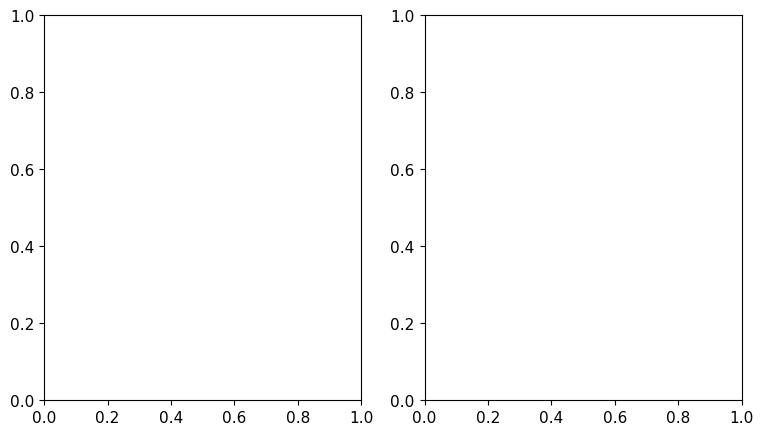

In [26]:
wow = show_offline_moistening_bias('v6')

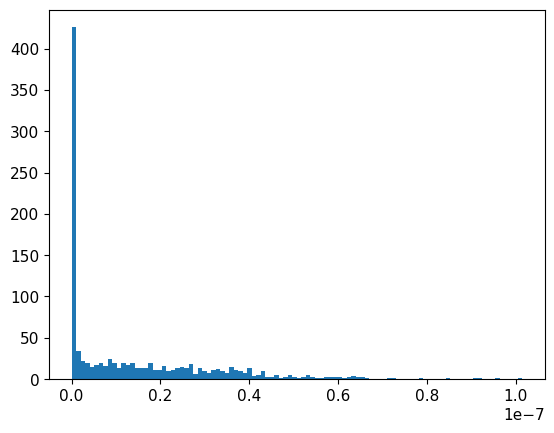

In [31]:
plt.hist(wow.std(dim = 'ensemble').values.flatten(), bins = 100);

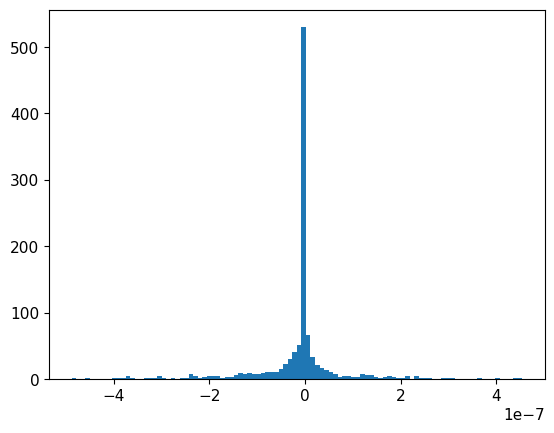

In [34]:
plt.hist(wow[0].values.flatten(), bins = 100);

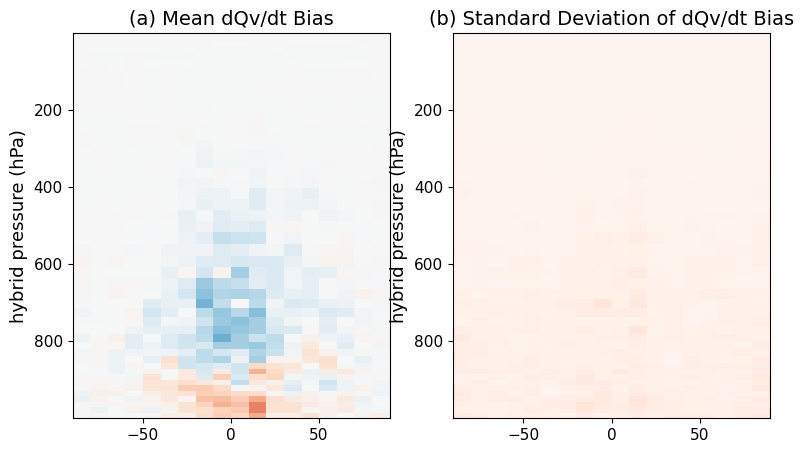

In [24]:
show_offline_moistening_bias('v6')

## Figure 9 (Offline Moistening Bias Zonal Mean)

In [ ]:
def plot_offline_bias_model_comparison(config_name, var, show = True, save_path = None):
    unet_preds = np.mean(np.array([config_preds[config_name]['unet'](seed) for seed in seeds]), axis = 0)
    squeezeformer_preds = np.mean(np.array([config_preds[config_name]['squeezeformer'](seed) for seed in seeds]), axis = 0)
    pure_resLSTM_preds = np.mean(np.array([config_preds[config_name]['pure_resLSTM'](seed) for seed in seeds]), axis = 0)
    pao_model_preds = np.mean(np.array([config_preds[config_name]['pao_model'](seed) for seed in seeds]), axis = 0)
    convnext_preds = np.mean(np.array([config_preds[config_name]['convnext'](seed) for seed in seeds]), axis = 0)
    encdec_lstm_preds = np.mean(np.array([config_preds[config_name]['encdec_lstm'](seed) for seed in seeds]), axis = 0)
    unet_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(unet_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    squeezeformer_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(squeezeformer_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    pure_resLSTM_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(pure_resLSTM_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    pao_model_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(pao_model_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    convnext_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(convnext_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])
    encdec_lstm_diff = offline_var_settings[var]['scaling'] * offline_area_time_mean_3d(encdec_lstm_preds[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)] - actual_target[:,:,offline_var_settings[var]['var_index']:(offline_var_settings[var]['var_index']+60)])

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    # Generate the panel labels
    labels = [f"({letter})" for letter in string.ascii_lowercase[:6]]
    latitude_ticks = [-60, -30, 0, 30, 60]
    latitude_labels = ['60S', '30S', '0', '30N', '60N']
    # Loop through each variable and its corresponding subplot row

    plotted_artists = {}

    plotted_artists['unet'] = unet_diff.plot(ax=axs[0,0], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    axs[0,0].set_title(f'{labels[0]} U-Net {offline_var_settings[var]["var_title"]} Bias')
    axs[0,0].invert_yaxis()
    axs[0,0].set_xlabel('')

    plotted_artists['squeezeformer'] = squeezeformer_diff.plot(ax=axs[0,1], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    axs[0,1].set_title(f'{labels[1]} SqueezeFormer {offline_var_settings[var]["var_title"]} Bias')
    axs[0,1].invert_yaxis()
    axs[0,1].set_ylabel('')
    axs[0,1].set_xlabel('')

    plotted_artists['pure_resLSTM'] = pure_resLSTM_diff.plot(ax=axs[0,2], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    axs[0,2].set_title(f'{labels[2]} Pure ResLSTM {offline_var_settings[var]["var_title"]} Bias')
    axs[0,2].invert_yaxis()
    axs[0,2].set_ylabel('')
    axs[0,2].set_xlabel('')

    plotted_artists['pao_model'] = pao_model_diff.plot(ax=axs[1,0], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    axs[1,0].set_title(f'{labels[3]} Pao Model {offline_var_settings[var]["var_title"]} Bias')
    axs[1,0].invert_yaxis()
    axs[1,0].set_xlabel('Latitude')

    plotted_artists['convnext'] = convnext_diff.plot(ax=axs[1,1], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    axs[1,1].set_title(f'{labels[4]} ConvNeXt {offline_var_settings[var]["var_title"]} Bias')
    axs[1,1].invert_yaxis()
    axs[1,1].set_xlabel('Latitude')
    axs[1,1].set_ylabel('')

    plotted_artists['encdec_lstm'] = encdec_lstm_diff.plot(ax=axs[1,2], add_colorbar=False, cmap='RdBu_r', vmin=offline_var_settings[var]['vmin'], vmax=offline_var_settings[var]['vmax'])
    axs[1,2].set_title(f'{labels[5]} Encoder-Decoder LSTM {offline_var_settings[var]["var_title"]} Bias')
    axs[1,2].invert_yaxis()
    axs[1,2].set_xlabel('Latitude')
    axs[1,2].set_ylabel('')

    # add a colorbar to each subplot

    model_order = ['unet', 'squeezeformer', 'pure_resLSTM', 'pao_model', 'convnext', 'encdec_lstm']
    for ax, var_key in zip(axs.flat, model_order):
        img = plotted_artists[var_key]  # Use the stored artist
        if img is not None: # Check if artist exists
            cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            # if var_key in ['DQ2PHYS', 'DQ3PHYS']:
            #     cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.0e}"))
        else:
            print(f"Warning: No artist found for variable {var_key} to create colorbar.")
    
    for ax in axs.flat:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
    plt.suptitle(f'Offline {offline_var_settings[var]["var_title"]} Tendency Biases Averaged Across Seeds ({offline_var_settings[var]["unit"]}) ({config_names[config_name]} Configuration)', x = .6, y = .95)
    plt.subplots_adjust(right=1, top=.9)
    if save_path:
        plt.savefig(os.path.join(save_path, f'offline_bias_model_comparison_{config_name}_{var}.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_offline_bias_model_comparison('v6', 'DQ1PHYS', show = True)

## Figure 10 (Offline Moistening Bias Vertical Profile Binned by Precipitation)

In [ ]:
def plot_binning_model_comparison(config_name, show = True, save_path = None):
    nn_preds = {model_name: np.mean(np.array([config_preds[config_name][model_name](seed) for seed in seeds]), axis = 0) for model_name in model_names.keys()}
    moistening_diffs = {model_name: (nn_preds[model_name][:,:,60:120] - actual_target[:,:,60:120]) * offline_var_settings['DQ1PHYS']['scaling'] for model_name in model_names.keys()}
    offline_precip_area_weights = {model_name: get_offline_precip_area_weights(nn_preds[model_name]) for model_name in model_names.keys()}
    cmap = matplotlib.colormaps['viridis']
    colors = cmap(np.linspace(0, 1, 11))
    alphas = np.linspace(0.1, 1, 11)
    fig, axs = plt.subplots(2, 3, figsize=(16, 10), constrained_layout=True)
    ax_flat = axs.flatten()
    letter_labels = [f"({letter})" for letter in string.ascii_lowercase[:6]]
    for ax_idx, model_name in enumerate(model_names.keys()):
        for precip_idx, precip_key in enumerate(offline_precip_area_weights[model_name].keys()): 
            ax_flat[ax_idx].plot(np.sum(np.sum(moistening_diffs[model_name] * offline_precip_area_weights[model_name][precip_key], axis=1), axis=0), 
                                 level, label=precip_percentile_labels[precip_key], linestyle='-', color=colors[precip_idx], alpha=alphas[precip_idx])
        ax_flat[ax_idx].invert_yaxis()
        if ax_idx > 2:
            ax_flat[ax_idx].set_xlabel('Moistening Tendency Bias (g/kg/s)')
        if ax_idx == 0 or ax_idx == 3:
            ax_flat[ax_idx].set_ylabel('Hybrid Pressure Level (hPa)')
        ax_flat[ax_idx].set_title(f'{letter_labels[ax_idx]} {model_names[model_name]}')
        ax_flat[ax_idx].legend()
        ax_flat[ax_idx].grid(True)
        ax_flat[ax_idx].set_xlim(-1.4e-6, 2.2e-6)
    plt.suptitle(f'Seed-Averaged Binned Offline Moistening Tendency Bias by Active Precipitation Percentile ({config_names[config_name]} Configuration)')
    if save_path:
        plt.savefig(os.path.join(save_path, f'offline_binned_moistening_tendency_bias_model_comparison_{config_name}.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
plot_binning_model_comparison(config_name = 'v6', show = True)

## Figure 11 (Five Year Global Mean RMSE vs SYPD)

In [61]:
def plot_global_rmse_vs_sypd(show = True, save_path = None):
    variables = ['T', 'Q', 'CLDLIQ', 'CLDICE', 'U', 'V']
    ylim_upper = {
        'T': 5,
        'Q': 0.7,
        'CLDLIQ': 40,
        'CLDICE': 8,
        'U': 9,
        'V': 2.5
    }
    marker_config_dict = {
        'standard': 'o',
        'conf_loss': '*',
        'diff_loss': '^',
        'multirep': 'v',
        'v6': 'D'
    }
    markersize_config_dict = {
        'standard': 8,
        'conf_loss': 11,
        'diff_loss': 8,
        'multirep': 8,
        'v6': 6
    }

    sublabels = [f'({chr(97 + i)})' for i in range(6)]
    # Create the figure with custom subplot layout
    fig = plt.figure(figsize=(11, 12.5), constrained_layout = True)
    gs = gridspec.GridSpec(4, 3, figure=fig, height_ratios=[1,1,.75,.75])

    #     # First row: 3 square scatter plots
    #     ax1 = plt.subplot2grid((4, 3), (0, 0))
    #     ax2 = plt.subplot2grid((4, 3), (0, 1))
    #     ax3 = plt.subplot2grid((4, 3), (0, 2))

    #     # Second row: 3 square scatter plots
    #     ax4 = plt.subplot2grid((4, 3), (1, 0))
    #     ax5 = plt.subplot2grid((4, 3), (1, 1))
    #     ax6 = plt.subplot2grid((4, 3), (1, 2))

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    # Second row: 3 square scatter plots
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2])

    scatter_axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    #     # Third row: one rectangular plot spanning all 3 columns
    #     ax7 = plt.subplot2grid((4, 3), (2, 0), colspan=3)

    #     # Fourth row: one rectangular plot spanning all 3 columns
    #     ax8 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

    # Third row: one rectangular plot spanning all 3 columns
    ax7 = fig.add_subplot(gs[2, :])

    # Fourth row: one rectangular plot spanning all 3 columns
    ax8 = fig.add_subplot(gs[3, :])
    
    sublabel_idx = 0
    for ax, var in zip(scatter_axes, variables):
        ax.axvline(x = min(huetal_sota_dict[var]), ymin = 0, ymax = 30, linestyle = '--', color = 'grey', alpha = .7)

        for idx, nn_sim in enumerate(nonnan_rmse_dict[var]):
            ax.scatter(nn_sim['rmse'], nn_sim['sypd'], marker = marker_config_dict[nn_sim['config_name']], color = color_dict[nn_sim['model_name']], alpha = .7, antialiased = True)

        ax.set_xlim(left = 0, right = ylim_upper[var])
        ax.tick_params(axis='both')
        ax.set_title(f"{sublabels[sublabel_idx]} {online_var_settings[var]['var_title']} ({online_var_settings[var]['unit']})", loc='center')  # Add main title with subplot label
        ax.set_xlabel(f"RMSE ({online_var_settings[var]['unit']})")  # Keep unit in x-label
        ax.grid(True, alpha = .5)
        sublabel_idx += 1

    # Create bar chart data for the middle plot
    unet_pc = [[pc_dict[config_name][model_name] for model_name in pc_dict[config_name].keys() if 'unet' in model_name][0] for config_name in config_names.keys()]
    squeezeformer_pc = [[pc_dict[config_name][model_name] for model_name in pc_dict[config_name].keys() if 'squeezeformer' in model_name][0] for config_name in config_names.keys()]
    pure_resLSTM_pc = [[pc_dict[config_name][model_name] for model_name in pc_dict[config_name].keys() if 'pure_resLSTM' in model_name][0] for config_name in config_names.keys()]
    pao_model_pc = [[pc_dict[config_name][model_name] for model_name in pc_dict[config_name].keys() if 'pao_model' in model_name][0] for config_name in config_names.keys()]
    convnext_pc = [[pc_dict[config_name][model_name] for model_name in pc_dict[config_name].keys() if 'convnext' in model_name][0] for config_name in config_names.keys()]
    encdec_lstm_pc = [[pc_dict[config_name][model_name] for model_name in pc_dict[config_name].keys() if 'encdec_lstm' in model_name][0] for config_name in config_names.keys()]

    x_positions = np.arange(len(config_names.values()))
    bar_width = 0.12
    
    # Calculate positions for 6 bars centered around each quarter
    offsets = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

    # Plot grouped bar charts with 6 products
    ax7.bar(x_positions + offsets[0] * bar_width, unet_pc, bar_width, 
            label=model_names['unet'], color=color_dict['unet'])
    ax7.bar(x_positions + offsets[1] * bar_width, squeezeformer_pc, bar_width, 
            label=model_names['squeezeformer'], color=color_dict['squeezeformer'])
    ax7.bar(x_positions + offsets[2] * bar_width, pure_resLSTM_pc, bar_width, 
            label=model_names['pure_resLSTM'], color=color_dict['pure_resLSTM'])
    ax7.bar(x_positions + offsets[3] * bar_width, pao_model_pc, bar_width, 
            label=model_names['pao_model'], color=color_dict['pao_model'])
    ax7.bar(x_positions + offsets[4] * bar_width, convnext_pc, bar_width, 
            label=model_names['convnext'], color=color_dict['convnext'])
    ax7.bar(x_positions + offsets[5] * bar_width, encdec_lstm_pc, bar_width, 
            label=model_names['encdec_lstm'], color=color_dict['encdec_lstm'])

    # Customize the middle plot
    ax7.set_title('(g) Trainable Parameter Count Per Architecture Across Configurations')
    ax7.set_ylabel('Parameter Count')
    ax7.set_xticks(x_positions)
    ax7.set_xticklabels(config_names.values())
    # ax7.grid(axis='y', linestyle='--', alpha=0.5)

    # Create bar chart data for the bottom plot
    unet_tt = [np.mean([tt_dict[config_name][model_name] for model_name in tt_dict[config_name].keys() if 'unet' in model_name]) for config_name in config_names.keys()]
    squeezeformer_tt = [np.mean([tt_dict[config_name][model_name] for model_name in tt_dict[config_name].keys() if 'squeezeformer' in model_name]) for config_name in config_names.keys()]
    pure_resLSTM_tt = [np.mean([tt_dict[config_name][model_name] for model_name in tt_dict[config_name].keys() if 'pure_resLSTM' in model_name]) for config_name in config_names.keys()]
    pao_model_tt = [np.mean([tt_dict[config_name][model_name] for model_name in tt_dict[config_name].keys() if 'pao_model' in model_name]) for config_name in config_names.keys()]
    convnext_tt = [np.mean([tt_dict[config_name][model_name] for model_name in tt_dict[config_name].keys() if 'convnext' in model_name]) for config_name in config_names.keys()]
    encdec_lstm_tt = [np.mean([tt_dict[config_name][model_name] for model_name in tt_dict[config_name].keys() if 'encdec_lstm' in model_name]) for config_name in config_names.keys()]

    # Plot grouped bar charts with 6 products
    ax8.bar(x_positions + offsets[0] * bar_width, unet_tt, bar_width, 
            label=model_names['unet'], color=color_dict['unet'])
    ax8.bar(x_positions + offsets[1] * bar_width, squeezeformer_tt, bar_width, 
            label=model_names['squeezeformer'], color=color_dict['squeezeformer'])
    ax8.bar(x_positions + offsets[2] * bar_width, pure_resLSTM_tt, bar_width, 
            label=model_names['pure_resLSTM'], color=color_dict['pure_resLSTM'])
    ax8.bar(x_positions + offsets[3] * bar_width, pao_model_tt, bar_width, 
            label=model_names['pao_model'], color=color_dict['pao_model'])
    ax8.bar(x_positions + offsets[4] * bar_width, convnext_tt, bar_width, 
            label=model_names['convnext'], color=color_dict['convnext'])
    ax8.bar(x_positions + offsets[5] * bar_width, encdec_lstm_tt, bar_width, 
            label=model_names['encdec_lstm'], color=color_dict['encdec_lstm'])

    # Customize the middle plot
    ax8.set_title('(h) Seed-Averaged Training Time Per Architecture Across Configurations')
    ax8.set_ylabel('Hours')
    ax8.set_xticks(x_positions)
    ax8.set_xticklabels(config_names.values())
    # ax8.grid(axis='y', linestyle='--', alpha=0.5)

    for ax in [ax7, ax8]:
        ax.grid(True, axis = 'y', which='major', linestyle='-', alpha=0.7)
        ax.grid(True, axis = 'y', which='minor', linestyle='--', alpha=0.4)
        ax.minorticks_on()  # Enable minor ticks for more grid lines

    # --- Proxy lines for models (color key) ---
    huetal_line = mlines.Line2D([], [], color='grey', lw=2, linestyle = '--', label='Hu et al. 2025')
    unet_line = mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_dict['unet'], markersize=8, label=f'{model_names["unet"]}')
    squeezeformer_line = mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_dict['squeezeformer'], markersize=8, label=f'{model_names["squeezeformer"]}')
    pure_resLSTM_line = mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_dict['pure_resLSTM'], markersize=8, label=f'{model_names["pure_resLSTM"]}')
    pao_model_line = mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_dict['pao_model'], markersize=8, label=f'{model_names["pao_model"]}')
    convnext_line = mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_dict['convnext'], markersize=8, label=f'{model_names["convnext"]}')
    encdec_lstm_line = mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_dict['encdec_lstm'], markersize=8, label=f'{model_names["encdec_lstm"]}')

    # --- Proxy "letters" for configurations (letter key) ---
    shape_handles = [
        mlines.Line2D([0], [0], marker=marker, color='w', markerfacecolor='gray', markersize=markersize_config_dict[label], label=config_names[label], linestyle='None') for label, marker in marker_config_dict.items()
    ]

    # First, add the model legend
    legend1 = fig.legend(handles=[huetal_line, unet_line, squeezeformer_line, pure_resLSTM_line, pao_model_line, convnext_line, encdec_lstm_line], 
                        loc='center left', bbox_to_anchor=(1.0, .6), 
                        title='Model Architectures')

    # Then, add the configuration legend
    legend2 = fig.legend(handles=shape_handles, 
                        loc='center left', bbox_to_anchor=(1.0, 0.35), 
                        title='Configurations')

    fig.gca().add_artist(legend1)  # Make sure both legends show up

    # handles = [line_mmf, line_unet, line_squeezeformer, line_pure_resLSTM, line_pao_model, line_convnext, line_encdec_lstm]
    # labels = ['MMF2', model_names['unet'], model_names['squeezeformer'], model_names['pure_resLSTM'], model_names['pao_model'], model_names['convnext'], model_names['encdec_lstm']]

    # fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.27, 0.5), title='Model')
    fig.suptitle(f'(a-f) Five Year Online Global Mean RMSE vs. SYPD')
    # Set a shared y-label for the first column
    scatter_axes[0].set_ylabel('SYPD')
    scatter_axes[3].set_ylabel('SYPD')
    plt.tight_layout()
    # plt.savefig('state_rmse_profiles_and_scalar.pdf', format='pdf', dpi=400, bbox_inches='tight')
    if save_path:
        plt.savefig(os.path.join(save_path, f'online_{num_years}_year_global_RMSE_model_comparison_{config_name}.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

/tmp/ipykernel_534376/2031118279.py:181: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


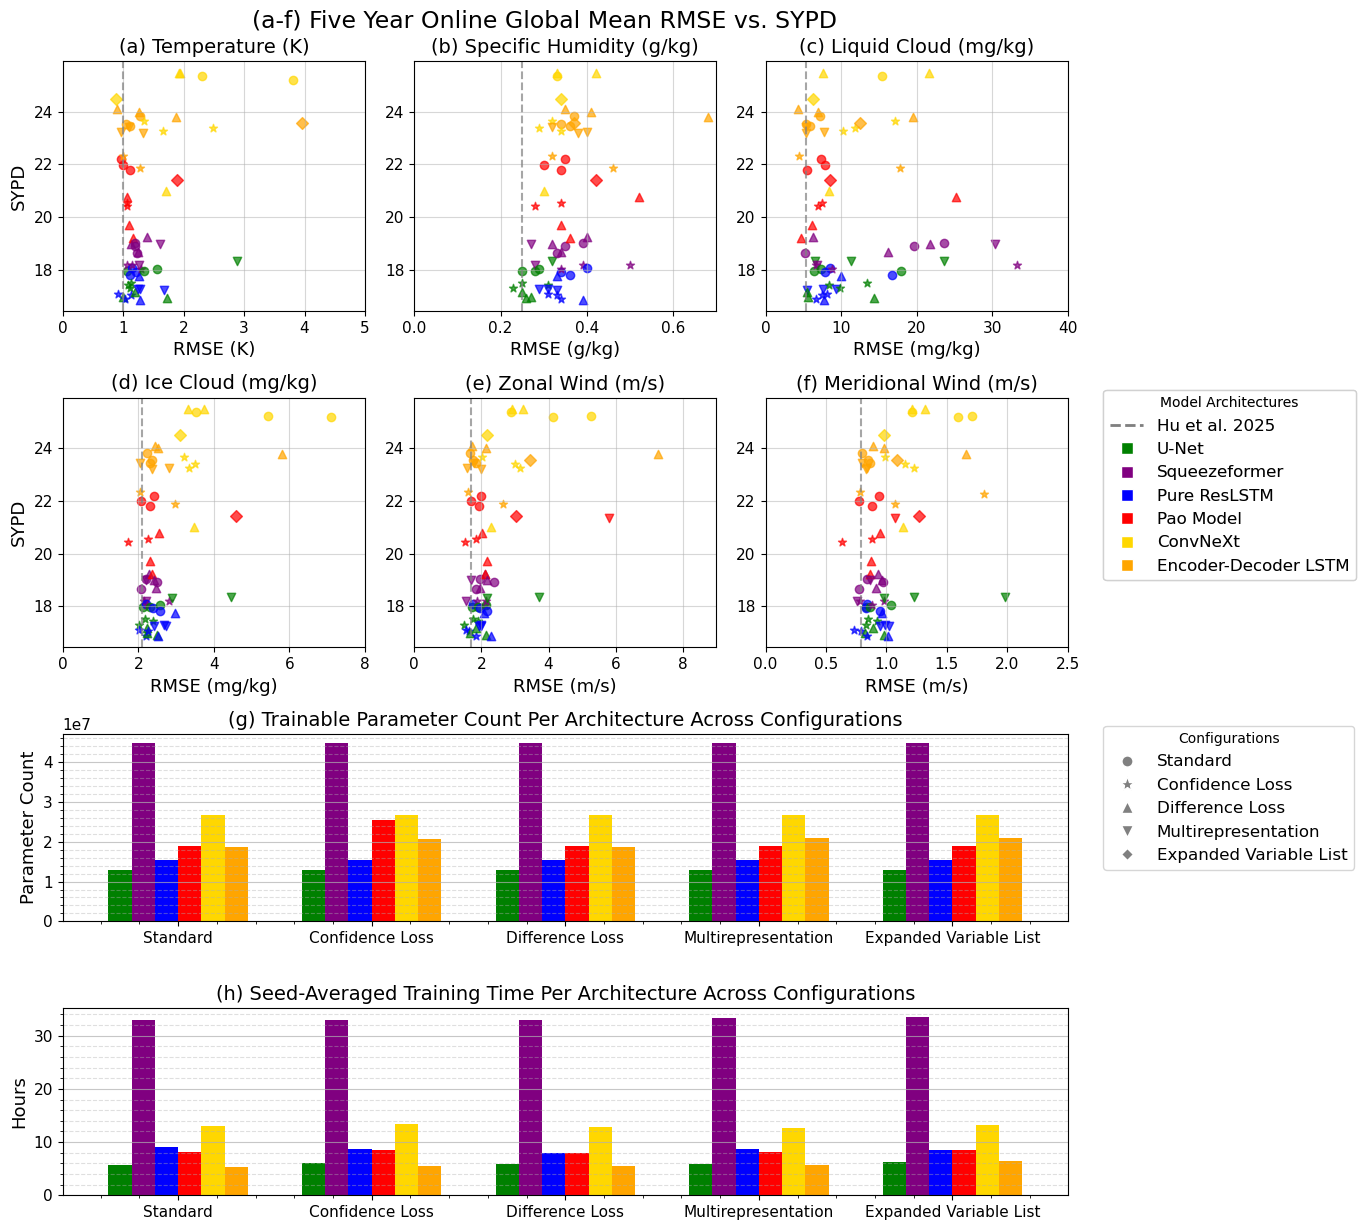

In [62]:
plot_global_rmse_vs_sypd()